In [1]:
import ast
import pickle

import gymnasium as gym
import mlflow
import numpy as np
import pandas as pd
import torch
from imitation.algorithms.adversarial.airl import AIRL
from imitation.data import rollout
from imitation.data.rollout import flatten_trajectories
from imitation.data.types import Trajectory
from imitation.data.wrappers import RolloutInfoWrapper
from imitation.rewards.reward_nets import BasicShapedRewardNet
from imitation.util.networks import RunningNorm
from imitation.util.util import make_vec_env
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import VecCheckNan
from stable_baselines3.ppo import MlpPolicy

from graph_reinforcement_learning_using_blockchain_data import config

config.load_dotenv()
mlflow.set_tracking_uri(uri=config.MLFLOW_TRACKING_URI)

2025-04-14 13:32:57.001 | INFO     | graph_reinforcement_learning_using_blockchain_data.config:<module>:12 - PROJ_ROOT path is: /Users/liamtessendorf/Programming/Uni/2_Master/4_FS25_Programming/graph-reinforcement-learning-using-blockchain-data


In [372]:
RNG = np.random.default_rng(seed=42)

In [373]:
df_emb = pd.read_csv(config.FLASHBOTS_Q2_DATA_DIR / "state_embeddings.csv")
df_class0 = pd.read_csv(config.RAW_DATA_DIR / "receipts_class0.csv")
df_class1 = pd.read_csv(config.RAW_DATA_DIR / "receipts_class1.csv")

In [374]:
df_class1.sort_values(by=["block_number", "from"])

id                  created_at  \
0      7108fc71-883d-45b2-a6d4-0da61eb0a777  2023-05-18 15:32:43.208654   
1      23cd0052-4fb9-4ded-a6ff-5c2c7998f24d  2023-05-18 15:32:45.587223   
3      0fb64b84-3bf8-4ca2-a5da-58c89fda51e1  2023-05-18 15:32:53.751029   
2      a37c326f-9630-4034-ba32-4dd24544a5f2  2023-05-18 15:32:53.751029   
4      26170f74-d174-4fec-a07f-7f95b9eb90cb  2023-05-18 15:33:07.228647   
...                                     ...                         ...   
95944  f467ab1d-e296-4b5f-af80-2a77d9b0a4ae  2023-06-20 08:19:45.432909   
95945  c0bc39a2-5759-43b5-b62c-7c44562dbbc5  2023-06-20 08:19:45.432909   
95980  3d18a63c-5492-4161-8828-e0545429e1e5  2023-06-20 08:20:43.491901   
96028  4b3c54ea-c8b4-40a9-bed7-11a8307d2536  2023-06-20 08:21:28.118196   
96029  41a619ac-f764-4bcb-ad25-3a5a0a71562f  2023-06-20 08:21:28.118196   

                                  account_address  \
0      0x4870525eae23fceb31df613d179ef6275e1b93a9   
1      0x4870525eae23fceb31df613d179ef6275e1b93a9   
3      0x7efd91c8ca31e7452c5c4de00a8ca1c18910a35f   
2      0x4870525eae23fceb31df613d179ef6275e1b93a9   
4      0x4870525eae23fceb31df613d179ef6275e1b93a9   
...                                           ...   
95944  0x000000000005af2ddc1a93a03e9b7014064d3b8d   
95945  0x000000000005af2ddc1a93a03e9b7014064d3b8d   
95980  0x2d2a7d56773ae7d5c7b9f1b57f7be05039447b4d   
96028  0xa80db00007020e013fa10d0560700c0018003b8b   
96029  0x6b75d8af000000e20b7a7ddf000ba900b4009a80   

                             profit_token_address  block_number  \
0      0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2      16950601   
1      0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2      16950602   
3      0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2      16950607   
2      0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2      16950607   
4      0xdac17f958d2ee523a2206206994597c13d831ec7      16950616   
...                                           ...           ...   
95944  0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2      17517746   
95945  0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2      17517746   
95980  0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48      17517762   
96028  0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2      17517766   
96029  0xdac17f958d2ee523a2206206994597c13d831ec7      17517773   

                                                         transaction_hash  \
0      0x7836e253e6b932564e23e3162badd365ff8fbfa93f9f71edec01653552746510   
1      0x299048408548ccd465e99a83d7342467a65a780064f41fd045d122632a25fb6b   
3      0xbd92de852e56dcb439aa576a0161fe5b8e0ab0735ef409dfa0309988acaa1ba6   
2      0xb5ad6f9c677f1b7b618e9b138f601940f74a111b400460706c24876b00958809   
4      0x84def9f72e2962af2c27ed8a95a84971c00212dc23b7373a38e833ecbbe498fa   
...                                                                   ...   
95944  0xe9e4267a40f834c34c639d98db0d58ec16de6987d3ed58087cf9906a04696433   
95945  0x4dd894e85ca011b493c4c135cb44ef2db5f22b8a76f428e3986100f1dd70558c   
95980  0x6f800b845f1f974690d9d1f3919bfc83e776c6be3ce04aacf0a9b1f2ac92c4f8   
96028  0x05b277e32ff184d649a8da4d2591f85db8ea7e87aec654a94c6e8b24abdbc1fc   
96029  0x22ebd8578a408441394bf8c5d995d6ea8fd69fd809d68836af774ef35fc01857   

              start_amount           end_amount         profit_amount error  \
0        54865003552880478    62515568704076031      7650565151195553   NaN   
1        89185111706660168    92271485564350625      3086373857690457   NaN   
3       554451451942816833   561352734048392148      6901282105575315   NaN   
2        91060864908553544    96762829684099802      5701964775546258   NaN   
4                920317261            929402944               9085683   NaN   
...                    ...                  ...                   ...   ...   
95944   827343750000000000  2160198717202595240   1332854967202595240   NaN   
95945  2172738313674926757   860423373615963396  -1312314940058963361   NaN   
95980           2099020510           2138537386              3

In [375]:
df_emb["embeddings"] = df_emb["embeddings"].apply(
    lambda x: np.array(ast.literal_eval(x), dtype=np.float32)
)

In [376]:
df_class0["label"] = 0
df_class1["label"] = 1

In [377]:
df_receipts = pd.concat([df_class0, df_class1], ignore_index=True)
df_receipts.drop_duplicates("transaction_hash", inplace=True)
df = df_receipts.merge(df_emb, how="right", left_on="transaction_hash", right_on="transactionHash")

In [378]:
df.head()

,block_number,transaction_hash,blockHash,blockNumber,logsBloom,gasUsed,contractAddress,cumulativeGasUsed,transactionIndex,from,...,created_at,account_address,profit_token_address,start_amount,end_amount,profit_amount,error,protocols,transactionHash,embeddings
0,16969850,0xe4029c908cfc40f825051cd0957797c66196eb8ba437138275f511d837e43e9e,0x241b2ebd536a6f546ce2214bcf2146d359ae4e0cc4e303be8b2621559ea86cce,16969850,0x00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000,21000,NaN,1315400,19,0x00000000000124d994209fbB955E0217B5C2ECA1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0xe4029c908cfc40f825051cd0957797c66196eb8ba437138275f511d837e43e9e,"[-1.0455092, -0.45075172, -1.2988981, 0.6896748, -1.1164293, 1.7514414, 0.80752736, -1.0001401, -0.8975098, 1.1457884, -0.09576925, 0.16193613, 0.30121136, 0.35855946, -1.320206, -1.11396, -0.75449765, 1.3367178, 1.0179006, 1.4095235, -0.14788966, 0.51006746, 0.17084041, 0.48025137, -1.3203003, -0.80892503, 0.6237679, -0.97854835, 1.0150695, 0.6114788, -1.1246197, 0.6560293, 1.1889045, -0.6563245, 1.103117, 0.1877509, 1.7167103, 0.8275193, 0.7837621, 0.0068215095, -0.17481492, 1.2197685, -0.24703479, 0.16611227, -1.4173074, -0.43391758, 0.6339325, 0.8465983, 0.84296966, 1.3004094, 0.45688266, -0.11421638, 1.0028092, -0.956703, 0.7193447, -0.94900703, 0.84689337, -0.8999449, -1.2802402, 0.74399006, 1.2653081, 0.58139986, -0.9094235, -1.6148877, -0.53880817, -1.2694414, 0.5994664, -1.9631301, 0.111518614, -0.34107527, 1.2065705, 0.52661383, -1.1155782, 0.47890857, 0.36536908, -1.3042232, -1.3208169, -1.960998, 1.2480768, -1.999326, 0.84277964, 0.4894807, -0.093439564, 1.4356178, 1.2658045, 0.82035065, 1.2675717, -0.8197057, 0.37391096, 0.7005414, -0.5062533, 1.257955, 0.7458384, -0.9302416, -0.942372, -1.4894803, 0.6942808, 0.80691504, -1.2421052, -0.3385557, ...]"
1,16975162,0xbcfb84169287cf7acce33fba2b7390cfe21852871f78851fcf3f3a4cb9c34349,0x577d4ef683ebd84c73cdbc3635c7177f6ec137eef3bf09e9753a030e25c73458,16975162,0x0000000000000000000000008000000000000000000000000000000000000000000000000000000000000000000000000200000008102000000000000000000000002000000008080000000800000000000000000440000400000000000000000000000000000000000000000000000000000000000004000000001000080000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000440000000000000000000000000000400000000000a000000000000000000000000000000000000000000000002000000010000200000000000002400000001000000000000000000040000000000000000,116880,NaN,396290,3,0x00000000000124d994209fbB955E0217B5C2ECA1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0xbcfb84169287cf7acce33fba2b7390cfe21852871f78851fcf3f3a4cb9c34349,"[-6.1341934, -4.090339, -6.813894, 2.9215977, -5.5051394, 7.1838846, 4.8099427, -6.2062006, -5.460009, 6.5267, -0.8781398, 3.007705, 2.903044, 0.67859405, -7.4199133, -4.5308304, -5.0637574, 7.6216993, 6.7226477, 7.0981913, -2.7796981, 1.852809, -0.78909373, 2.7312555, -6.3442636, -4.45346, 5.4239025, -5.243399, 5.258979, 4.3196898, -6.948171, 4.1489367, 1.9921558, -2.4718854, 6.702455, 1.2753669, 4.549116, 4.744337, 5.282066, -0.4526421, -1.5847656, 6.6456037, -0.033841096, -3.6784778, -6.6479125, -2.0949347, 2.2313242, 5.6285257, 5.8385725, 7.522571, 0.9031833, -2.714743, 2.0389683, -5.037761, 5.0004773, -2.0461693, 5.666483, -0.7457095, -8.539506, 4.66249, 3.8094585, 4.3448896, -5.1184263, -7.4352612, 0.021960897, -7.131702, 1.3266057, -9.299525, -1.5526823, -2.8869946, 4.803319, 3.156914, -5.0397973, 2.4199867, 3.745797, -5.8035183, -7.1071887, -7.7526174, 7.595811, -9

In [379]:
ser_median_gas_prices = pd.DataFrame(
    {"median_gas_price": df.groupby(["block_number"])["effectiveGasPrice"].median()}
)
df_with_median_gas_prices = df.merge(ser_median_gas_prices, how="left", on="block_number")
df_with_median_gas_prices.head()

,block_number,transaction_hash,blockHash,blockNumber,logsBloom,gasUsed,contractAddress,cumulativeGasUsed,transactionIndex,from,...,account_address,profit_token_address,start_amount,end_amount,profit_amount,error,protocols,transactionHash,embeddings,median_gas_price
0,16969850,0xe4029c908cfc40f825051cd0957797c66196eb8ba437138275f511d837e43e9e,0x241b2ebd536a6f546ce2214bcf2146d359ae4e0cc4e303be8b2621559ea86cce,16969850,0x00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000,21000,NaN,1315400,19,0x00000000000124d994209fbB955E0217B5C2ECA1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0xe4029c908cfc40f825051cd0957797c66196eb8ba437138275f511d837e43e9e,"[-1.0455092, -0.45075172, -1.2988981, 0.6896748, -1.1164293, 1.7514414, 0.80752736, -1.0001401, -0.8975098, 1.1457884, -0.09576925, 0.16193613, 0.30121136, 0.35855946, -1.320206, -1.11396, -0.75449765, 1.3367178, 1.0179006, 1.4095235, -0.14788966, 0.51006746, 0.17084041, 0.48025137, -1.3203003, -0.80892503, 0.6237679, -0.97854835, 1.0150695, 0.6114788, -1.1246197, 0.6560293, 1.1889045, -0.6563245, 1.103117, 0.1877509, 1.7167103, 0.8275193, 0.7837621, 0.0068215095, -0.17481492, 1.2197685, -0.24703479, 0.16611227, -1.4173074, -0.43391758, 0.6339325, 0.8465983, 0.84296966, 1.3004094, 0.45688266, -0.11421638, 1.0028092, -0.956703, 0.7193447, -0.94900703, 0.84689337, -0.8999449, -1.2802402, 0.74399006, 1.2653081, 0.58139986, -0.9094235, -1.6148877, -0.53880817, -1.2694414, 0.5994664, -1.9631301, 0.111518614, -0.34107527, 1.2065705, 0.52661383, -1.1155782, 0.47890857, 0.36536908, -1.3042232, -1.3208169, -1.960998, 1.2480768, -1.999326, 0.84277964, 0.4894807, -0.093439564, 1.4356178, 1.2658045, 0.82035065, 1.2675717, -0.8197057, 0.37391096, 0.7005414, -0.5062533, 1.257955, 0.7458384, -0.9302416, -0.942372, -1.4894803, 0.6942808, 0.80691504, -1.2421052, -0.3385557, ...]",28412775831.00000
1,16975162,0xbcfb84169287cf7acce33fba2b7390cfe21852871f78851fcf3f3a4cb9c34349,0x577d4ef683ebd84c73cdbc3635c7177f6ec137eef3bf09e9753a030e25c73458,16975162,0x0000000000000000000000008000000000000000000000000000000000000000000000000000000000000000000000000200000008102000000000000000000000002000000008080000000800000000000000000440000400000000000000000000000000000000000000000000000000000000000004000000001000080000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000440000000000000000000000000000400000000000a000000000000000000000000000000000000000000000002000000010000200000000000002400000001000000000000000000040000000000000000,116880,NaN,396290,3,0x00000000000124d994209fbB955E0217B5C2ECA1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0xbcfb84169287cf7acce33fba2b7390cfe21852871f78851fcf3f3a4cb9c34349,"[-6.1341934, -4.090339, -6.813894, 2.9215977, -5.5051394, 7.1838846, 4.8099427, -6.2062006, -5.460009, 6.5267, -0.8781398, 3.007705, 2.903044, 0.67859405, -7.4199133, -4.5308304, -5.0637574, 7.6216993, 6.7226477, 7.0981913, -2.7796981, 1.852809, -0.78909373, 2.7312555, -6.3442636, -4.45346, 5.4239025, -5.243399, 5.258979, 4.3196898, -6.948171, 4.1489367, 1.9921558, -2.4718854, 6.702455, 1.2753669, 4.549116, 4.744337, 5.282066, -0.4526421, -1.5847656, 6.6456037, -0.033841096, -3.6784778, -6.6479125, -2.0949347, 2.2313242, 5.6285257, 5.8385725, 7.522571, 0.9031833, -2.714743, 2.0389683, -5.037761, 5.0004773, -2.0461693, 5.666483, -0.7457095, -8.539506, 4.66249, 3.8094585, 4.3448896, -5.1184263, -7.4352612, 0.021960897, -7.131702, 1.3266057, -9.299525, -1.5526823, -2.8869946, 4.803319, 3.156914, -5.0397973, 2.4199867, 3.745797, -5.8035183, -7.1071887, -7.75261

In [380]:
df_with_actions = df_with_median_gas_prices.copy()
df_with_actions["action"] = df_with_median_gas_prices.apply(
    lambda r: 1 if r["effectiveGasPrice"] > r["median_gas_price"] else 0, axis=1
)

In [381]:
df_with_actions["action"].mean()

0.24449359876667337

In [382]:
df_with_actions.head()

,block_number,transaction_hash,blockHash,blockNumber,logsBloom,gasUsed,contractAddress,cumulativeGasUsed,transactionIndex,from,...,profit_token_address,start_amount,end_amount,profit_amount,error,protocols,transactionHash,embeddings,median_gas_price,action
0,16969850,0xe4029c908cfc40f825051cd0957797c66196eb8ba437138275f511d837e43e9e,0x241b2ebd536a6f546ce2214bcf2146d359ae4e0cc4e303be8b2621559ea86cce,16969850,0x00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000,21000,NaN,1315400,19,0x00000000000124d994209fbB955E0217B5C2ECA1,...,NaN,NaN,NaN,NaN,NaN,NaN,0xe4029c908cfc40f825051cd0957797c66196eb8ba437138275f511d837e43e9e,"[-1.0455092, -0.45075172, -1.2988981, 0.6896748, -1.1164293, 1.7514414, 0.80752736, -1.0001401, -0.8975098, 1.1457884, -0.09576925, 0.16193613, 0.30121136, 0.35855946, -1.320206, -1.11396, -0.75449765, 1.3367178, 1.0179006, 1.4095235, -0.14788966, 0.51006746, 0.17084041, 0.48025137, -1.3203003, -0.80892503, 0.6237679, -0.97854835, 1.0150695, 0.6114788, -1.1246197, 0.6560293, 1.1889045, -0.6563245, 1.103117, 0.1877509, 1.7167103, 0.8275193, 0.7837621, 0.0068215095, -0.17481492, 1.2197685, -0.24703479, 0.16611227, -1.4173074, -0.43391758, 0.6339325, 0.8465983, 0.84296966, 1.3004094, 0.45688266, -0.11421638, 1.0028092, -0.956703, 0.7193447, -0.94900703, 0.84689337, -0.8999449, -1.2802402, 0.74399006, 1.2653081, 0.58139986, -0.9094235, -1.6148877, -0.53880817, -1.2694414, 0.5994664, -1.9631301, 0.111518614, -0.34107527, 1.2065705, 0.52661383, -1.1155782, 0.47890857, 0.36536908, -1.3042232, -1.3208169, -1.960998, 1.2480768, -1.999326, 0.84277964, 0.4894807, -0.093439564, 1.4356178, 1.2658045, 0.82035065, 1.2675717, -0.8197057, 0.37391096, 0.7005414, -0.5062533, 1.257955, 0.7458384, -0.9302416, -0.942372, -1.4894803, 0.6942808, 0.80691504, -1.2421052, -0.3385557, ...]",28412775831.00000,1
1,16975162,0xbcfb84169287cf7acce33fba2b7390cfe21852871f78851fcf3f3a4cb9c34349,0x577d4ef683ebd84c73cdbc3635c7177f6ec137eef3bf09e9753a030e25c73458,16975162,0x0000000000000000000000008000000000000000000000000000000000000000000000000000000000000000000000000200000008102000000000000000000000002000000008080000000800000000000000000440000400000000000000000000000000000000000000000000000000000000000004000000001000080000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000440000000000000000000000000000400000000000a000000000000000000000000000000000000000000000002000000010000200000000000002400000001000000000000000000040000000000000000,116880,NaN,396290,3,0x00000000000124d994209fbB955E0217B5C2ECA1,...,NaN,NaN,NaN,NaN,NaN,NaN,0xbcfb84169287cf7acce33fba2b7390cfe21852871f78851fcf3f3a4cb9c34349,"[-6.1341934, -4.090339, -6.813894, 2.9215977, -5.5051394, 7.1838846, 4.8099427, -6.2062006, -5.460009, 6.5267, -0.8781398, 3.007705, 2.903044, 0.67859405, -7.4199133, -4.5308304, -5.0637574, 7.6216993, 6.7226477, 7.0981913, -2.7796981, 1.852809, -0.78909373, 2.7312555, -6.3442636, -4.45346, 5.4239025, -5.243399, 5.258979, 4.3196898, -6.948171, 4.1489367, 1.9921558, -2.4718854, 6.702455, 1.2753669, 4.549116, 4.744337, 5.282066, -0.4526421, -1.5847656, 6.6456037, -0.033841096, -3.6784778, -6.6479125, -2.0949347, 2.2313242, 5.6285257, 5.8385725, 7.522571, 0.9031833, -2.714743, 2.0389683, -5.037761, 5.0004773, -2.0461693, 5.666483, -0.7457095, -8.539506, 4.66249, 3.8094585, 4.3448896, -5.1184263, -7.4352612, 0.021960897, -7.131702, 1.3266057, -9.299525, -1.5526823, -2.8869946, 4.803319, 3.156914, -5.0397973, 2.4199867, 3.745797, -5.8035183, -7.1071887, -7.7526174, 7.595811, -

In [383]:
df_with_actions_0 = df_with_actions[df_with_actions["label"] == 0]
df_with_actions_1 = df_with_actions[df_with_actions["label"] == 1]

In [391]:
unique_accs_0 = df_with_actions_0["from"].unique()
accs_train_0 = unique_accs_0[: int(0.8 * len(unique_accs_0))]
accs_val_0 = unique_accs_0[int(0.8 * len(unique_accs_0)) : int(0.9 * len(unique_accs_0))]
accs_test_0 = unique_accs_0[int(0.9 * len(unique_accs_0)) :]
df_with_actions_0_train = df_with_actions_0[df_with_actions_0["from"].isin(accs_train_0)]
df_with_actions_0_val = df_with_actions_0[df_with_actions_0["from"].isin(accs_val_0)]
df_with_actions_0_test = df_with_actions_0[df_with_actions_0["from"].isin(accs_test_0)]

In [392]:
unique_accs_1 = df_with_actions_1["from"].unique()
accs_train_1 = unique_accs_1[: int(0.8 * len(unique_accs_1))]
accs_val_1 = unique_accs_1[int(0.8 * len(unique_accs_1)) : int(0.9 * len(unique_accs_1))]
accs_test_1 = unique_accs_1[int(0.9 * len(unique_accs_1)) :]
df_with_actions_1_train = df_with_actions_1[df_with_actions_1["from"].isin(accs_train_1)]
df_with_actions_1_val = df_with_actions_1[df_with_actions_1["from"].isin(accs_val_1)]
df_with_actions_1_test = df_with_actions_1[df_with_actions_1["from"].isin(accs_test_1)]

In [393]:
df_val = pd.concat([df_with_actions_0_val, df_with_actions_1_val])

In [394]:
df_with_actions_1_train[
    df_with_actions_1_train["from"] == "0x1e6c1c4669f612112a7caCa5596BfE6629e669aA"
]

,block_number,transaction_hash,blockHash,blockNumber,logsBloom,gasUsed,contractAddress,cumulativeGasUsed,transactionIndex,from,...,profit_token_address,start_amount,end_amount,profit_amount,error,protocols,transactionHash,embeddings,median_gas_price,action


In [395]:
def extract_trajectories(df: pd.DataFrame):
    trajectories = []
    for account, group in df.groupby("from"):
        group = group.sort_values("blockNumber")
        obs_list = group["embeddings"].tolist() + [np.zeros(128, dtype=np.float32)]
        traj = {
            "obs": np.stack(obs_list),  # Convert list of arrays to a single numpy array
            "acts": np.array(group["action"].tolist()),
            "label": group["label"].iloc[0],
        }
        trajectories.append(traj)
    return trajectories


trajectories_1_train = extract_trajectories(df_with_actions_1_train)
trajectories_0_train = extract_trajectories(df_with_actions_0_train)
trajectories_1_test = extract_trajectories(df_with_actions_1_test)
trajectories_0_test = extract_trajectories(df_with_actions_0_test)
trajectories_val = extract_trajectories(df_val)

In [396]:
trajectories_1 = [
    Trajectory(obs=traj["obs"], acts=traj["acts"], infos=None, terminal=True)
    for traj in trajectories_1_train
]
trajectories_0 = [
    Trajectory(obs=traj["obs"], acts=traj["acts"], infos=None, terminal=True)
    for traj in trajectories_0_train
]
trajectories_val = [
    Trajectory(obs=traj["obs"], acts=traj["acts"], infos=None, terminal=True)
    for traj in trajectories_val
]

trajectories_1 = flatten_trajectories(trajectories_1)
trajectories_0 = flatten_trajectories(trajectories_0)
trajectories_val = flatten_trajectories(trajectories_val)

In [397]:
trajectories_1_test = [
    Trajectory(obs=traj["obs"], acts=traj["acts"], infos=None, terminal=True)
    for traj in trajectories_1_test
]
trajectories_0_test = [
    Trajectory(obs=traj["obs"], acts=traj["acts"], infos=None, terminal=True)
    for traj in trajectories_0_test
]

trajectories_1_test = flatten_trajectories(trajectories_1_test)
trajectories_0_test = flatten_trajectories(trajectories_0_test)

In [347]:
class TransactionGraphEnv(gym.Env):
    def __init__(
        self,
        df: pd.DataFrame,
        alpha: float,
    ):
        self.df = df.copy()
        self.accounts = df["from"].unique()
        self.account_index = None
        self.transaction_index = None
        self.alpha = alpha
        self.observation_space = gym.spaces.Box(
            low=-np.inf,
            high=np.inf,
            shape=(128,),
            dtype=np.float32,
        )
        self.action_space = gym.spaces.Discrete(2)
        self.current_trajectory = None
        self.current_account_transactions = None

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.account_index = RNG.integers(0, len(self.accounts))
        self.transaction_index = 0
        self.current_trajectory = []
        self.current_account_transactions = self.df[
            self.df["from"] == self.accounts[self.account_index]
        ]
        self.current_account_transactions = self.current_account_transactions.sort_values(
            by=["blockNumber"]
        )
        return self._get_observation(), {}

    def _get_observation(self):
        if self.transaction_index >= len(self.current_account_transactions):
            return np.zeros(self.observation_space.shape, dtype=np.float32)

        obs = self.current_account_transactions.iloc[self.transaction_index]["embeddings"]
        obs = np.array(obs, dtype=np.float32)
        return obs

    def step(self, action):
        obs = self._get_observation()
        # If this is the first transaction, there's no previous action to compare.
        if self.transaction_index == 0:
            reward = 0  # or some default reward
        else:
            # Compute reward based on the previous transaction's expert action.
            current_tx = self.current_account_transactions.iloc[self.transaction_index - 1]
            # print(current_tx["transaction_hash"])
            # print(current_tx["from"])
            actual_action = current_tx["action"]
            reward = 1.0 if action == actual_action else -1.0

        self.current_trajectory.append((obs, action))
        self.transaction_index += 1

        done = False
        info = {}
        if self.transaction_index >= len(self.current_account_transactions):
            done = True

            # metadata
            last_tx = self.current_account_transactions.iloc[self.transaction_index - 1]
            info = {
                "from": self.accounts[self.account_index],
                "num_transactions": self.transaction_index,
                "last_block": last_tx["blockNumber"],
                "trajectory": self.current_trajectory,
            }

            # move to next account
            self.account_index += 1
            self.transaction_index = 0
            if self.account_index < len(self.accounts):
                self.current_account_transactions = self.df[
                    self.df["from"] == self.accounts[self.account_index]
                ]
                self.current_account_transactions = self.current_account_transactions.sort_values(
                    by=["blockNumber"]
                )
            else:
                done = True

        next_obs = self._get_observation()
        return next_obs, reward, done, False, info

In [204]:
ID0 = "gymnasium_env/TransactionGraphEnv0-v0"
gym.envs.register(
    id=ID0,
    entry_point=TransactionGraphEnv,
    kwargs={"df": df_with_actions_0, "alpha": 0.9},
    max_episode_steps=300,
)

ID1 = "gymnasium_env/TransactionGraphEnv1-v0"
gym.envs.register(
    id=ID1,
    entry_point=TransactionGraphEnv,
    kwargs={"df": df_with_actions_1, "alpha": 0.9},
    max_episode_steps=300,
)

/Users/liamtessendorf/Programming/Uni/2_Master/4_FS25_Programming/graph-reinforcement-learning-using-blockchain-data/venv/lib/python3.12/site-packages/gymnasium/envs/registration.py:694: UserWarning: WARN: Overriding environment gymnasium_env/TransactionGraphEnv0-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/Users/liamtessendorf/Programming/Uni/2_Master/4_FS25_Programming/graph-reinforcement-learning-using-blockchain-data/venv/lib/python3.12/site-packages/gymnasium/envs/registration.py:694: UserWarning: WARN: Overriding environment gymnasium_env/TransactionGraphEnv1-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


In [205]:
gym.pprint_registry()

===== classic_control =====
Acrobot-v1             CartPole-v0            CartPole-v1
MountainCar-v0         MountainCarContinuous-v0 Pendulum-v1
===== phys2d =====
phys2d/CartPole-v0     phys2d/CartPole-v1     phys2d/Pendulum-v0
===== box2d =====
BipedalWalker-v3       BipedalWalkerHardcore-v3 CarRacing-v2
LunarLander-v2         LunarLanderContinuous-v2
===== toy_text =====
Blackjack-v1           CliffWalking-v0        FrozenLake-v1
FrozenLake8x8-v1       Taxi-v3
===== tabular =====
tabular/Blackjack-v0   tabular/CliffWalking-v0
===== mujoco =====
Ant-v2                 Ant-v3                 Ant-v4
HalfCheetah-v2         HalfCheetah-v3         HalfCheetah-v4
Hopper-v2              Hopper-v3              Hopper-v4
Humanoid-v2            Humanoid-v3            Humanoid-v4
HumanoidStandup-v2     HumanoidStandup-v4     InvertedDoublePendulum-v2
InvertedDoublePendulum-v4 InvertedPendulum-v2    InvertedPendulum-v4
Pusher-v2              Pusher-v4              Reacher-v2
Reacher-v4         

In [206]:
env0 = Monitor(gym.make(ID0))

venv0 = make_vec_env(
    ID0,
    rng=RNG,
    n_envs=1,
    post_wrappers=[lambda env0, _: RolloutInfoWrapper(env0)],
    parallel=False,
)

venv0 = VecCheckNan(venv0, raise_exception=True)  # Check for NaN observations
venv0.reset()

array([[-1.0637614 , -0.45901218, -1.3220975 ,  0.700135  , -1.1355948 ,
         1.7815276 ,  0.82301575, -1.018812  , -0.91398484,  1.1650255 ,
        -0.09844365,  0.16595054,  0.306705  ,  0.36344653, -1.3430493 ,
        -1.1327326 , -0.7673726 ,  1.3607183 ,  1.0348493 ,  1.4334588 ,
        -0.15193292,  0.51847667,  0.17249525,  0.48771936, -1.343474  ,
        -0.82249886,  0.63597214, -0.9957494 ,  1.0325555 ,  0.6231588 ,
        -1.1449685 ,  0.6676834 ,  1.2081939 , -0.6677905 ,  1.1216937 ,
         0.19079389,  1.7464284 ,  0.8423815 ,  0.797195  ,  0.00799914,
        -0.17866303,  1.2427287 , -0.25188878,  0.16742983, -1.4405581 ,
        -0.44268614,  0.6443775 ,  0.86145645,  0.8575869 ,  1.3240012 ,
         0.46348745, -0.11678515,  1.0193726 , -0.9733601 ,  0.7319254 ,
        -0.96491164,  0.86207885, -0.91468143, -1.3021984 ,  0.758     ,
         1.2863173 ,  0.59227884, -0.9244242 , -1.644059  , -0.54796433,
        -1.2920469 ,  0.6093013 , -1.9975134 ,  0.1

In [207]:
env1 = Monitor(gym.make(ID1))

venv1 = make_vec_env(
    ID1,
    rng=RNG,
    n_envs=1,
    post_wrappers=[lambda env1, _: RolloutInfoWrapper(env1)],
    parallel=False,
)

venv1 = VecCheckNan(venv1, raise_exception=True)  # Check for NaN observations
venv1.reset()

array([[-1.0818517 , -0.4671996 , -1.3450916 ,  0.71050274, -1.1545908 ,
         1.811347  ,  0.838367  , -1.0373186 , -0.9303137 ,  1.1840919 ,
        -0.10109421,  0.1699295 ,  0.31215012,  0.36829033, -1.3656899 ,
        -1.1513383 , -0.7801335 ,  1.3845061 ,  1.0516474 ,  1.457182  ,
        -0.15594043,  0.52681136,  0.17413542,  0.49512112, -1.3664428 ,
        -0.8359522 ,  0.64806825, -1.0127985 ,  1.0498867 ,  0.63473564,
        -1.1651369 ,  0.6792342 ,  1.2273122 , -0.6791548 ,  1.140106  ,
         0.19380993,  1.7758825 ,  0.85711217,  0.810509  ,  0.00916639,
        -0.18247691,  1.2654855 , -0.2566997 ,  0.16873558, -1.4636028 ,
        -0.4513771 ,  0.65472984,  0.87618303,  0.8720747 ,  1.347384  ,
         0.47003356, -0.11933129,  1.0357888 , -0.9898698 ,  0.7443948 ,
        -0.9806751 ,  0.87712985, -0.9292873 , -1.3239623 ,  0.77188593,
         1.3071401 ,  0.6030613 , -0.9392922 , -1.6729715 , -0.5570393 ,
        -1.3144524 ,  0.6190489 , -2.0315917 ,  0.1

In [208]:
# Set parameters for the rollout
min_timesteps = None
min_episodes = 1

# Rollout the environment with a random policy
rollouts = rollout.rollout(
    None,  # Random policy
    venv0,
    sample_until=rollout.make_sample_until(min_timesteps=min_timesteps, min_episodes=min_episodes),
    rng=RNG,
)

# Print the first rollout
for i in range(len(rollouts[0].obs) - 1):
    print("Observation: ", rollouts[0].obs[i])
    print("Action: ", rollouts[0].acts[i])
    print()

Observation:  [-9.27060902e-01 -3.97146374e-01 -1.14834785e+00  6.21793687e-01
 -9.92051184e-01  1.55618370e+00  7.07024515e-01 -8.78962994e-01
 -7.90581524e-01  1.02095330e+00 -7.84090906e-02  1.35893613e-01
  2.65561670e-01  3.26837152e-01 -1.17195165e+00 -9.92138684e-01
 -6.70957088e-01  1.18095493e+00  9.07924771e-01  1.25418389e+00
 -1.21654406e-01  4.55485165e-01  1.60106063e-01  4.31797087e-01
 -1.16989446e+00 -7.20835209e-01  5.44573188e-01 -8.66913676e-01
  9.01583254e-01  5.35678566e-01 -9.92566228e-01  5.80394745e-01
  1.06371260e+00 -5.81902981e-01  9.82562244e-01  1.68005571e-01
  1.52383852e+00  7.31067777e-01  6.96591198e-01 -8.31950456e-04
 -1.49843365e-01  1.07074964e+00 -2.15526864e-01  1.57557994e-01
 -1.26642394e+00 -3.77013147e-01  5.66146195e-01  7.50175059e-01
  7.48113871e-01  1.14730942e+00  4.14019614e-01 -9.75483656e-02
  8.95320654e-01 -8.48604679e-01  6.37703717e-01 -8.45783174e-01
  7.48346865e-01 -8.04297030e-01 -1.13773668e+00  6.53070867e-01
  1.1289660

In [209]:
class RandomPolicy:
    """Random policy."""

    def __init__(self, action_space: gym.spaces.Space) -> None:
        """
        Initialize the random policy.

        Args:
            action_space: Action space of the environment.
        """
        self.action_space = action_space

    def predict(self, obs, state, *args, **kwargs) -> tuple:
        """
        Get the random actions for the given observations, states and dones.

        Args:
            obs: Observations of the environment.
            state: States.
            args: Additional arguments.
            kwargs: Additional keyword arguments.

        Returns:
            Actions and states.
        """
        return np.array([self.action_space.sample()]), state


# Initialize the random policy
random_policy = RandomPolicy(venv0.action_space)

venv0.seed(1)
# Evaluate the random policy
reward_random_policy, _ = evaluate_policy(random_policy, venv0, 4, return_episode_rewards=True)
print("Reward of the random policy")
print("---------------------------")
print("Reward: ", np.mean(reward_random_policy))
print("Std:    ", np.std(reward_random_policy))

Reward of the random policy
---------------------------
Reward:  -0.5
Std:     1.5


In [210]:
# df_0 = df_with_actions[df_with_actions["action"] == 0]
# df_1 = df_with_actions[df_with_actions["action"] == 1]
#
# unique_blocks0 = np.sort(df_0["blockNumber"].unique())
# unique_blocks1 = np.sort(df_1["blockNumber"].unique())
#
# split_index0 = int(0.8 * len(unique_blocks0))
# split_index1 = int(0.8 * len(unique_blocks1))
#
# train_blocks0 = unique_blocks0[:split_index0]
# test_blocks0 = unique_blocks0[split_index0:]
# train_blocks1 = unique_blocks1[:split_index1]
# test_blocks1 = unique_blocks1[split_index1:]
#
# df_train0 = df_0[df_0["blockNumber"].isin(train_blocks0)]
# df_test0 = df_0[df_0["blockNumber"].isin(test_blocks0)]
# df_train1 = df_1[df_1["blockNumber"].isin(train_blocks1)]
# df_test1 = df_1[df_1["blockNumber"].isin(test_blocks1)]
#
# print(f"Train blocks 0: {len(train_blocks0)}, Test blocks 0: {len(test_blocks0)}")
# print(f"Train blocks 1: {len(train_blocks1)}, Test blocks 1: {len(test_blocks1)}")
#
# alpha = 0.3
#
# train_env0 = TransactionGraphEnv(df_train0, alpha)
# train_env1 = TransactionGraphEnv(df_train1, alpha)
# test_env0 = TransactionGraphEnv(df_test0, alpha)
# test_env1 = TransactionGraphEnv(df_test1, alpha)
#
# # train_env_flat = gym.wrappers.FlattenObservation(train_env)
# # test_env_flat = gym.wrappers.FlattenObservation(test_env)
#
# train_env0 = Monitor(train_env0)
# test_env0 = Monitor(test_env0)
# train_env1 = Monitor(train_env1)
# test_env1 = Monitor(test_env1)
#
# check_env(train_env0)
# check_env(test_env0)
# check_env(test_env1)
# check_env(test_env1)
#
# vec_train_env0 = DummyVecEnv([lambda: train_env0])
# vec_test_env0 = DummyVecEnv([lambda: test_env0])
# vec_train_env1 = DummyVecEnv([lambda: train_env1])
# vec_test_env1 = DummyVecEnv([lambda: test_env1])

In [211]:
# Set parameters for the PPO algorithm (generator)
learning_rate = 0.001  # Learning rate, can be a function of progress
batch_size = 60  # Mini batch size for each gradient update
n_epochs = 15  # N of epochs when optimizing the surrogate loss

gamma = 0.5  # Discount factor, focus on the recent rewards
gae_lambda = 0  # Generalized advantage estimation
clip_range = 0.1  # Clipping parameter
ent_coef = 0.01  # Entropy coefficient for the loss calculation
vf_coef = 0.5  # Value function coef. for the loss calculation
max_grad_norm = 0.5  # The maximum value for the gradient clipping

verbose = 0  # Verbosity level: 0 no output, 1 info, 2 debug
normalize_advantage = True  # Whether to normalize or not the advantage

clip_range_vf = None  # Clip for the value function
use_sde = False  # Use State Dependent Exploration
sde_sample_freq = -1  # SDE - noise matrix frequency (-1 = disable)

# Set parameters for the AIRL trainer
gen_replay_buffer_capacity = None
allow_variable_horizon = True

disc_opt_kwargs = {
    "lr": 0.001,
}
policy_kwargs = {"use_expln": True}  # Fixing an issue with NaNs

In [219]:
# Set the number of timesteps, batch size and number of disc updates

# Total number of timesteps in the whole training
total_timesteps = 3000 * 100

# Generator
gen_train_timesteps = 3000  # N steps in the environment per one round
n_steps = gen_train_timesteps

# Discriminator batches
demo_minibatch_size = 60  # N samples in minibatch for one discrim. update
demo_batch_size = 300 * 10  # N samples in the batch of expert data (batch)
n_disc_updates_per_round = 4  # N discriminator updates per one round

In [220]:
# Initialize the learner PPO policy (generator)
learner0 = PPO(
    env=venv0,
    policy=MlpPolicy,
    policy_kwargs=policy_kwargs,
    learning_rate=learning_rate,
    n_steps=n_steps,
    batch_size=batch_size,
    n_epochs=n_epochs,
    gamma=gamma,
    gae_lambda=gae_lambda,
    clip_range=clip_range,
    clip_range_vf=clip_range_vf,
    normalize_advantage=normalize_advantage,
    ent_coef=ent_coef,
    vf_coef=vf_coef,
    max_grad_norm=max_grad_norm,
    use_sde=use_sde,
    sde_sample_freq=sde_sample_freq,
    verbose=verbose,
    seed=42,
    device="mps",
)

reward_net0 = BasicShapedRewardNet(
    observation_space=venv0.observation_space,
    action_space=venv0.action_space,
    normalize_input_layer=RunningNorm,
)

# Initialize the AIRL trainer
airl_trainer0 = AIRL(
    demonstrations=trajectories_0,
    demo_batch_size=demo_batch_size,
    demo_minibatch_size=demo_minibatch_size,
    n_disc_updates_per_round=n_disc_updates_per_round,
    gen_train_timesteps=gen_train_timesteps,
    gen_replay_buffer_capacity=gen_replay_buffer_capacity,
    venv=venv0,
    gen_algo=learner0,
    reward_net=reward_net0,
    allow_variable_horizon=allow_variable_horizon,
    disc_opt_kwargs=disc_opt_kwargs,
    # custom_logger=rl.loggers
)

Running with `allow_variable_horizon` set to True. Some algorithms are biased towards shorter or longer episodes, which may significantly confound results. Additionally, even unbiased algorithms can exploit the information leak from the termination condition, producing spuriously high performance. See https://imitation.readthedocs.io/en/latest/getting-started/variable-horizon.html for more information.


In [229]:
# Initialize the learner PPO policy (generator)
learner1 = PPO(
    env=venv1,
    policy=MlpPolicy,
    policy_kwargs=policy_kwargs,
    learning_rate=learning_rate,
    n_steps=n_steps,
    batch_size=batch_size,
    n_epochs=n_epochs,
    gamma=gamma,
    gae_lambda=gae_lambda,
    clip_range=clip_range,
    clip_range_vf=clip_range_vf,
    normalize_advantage=normalize_advantage,
    ent_coef=ent_coef,
    vf_coef=vf_coef,
    max_grad_norm=max_grad_norm,
    use_sde=use_sde,
    sde_sample_freq=sde_sample_freq,
    verbose=verbose,
    seed=42,
    device="mps",
)

reward_net1 = BasicShapedRewardNet(
    observation_space=venv1.observation_space,
    action_space=venv1.action_space,
    normalize_input_layer=RunningNorm,
)

# Initialize the AIRL trainer
airl_trainer1 = AIRL(
    demonstrations=trajectories_1,
    demo_batch_size=demo_batch_size,
    demo_minibatch_size=demo_minibatch_size,
    n_disc_updates_per_round=n_disc_updates_per_round,
    gen_train_timesteps=gen_train_timesteps,
    gen_replay_buffer_capacity=gen_replay_buffer_capacity,
    venv=venv1,
    gen_algo=learner1,
    reward_net=reward_net1,
    allow_variable_horizon=allow_variable_horizon,
    disc_opt_kwargs=disc_opt_kwargs,
    # custom_logger=rl.loggers
)

Running with `allow_variable_horizon` set to True. Some algorithms are biased towards shorter or longer episodes, which may significantly confound results. Additionally, even unbiased algorithms can exploit the information leak from the termination condition, producing spuriously high performance. See https://imitation.readthedocs.io/en/latest/getting-started/variable-horizon.html for more information.


In [230]:
from stable_baselines3.common.evaluation import evaluate_policy

venv1.seed(1)

learner_rewards_before_training, _ = evaluate_policy(
    learner1, venv1, 1, return_episode_rewards=True
)

print("Reward of the learner policy before training")
print("--------------------------------------------")
print("Mean: ", np.mean(learner_rewards_before_training))
print("Std: ", np.std(learner_rewards_before_training))

Reward of the learner policy before training
--------------------------------------------
Mean:  0.0
Std:  0.0


In [231]:
venv1.seed(1)

learner_rewards_before_training, _ = evaluate_policy(
    learner1, venv1, 1, return_episode_rewards=True
)

print("Reward of the learner policy before training")
print("--------------------------------------------")
print("Mean: ", np.mean(learner_rewards_before_training))
print("Std: ", np.std(learner_rewards_before_training))

Reward of the learner policy before training
--------------------------------------------
Mean:  -11.0
Std:  0.0


In [232]:
for _ in range(10):
    obs0 = venv1.reset()
    done = False
    while not done:
        print(obs0)
        action, _ = learner1.predict(obs0, deterministic=True)
        print(action)
        print()
        obs0, _, done, _ = venv1.step(action)

[[ 2.505501    2.8887246   1.7190235  -0.87504613  3.2421393  -1.0740144
  -3.4614017   3.0120585   1.2267717  -1.8265514   0.58326393 -2.8884258
  -2.4837735  -0.9829551   3.440073    2.1186187   3.2277548  -2.5204983
  -3.359542   -2.5265913   1.9174739   1.356831    0.6995078  -2.1889002
   1.7587011   0.87972087 -3.3482459   2.1315534  -1.8998516  -3.7025485
   1.2883817  -1.6591299   1.796123   -0.49701047 -1.9993429  -1.1118377
   1.0400772  -2.5859737  -3.326059    1.9558903   0.97555673 -2.1964679
  -0.17689516  2.356929    2.3666513   0.5669836   0.17785697 -3.6580195
  -1.9060545  -2.6620638  -0.501598    2.115483   -0.35852242  2.6862645
  -1.9184765  -1.4742565  -2.739861   -3.1842983   1.8863366  -2.3679805
  -0.98662156 -3.6370616   2.586523    1.026601   -1.7518771   3.136671
   0.08620457  2.3830628   2.234982    1.8876835  -3.0331852  -0.48716718
  -0.05555146 -1.3288085  -2.8814719   2.6578484   2.6241496   1.6487002
  -2.660147    1.937744   -2.468754   -2.2377207  -

In [233]:
airl_trainer1.train(total_timesteps=total_timesteps)

round:   0%|          | 0/100 [00:00<?, ?it/s]

------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 29.5     |
|    gen/rollout/ep_rew_mean  | 0.06     |
|    gen/time/fps             | 200      |
|    gen/time/iterations      | 1        |
|    gen/time/time_elapsed    | 14       |
|    gen/time/total_timesteps | 3000     |
------------------------------------------
--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.5      |
|    disc/disc_acc_expert             | 1        |
|    disc/disc_acc_gen                | 0        |
|    disc/disc_entropy                | 0.586    |
|    disc/disc_loss                   | 0.0161   |
|    disc/disc_proportion_expert_pred | 1        |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 1        |
|    disc/n_expert                    | 60       |
|    disc/n_generated                 | 60       |
-

round:   1%|          | 1/100 [00:22<36:25, 22.08s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 28.8         |
|    gen/rollout/ep_rew_mean         | -1.05        |
|    gen/rollout/ep_rew_wrapped_mean | 36.5         |
|    gen/time/fps                    | 220          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 13           |
|    gen/time/total_timesteps        | 6000         |
|    gen/train/approx_kl             | 0.0021321657 |
|    gen/train/clip_fraction         | 0.0726       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.691       |
|    gen/train/explained_variance    | -0.104       |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 0.0182       |
|    gen/train/n_updates             | 15           |
|    gen/train/policy_gradient_loss  | -0.000713    |
|    gen/train/value_loss   

round:   2%|▏         | 2/100 [00:42<34:19, 21.02s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 31           |
|    gen/rollout/ep_rew_mean         | 0.17         |
|    gen/rollout/ep_rew_wrapped_mean | -4.22        |
|    gen/time/fps                    | 221          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 13           |
|    gen/time/total_timesteps        | 9000         |
|    gen/train/approx_kl             | 0.0032981455 |
|    gen/train/clip_fraction         | 0.213        |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.693       |
|    gen/train/explained_variance    | 0.737        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 0.0402       |
|    gen/train/n_updates             | 30           |
|    gen/train/policy_gradient_loss  | -0.00598     |
|    gen/train/value_loss   

round:   3%|▎         | 3/100 [01:03<33:42, 20.85s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 40.5        |
|    gen/rollout/ep_rew_mean         | 1.53        |
|    gen/rollout/ep_rew_wrapped_mean | -3.27       |
|    gen/time/fps                    | 226         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 13          |
|    gen/time/total_timesteps        | 12000       |
|    gen/train/approx_kl             | 0.004640834 |
|    gen/train/clip_fraction         | 0.259       |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.69       |
|    gen/train/explained_variance    | 0.705       |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | 0.0307      |
|    gen/train/n_updates             | 45          |
|    gen/train/policy_gradient_loss  | -0.00941    |
|    gen/train/value_loss            | 0.0814 

round:   4%|▍         | 4/100 [01:23<32:55, 20.58s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 15.4         |
|    gen/rollout/ep_rew_mean         | 1.97         |
|    gen/rollout/ep_rew_wrapped_mean | -8.43        |
|    gen/time/fps                    | 218          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 13           |
|    gen/time/total_timesteps        | 15000        |
|    gen/train/approx_kl             | 0.0039281426 |
|    gen/train/clip_fraction         | 0.256        |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.677       |
|    gen/train/explained_variance    | 0.833        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 0.012        |
|    gen/train/n_updates             | 60           |
|    gen/train/policy_gradient_loss  | -0.0107      |
|    gen/train/value_loss   

round:   5%|▌         | 5/100 [01:44<32:54, 20.78s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 29.8         |
|    gen/rollout/ep_rew_mean         | 4.27         |
|    gen/rollout/ep_rew_wrapped_mean | -12.2        |
|    gen/time/fps                    | 209          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 14           |
|    gen/time/total_timesteps        | 18000        |
|    gen/train/approx_kl             | 0.0036473186 |
|    gen/train/clip_fraction         | 0.229        |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.659       |
|    gen/train/explained_variance    | 0.736        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 0.0413       |
|    gen/train/n_updates             | 75           |
|    gen/train/policy_gradient_loss  | -0.00878     |
|    gen/train/value_loss   

round:   6%|▌         | 6/100 [02:06<33:05, 21.13s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 19.1        |
|    gen/rollout/ep_rew_mean         | 3.09        |
|    gen/rollout/ep_rew_wrapped_mean | -16.4       |
|    gen/time/fps                    | 209         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 14          |
|    gen/time/total_timesteps        | 21000       |
|    gen/train/approx_kl             | 0.003770926 |
|    gen/train/clip_fraction         | 0.29        |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.634      |
|    gen/train/explained_variance    | 0.755       |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | 0.0498      |
|    gen/train/n_updates             | 90          |
|    gen/train/policy_gradient_loss  | -0.0143     |
|    gen/train/value_loss            | 0.161  

round:   7%|▋         | 7/100 [02:26<32:34, 21.02s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 32.8         |
|    gen/rollout/ep_rew_mean         | 10.8         |
|    gen/rollout/ep_rew_wrapped_mean | -9.82        |
|    gen/time/fps                    | 230          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 13           |
|    gen/time/total_timesteps        | 24000        |
|    gen/train/approx_kl             | 0.0062609846 |
|    gen/train/clip_fraction         | 0.32         |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.595       |
|    gen/train/explained_variance    | 0.787        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 0.0542       |
|    gen/train/n_updates             | 105          |
|    gen/train/policy_gradient_loss  | -0.0118      |
|    gen/train/value_loss   

round:   8%|▊         | 8/100 [02:47<31:48, 20.74s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 21.8         |
|    gen/rollout/ep_rew_mean         | 6.05         |
|    gen/rollout/ep_rew_wrapped_mean | -20.9        |
|    gen/time/fps                    | 188          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 15           |
|    gen/time/total_timesteps        | 27000        |
|    gen/train/approx_kl             | 0.0069398475 |
|    gen/train/clip_fraction         | 0.232        |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.551       |
|    gen/train/explained_variance    | 0.795        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 0.049        |
|    gen/train/n_updates             | 120          |
|    gen/train/policy_gradient_loss  | -0.00998     |
|    gen/train/value_loss   

round:   9%|▉         | 9/100 [03:10<32:31, 21.45s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 34           |
|    gen/rollout/ep_rew_mean         | 10           |
|    gen/rollout/ep_rew_wrapped_mean | -17.5        |
|    gen/time/fps                    | 191          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 15           |
|    gen/time/total_timesteps        | 30000        |
|    gen/train/approx_kl             | 0.0030999437 |
|    gen/train/clip_fraction         | 0.192        |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.495       |
|    gen/train/explained_variance    | 0.8          |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 0.0886       |
|    gen/train/n_updates             | 135          |
|    gen/train/policy_gradient_loss  | -0.0101      |
|    gen/train/value_loss   

round:  10%|█         | 10/100 [03:32<32:48, 21.88s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 36.5         |
|    gen/rollout/ep_rew_mean         | 16.7         |
|    gen/rollout/ep_rew_wrapped_mean | -21.4        |
|    gen/time/fps                    | 203          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 14           |
|    gen/time/total_timesteps        | 33000        |
|    gen/train/approx_kl             | 0.0048894607 |
|    gen/train/clip_fraction         | 0.131        |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.433       |
|    gen/train/explained_variance    | 0.709        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 0.119        |
|    gen/train/n_updates             | 150          |
|    gen/train/policy_gradient_loss  | -0.00658     |
|    gen/train/value_loss   

round:  11%|█         | 11/100 [03:55<32:48, 22.12s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 32.9         |
|    gen/rollout/ep_rew_mean         | 17.6         |
|    gen/rollout/ep_rew_wrapped_mean | -15.7        |
|    gen/time/fps                    | 223          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 13           |
|    gen/time/total_timesteps        | 36000        |
|    gen/train/approx_kl             | 0.0012396639 |
|    gen/train/clip_fraction         | 0.0983       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.342       |
|    gen/train/explained_variance    | 0.715        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 0.163        |
|    gen/train/n_updates             | 165          |
|    gen/train/policy_gradient_loss  | -0.00655     |
|    gen/train/value_loss   

round:  12%|█▏        | 12/100 [04:15<31:37, 21.56s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 28           |
|    gen/rollout/ep_rew_mean         | 15.8         |
|    gen/rollout/ep_rew_wrapped_mean | -21.4        |
|    gen/time/fps                    | 222          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 13           |
|    gen/time/total_timesteps        | 39000        |
|    gen/train/approx_kl             | 0.0014789525 |
|    gen/train/clip_fraction         | 0.0824       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.324       |
|    gen/train/explained_variance    | 0.695        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 0.207        |
|    gen/train/n_updates             | 180          |
|    gen/train/policy_gradient_loss  | -0.00502     |
|    gen/train/value_loss   

round:  13%|█▎        | 13/100 [04:36<30:53, 21.31s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 28.5         |
|    gen/rollout/ep_rew_mean         | 13.5         |
|    gen/rollout/ep_rew_wrapped_mean | -15.7        |
|    gen/time/fps                    | 204          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 14           |
|    gen/time/total_timesteps        | 42000        |
|    gen/train/approx_kl             | 0.0012774932 |
|    gen/train/clip_fraction         | 0.0752       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.295       |
|    gen/train/explained_variance    | 0.669        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 0.149        |
|    gen/train/n_updates             | 195          |
|    gen/train/policy_gradient_loss  | -0.0038      |
|    gen/train/value_loss   

round:  14%|█▍        | 14/100 [04:58<30:49, 21.51s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 37.6        |
|    gen/rollout/ep_rew_mean         | 14.9        |
|    gen/rollout/ep_rew_wrapped_mean | -16.3       |
|    gen/time/fps                    | 208         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 14          |
|    gen/time/total_timesteps        | 45000       |
|    gen/train/approx_kl             | 0.018238423 |
|    gen/train/clip_fraction         | 0.0804      |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.23       |
|    gen/train/explained_variance    | 0.76        |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | 0.101       |
|    gen/train/n_updates             | 210         |
|    gen/train/policy_gradient_loss  | -0.00711    |
|    gen/train/value_loss            | 0.246  

round:  15%|█▌        | 15/100 [05:19<30:25, 21.47s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 28.5         |
|    gen/rollout/ep_rew_mean         | 18.4         |
|    gen/rollout/ep_rew_wrapped_mean | -12.1        |
|    gen/time/fps                    | 208          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 14           |
|    gen/time/total_timesteps        | 48000        |
|    gen/train/approx_kl             | 0.0050780503 |
|    gen/train/clip_fraction         | 0.0344       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.139       |
|    gen/train/explained_variance    | 0.759        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 0.0984       |
|    gen/train/n_updates             | 225          |
|    gen/train/policy_gradient_loss  | -0.000425    |
|    gen/train/value_loss   

round:  16%|█▌        | 16/100 [05:41<30:01, 21.44s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 25.1        |
|    gen/rollout/ep_rew_mean         | 13.3        |
|    gen/rollout/ep_rew_wrapped_mean | -17.3       |
|    gen/time/fps                    | 219         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 13          |
|    gen/time/total_timesteps        | 51000       |
|    gen/train/approx_kl             | 0.003197105 |
|    gen/train/clip_fraction         | 0.0517      |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.106      |
|    gen/train/explained_variance    | 0.643       |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | 0.212       |
|    gen/train/n_updates             | 240         |
|    gen/train/policy_gradient_loss  | -0.000712   |
|    gen/train/value_loss            | 0.305  

round:  17%|█▋        | 17/100 [06:01<29:14, 21.13s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 37           |
|    gen/rollout/ep_rew_mean         | 18.8         |
|    gen/rollout/ep_rew_wrapped_mean | -10.6        |
|    gen/time/fps                    | 219          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 13           |
|    gen/time/total_timesteps        | 54000        |
|    gen/train/approx_kl             | 0.0033552689 |
|    gen/train/clip_fraction         | 0.0394       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.0858      |
|    gen/train/explained_variance    | 0.672        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 0.0957       |
|    gen/train/n_updates             | 255          |
|    gen/train/policy_gradient_loss  | -0.00462     |
|    gen/train/value_loss   

round:  18%|█▊        | 18/100 [06:21<28:30, 20.86s/it]

------------------------------------------------------
| raw/                               |               |
|    gen/rollout/ep_len_mean         | 30.6          |
|    gen/rollout/ep_rew_mean         | 16.1          |
|    gen/rollout/ep_rew_wrapped_mean | -12.6         |
|    gen/time/fps                    | 226           |
|    gen/time/iterations             | 1             |
|    gen/time/time_elapsed           | 13            |
|    gen/time/total_timesteps        | 57000         |
|    gen/train/approx_kl             | 0.00028657253 |
|    gen/train/clip_fraction         | 0.016         |
|    gen/train/clip_range            | 0.1           |
|    gen/train/entropy_loss          | -0.0656       |
|    gen/train/explained_variance    | 0.767         |
|    gen/train/learning_rate         | 0.001         |
|    gen/train/loss                  | 0.0333        |
|    gen/train/n_updates             | 270           |
|    gen/train/policy_gradient_loss  | -0.00143      |
|    gen/t

round:  19%|█▉        | 19/100 [06:41<27:40, 20.50s/it]

------------------------------------------------------
| raw/                               |               |
|    gen/rollout/ep_len_mean         | 39.7          |
|    gen/rollout/ep_rew_mean         | 21            |
|    gen/rollout/ep_rew_wrapped_mean | -18.3         |
|    gen/time/fps                    | 221           |
|    gen/time/iterations             | 1             |
|    gen/time/time_elapsed           | 13            |
|    gen/time/total_timesteps        | 60000         |
|    gen/train/approx_kl             | 0.00017400537 |
|    gen/train/clip_fraction         | 0.0107        |
|    gen/train/clip_range            | 0.1           |
|    gen/train/entropy_loss          | -0.0547       |
|    gen/train/explained_variance    | 0.88          |
|    gen/train/learning_rate         | 0.001         |
|    gen/train/loss                  | 0.159         |
|    gen/train/n_updates             | 285           |
|    gen/train/policy_gradient_loss  | -0.000848     |
|    gen/t

round:  20%|██        | 20/100 [07:02<27:22, 20.54s/it]

------------------------------------------------------
| raw/                               |               |
|    gen/rollout/ep_len_mean         | 19            |
|    gen/rollout/ep_rew_mean         | 10.3          |
|    gen/rollout/ep_rew_wrapped_mean | -11           |
|    gen/time/fps                    | 211           |
|    gen/time/iterations             | 1             |
|    gen/time/time_elapsed           | 14            |
|    gen/time/total_timesteps        | 63000         |
|    gen/train/approx_kl             | 0.00085372734 |
|    gen/train/clip_fraction         | 0.029         |
|    gen/train/clip_range            | 0.1           |
|    gen/train/entropy_loss          | -0.0588       |
|    gen/train/explained_variance    | 0.689         |
|    gen/train/learning_rate         | 0.001         |
|    gen/train/loss                  | 0.102         |
|    gen/train/n_updates             | 300           |
|    gen/train/policy_gradient_loss  | -0.00183      |
|    gen/t

round:  21%|██        | 21/100 [07:23<27:10, 20.64s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 20.5         |
|    gen/rollout/ep_rew_mean         | 13           |
|    gen/rollout/ep_rew_wrapped_mean | -8.77        |
|    gen/time/fps                    | 220          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 13           |
|    gen/time/total_timesteps        | 66000        |
|    gen/train/approx_kl             | 0.0068953848 |
|    gen/train/clip_fraction         | 0.0418       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.0817      |
|    gen/train/explained_variance    | 0.769        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 0.129        |
|    gen/train/n_updates             | 315          |
|    gen/train/policy_gradient_loss  | 0.000125     |
|    gen/train/value_loss   

round:  22%|██▏       | 22/100 [07:43<26:39, 20.51s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 22           |
|    gen/rollout/ep_rew_mean         | 8.04         |
|    gen/rollout/ep_rew_wrapped_mean | -8.91        |
|    gen/time/fps                    | 222          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 13           |
|    gen/time/total_timesteps        | 69000        |
|    gen/train/approx_kl             | 0.0027330213 |
|    gen/train/clip_fraction         | 0.0272       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.0503      |
|    gen/train/explained_variance    | 0.774        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 0.146        |
|    gen/train/n_updates             | 330          |
|    gen/train/policy_gradient_loss  | -0.00295     |
|    gen/train/value_loss   

round:  23%|██▎       | 23/100 [08:03<26:08, 20.37s/it]

------------------------------------------------------
| raw/                               |               |
|    gen/rollout/ep_len_mean         | 23.2          |
|    gen/rollout/ep_rew_mean         | 15.3          |
|    gen/rollout/ep_rew_wrapped_mean | -6.12         |
|    gen/time/fps                    | 224           |
|    gen/time/iterations             | 1             |
|    gen/time/time_elapsed           | 13            |
|    gen/time/total_timesteps        | 72000         |
|    gen/train/approx_kl             | 0.00040152826 |
|    gen/train/clip_fraction         | 0.00633       |
|    gen/train/clip_range            | 0.1           |
|    gen/train/entropy_loss          | -0.034        |
|    gen/train/explained_variance    | 0.811         |
|    gen/train/learning_rate         | 0.001         |
|    gen/train/loss                  | 0.0621        |
|    gen/train/n_updates             | 345           |
|    gen/train/policy_gradient_loss  | -0.000568     |
|    gen/t

round:  24%|██▍       | 24/100 [08:23<25:39, 20.26s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 25.6         |
|    gen/rollout/ep_rew_mean         | 15.2         |
|    gen/rollout/ep_rew_wrapped_mean | -15.1        |
|    gen/time/fps                    | 223          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 13           |
|    gen/time/total_timesteps        | 75000        |
|    gen/train/approx_kl             | 0.0009667845 |
|    gen/train/clip_fraction         | 0.0201       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.038       |
|    gen/train/explained_variance    | 0.817        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 0.0484       |
|    gen/train/n_updates             | 360          |
|    gen/train/policy_gradient_loss  | -0.00142     |
|    gen/train/value_loss   

round:  25%|██▌       | 25/100 [08:43<25:14, 20.20s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 21.6         |
|    gen/rollout/ep_rew_mean         | 14.7         |
|    gen/rollout/ep_rew_wrapped_mean | -14.9        |
|    gen/time/fps                    | 218          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 13           |
|    gen/time/total_timesteps        | 78000        |
|    gen/train/approx_kl             | 0.0012512335 |
|    gen/train/clip_fraction         | 0.00842      |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.0176      |
|    gen/train/explained_variance    | 0.853        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 0.111        |
|    gen/train/n_updates             | 375          |
|    gen/train/policy_gradient_loss  | -0.000701    |
|    gen/train/value_loss   

round:  26%|██▌       | 26/100 [09:04<25:12, 20.44s/it]

---------------------------------------------------
| raw/                               |            |
|    gen/rollout/ep_len_mean         | 35.2       |
|    gen/rollout/ep_rew_mean         | 23.9       |
|    gen/rollout/ep_rew_wrapped_mean | -10.7      |
|    gen/time/fps                    | 221        |
|    gen/time/iterations             | 1          |
|    gen/time/time_elapsed           | 13         |
|    gen/time/total_timesteps        | 81000      |
|    gen/train/approx_kl             | 0.00229516 |
|    gen/train/clip_fraction         | 0.0124     |
|    gen/train/clip_range            | 0.1        |
|    gen/train/entropy_loss          | -0.0102    |
|    gen/train/explained_variance    | 0.761      |
|    gen/train/learning_rate         | 0.001      |
|    gen/train/loss                  | 0.13       |
|    gen/train/n_updates             | 390        |
|    gen/train/policy_gradient_loss  | -0.00157   |
|    gen/train/value_loss            | 0.22       |
------------

round:  27%|██▋       | 27/100 [09:24<24:45, 20.35s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 21           |
|    gen/rollout/ep_rew_mean         | 11.1         |
|    gen/rollout/ep_rew_wrapped_mean | -13.9        |
|    gen/time/fps                    | 219          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 13           |
|    gen/time/total_timesteps        | 84000        |
|    gen/train/approx_kl             | 0.0025450108 |
|    gen/train/clip_fraction         | 0.00653      |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.0307      |
|    gen/train/explained_variance    | 0.818        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 0.0476       |
|    gen/train/n_updates             | 405          |
|    gen/train/policy_gradient_loss  | 9.65e-05     |
|    gen/train/value_loss   

round:  28%|██▊       | 28/100 [09:45<24:30, 20.43s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 31.1        |
|    gen/rollout/ep_rew_mean         | 15.3        |
|    gen/rollout/ep_rew_wrapped_mean | -12.8       |
|    gen/time/fps                    | 214         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 13          |
|    gen/time/total_timesteps        | 87000       |
|    gen/train/approx_kl             | 0.011167838 |
|    gen/train/clip_fraction         | 0.035       |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.0853     |
|    gen/train/explained_variance    | 0.799       |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | 0.165       |
|    gen/train/n_updates             | 420         |
|    gen/train/policy_gradient_loss  | -0.00243    |
|    gen/train/value_loss            | 0.273  

round:  29%|██▉       | 29/100 [10:05<24:17, 20.53s/it]

------------------------------------------------------
| raw/                               |               |
|    gen/rollout/ep_len_mean         | 18.9          |
|    gen/rollout/ep_rew_mean         | 10.1          |
|    gen/rollout/ep_rew_wrapped_mean | -10.9         |
|    gen/time/fps                    | 207           |
|    gen/time/iterations             | 1             |
|    gen/time/time_elapsed           | 14            |
|    gen/time/total_timesteps        | 90000         |
|    gen/train/approx_kl             | 0.00090525346 |
|    gen/train/clip_fraction         | 0.0213        |
|    gen/train/clip_range            | 0.1           |
|    gen/train/entropy_loss          | -0.0834       |
|    gen/train/explained_variance    | 0.819         |
|    gen/train/learning_rate         | 0.001         |
|    gen/train/loss                  | 0.11          |
|    gen/train/n_updates             | 435           |
|    gen/train/policy_gradient_loss  | -0.00229      |
|    gen/t

round:  30%|███       | 30/100 [10:27<24:19, 20.85s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 27.3         |
|    gen/rollout/ep_rew_mean         | 16.6         |
|    gen/rollout/ep_rew_wrapped_mean | -9.25        |
|    gen/time/fps                    | 219          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 13           |
|    gen/time/total_timesteps        | 93000        |
|    gen/train/approx_kl             | 0.0022028992 |
|    gen/train/clip_fraction         | 0.0174       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.0539      |
|    gen/train/explained_variance    | 0.716        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 0.137        |
|    gen/train/n_updates             | 450          |
|    gen/train/policy_gradient_loss  | -0.00138     |
|    gen/train/value_loss   

round:  31%|███       | 31/100 [10:47<23:48, 20.70s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 23.6         |
|    gen/rollout/ep_rew_mean         | 16.9         |
|    gen/rollout/ep_rew_wrapped_mean | -14.8        |
|    gen/time/fps                    | 193          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 15           |
|    gen/time/total_timesteps        | 96000        |
|    gen/train/approx_kl             | 0.0005117452 |
|    gen/train/clip_fraction         | 0.00624      |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.0169      |
|    gen/train/explained_variance    | 0.742        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 0.13         |
|    gen/train/n_updates             | 465          |
|    gen/train/policy_gradient_loss  | -0.000672    |
|    gen/train/value_loss   

round:  32%|███▏      | 32/100 [11:10<24:03, 21.23s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 21.7         |
|    gen/rollout/ep_rew_mean         | 14.4         |
|    gen/rollout/ep_rew_wrapped_mean | -17.3        |
|    gen/time/fps                    | 217          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 13           |
|    gen/time/total_timesteps        | 99000        |
|    gen/train/approx_kl             | 0.0011043848 |
|    gen/train/clip_fraction         | 0.0052       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.0125      |
|    gen/train/explained_variance    | 0.837        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 0.101        |
|    gen/train/n_updates             | 480          |
|    gen/train/policy_gradient_loss  | -0.000893    |
|    gen/train/value_loss   

round:  33%|███▎      | 33/100 [11:31<23:32, 21.08s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 26          |
|    gen/rollout/ep_rew_mean         | 17.1        |
|    gen/rollout/ep_rew_wrapped_mean | -12.3       |
|    gen/time/fps                    | 221         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 13          |
|    gen/time/total_timesteps        | 102000      |
|    gen/train/approx_kl             | 0.000424278 |
|    gen/train/clip_fraction         | 0.00807     |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.0164     |
|    gen/train/explained_variance    | 0.795       |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | 0.0804      |
|    gen/train/n_updates             | 495         |
|    gen/train/policy_gradient_loss  | 0.00027     |
|    gen/train/value_loss            | 0.215  

round:  34%|███▍      | 34/100 [11:51<23:00, 20.92s/it]

------------------------------------------------------
| raw/                               |               |
|    gen/rollout/ep_len_mean         | 25.3          |
|    gen/rollout/ep_rew_mean         | 17.5          |
|    gen/rollout/ep_rew_wrapped_mean | -11.7         |
|    gen/time/fps                    | 224           |
|    gen/time/iterations             | 1             |
|    gen/time/time_elapsed           | 13            |
|    gen/time/total_timesteps        | 105000        |
|    gen/train/approx_kl             | 0.00037066982 |
|    gen/train/clip_fraction         | 0.00978       |
|    gen/train/clip_range            | 0.1           |
|    gen/train/entropy_loss          | -0.0172       |
|    gen/train/explained_variance    | 0.769         |
|    gen/train/learning_rate         | 0.001         |
|    gen/train/loss                  | 0.147         |
|    gen/train/n_updates             | 510           |
|    gen/train/policy_gradient_loss  | -0.00104      |
|    gen/t

round:  35%|███▌      | 35/100 [12:11<22:27, 20.73s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 19.1         |
|    gen/rollout/ep_rew_mean         | 11.1         |
|    gen/rollout/ep_rew_wrapped_mean | -12          |
|    gen/time/fps                    | 217          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 13           |
|    gen/time/total_timesteps        | 108000       |
|    gen/train/approx_kl             | 0.0018863699 |
|    gen/train/clip_fraction         | 0.00638      |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.00736     |
|    gen/train/explained_variance    | 0.763        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 0.114        |
|    gen/train/n_updates             | 525          |
|    gen/train/policy_gradient_loss  | -0.000414    |
|    gen/train/value_loss   

round:  36%|███▌      | 36/100 [12:32<22:01, 20.64s/it]

------------------------------------------------------
| raw/                               |               |
|    gen/rollout/ep_len_mean         | 27.6          |
|    gen/rollout/ep_rew_mean         | 18.5          |
|    gen/rollout/ep_rew_wrapped_mean | -8.47         |
|    gen/time/fps                    | 210           |
|    gen/time/iterations             | 1             |
|    gen/time/time_elapsed           | 14            |
|    gen/time/total_timesteps        | 111000        |
|    gen/train/approx_kl             | 0.00052433193 |
|    gen/train/clip_fraction         | 0.00244       |
|    gen/train/clip_range            | 0.1           |
|    gen/train/entropy_loss          | -0.0064       |
|    gen/train/explained_variance    | 0.769         |
|    gen/train/learning_rate         | 0.001         |
|    gen/train/loss                  | 0.149         |
|    gen/train/n_updates             | 540           |
|    gen/train/policy_gradient_loss  | -0.000669     |
|    gen/t

round:  37%|███▋      | 37/100 [12:53<21:50, 20.80s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 31.1        |
|    gen/rollout/ep_rew_mean         | 12.5        |
|    gen/rollout/ep_rew_wrapped_mean | -11.7       |
|    gen/time/fps                    | 194         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 15          |
|    gen/time/total_timesteps        | 114000      |
|    gen/train/approx_kl             | 0.003315801 |
|    gen/train/clip_fraction         | 0.0138      |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.0685     |
|    gen/train/explained_variance    | 0.758       |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | 0.124       |
|    gen/train/n_updates             | 555         |
|    gen/train/policy_gradient_loss  | -9.64e-05   |
|    gen/train/value_loss            | 0.463  

round:  38%|███▊      | 38/100 [13:16<22:15, 21.54s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 19.9        |
|    gen/rollout/ep_rew_mean         | 10.9        |
|    gen/rollout/ep_rew_wrapped_mean | -20.7       |
|    gen/time/fps                    | 205         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 14          |
|    gen/time/total_timesteps        | 117000      |
|    gen/train/approx_kl             | 0.110794164 |
|    gen/train/clip_fraction         | 0.158       |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.0483     |
|    gen/train/explained_variance    | 0.674       |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | 0.0696      |
|    gen/train/n_updates             | 570         |
|    gen/train/policy_gradient_loss  | -0.016      |
|    gen/train/value_loss            | 0.36   

round:  39%|███▉      | 39/100 [13:38<22:05, 21.73s/it]

---------------------------------------------------
| raw/                               |            |
|    gen/rollout/ep_len_mean         | 28.1       |
|    gen/rollout/ep_rew_mean         | 15.2       |
|    gen/rollout/ep_rew_wrapped_mean | -13.8      |
|    gen/time/fps                    | 208        |
|    gen/time/iterations             | 1          |
|    gen/time/time_elapsed           | 14         |
|    gen/time/total_timesteps        | 120000     |
|    gen/train/approx_kl             | 0.04214193 |
|    gen/train/clip_fraction         | 0.0158     |
|    gen/train/clip_range            | 0.1        |
|    gen/train/entropy_loss          | -0.00311   |
|    gen/train/explained_variance    | 0.691      |
|    gen/train/learning_rate         | 0.001      |
|    gen/train/loss                  | 0.123      |
|    gen/train/n_updates             | 585        |
|    gen/train/policy_gradient_loss  | 0.000424   |
|    gen/train/value_loss            | 0.302      |
------------

round:  40%|████      | 40/100 [14:00<21:46, 21.78s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 21           |
|    gen/rollout/ep_rew_mean         | 12.1         |
|    gen/rollout/ep_rew_wrapped_mean | -18.9        |
|    gen/time/fps                    | 199          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 15           |
|    gen/time/total_timesteps        | 123000       |
|    gen/train/approx_kl             | 0.0035759658 |
|    gen/train/clip_fraction         | 0.0457       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.0597      |
|    gen/train/explained_variance    | 0.745        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 0.0808       |
|    gen/train/n_updates             | 600          |
|    gen/train/policy_gradient_loss  | -0.00162     |
|    gen/train/value_loss   

round:  41%|████      | 41/100 [14:22<21:28, 21.83s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 21.8        |
|    gen/rollout/ep_rew_mean         | 14.5        |
|    gen/rollout/ep_rew_wrapped_mean | -15.7       |
|    gen/time/fps                    | 206         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 14          |
|    gen/time/total_timesteps        | 126000      |
|    gen/train/approx_kl             | 0.014513074 |
|    gen/train/clip_fraction         | 0.0598      |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.15       |
|    gen/train/explained_variance    | 0.663       |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | 0.077       |
|    gen/train/n_updates             | 615         |
|    gen/train/policy_gradient_loss  | -0.00558    |
|    gen/train/value_loss            | 0.334  

round:  42%|████▏     | 42/100 [14:44<21:03, 21.78s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 18.3        |
|    gen/rollout/ep_rew_mean         | 14.2        |
|    gen/rollout/ep_rew_wrapped_mean | -14.2       |
|    gen/time/fps                    | 212         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 14          |
|    gen/time/total_timesteps        | 129000      |
|    gen/train/approx_kl             | 0.012023301 |
|    gen/train/clip_fraction         | 0.0213      |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.106      |
|    gen/train/explained_variance    | 0.672       |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | 0.174       |
|    gen/train/n_updates             | 630         |
|    gen/train/policy_gradient_loss  | -0.00278    |
|    gen/train/value_loss            | 0.426  

round:  43%|████▎     | 43/100 [15:05<20:30, 21.59s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 23.3         |
|    gen/rollout/ep_rew_mean         | 12.2         |
|    gen/rollout/ep_rew_wrapped_mean | -9.39        |
|    gen/time/fps                    | 211          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 14           |
|    gen/time/total_timesteps        | 132000       |
|    gen/train/approx_kl             | 0.0014037348 |
|    gen/train/clip_fraction         | 0.00529      |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.0222      |
|    gen/train/explained_variance    | 0.745        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 0.322        |
|    gen/train/n_updates             | 645          |
|    gen/train/policy_gradient_loss  | -0.000498    |
|    gen/train/value_loss   

round:  44%|████▍     | 44/100 [15:26<19:58, 21.41s/it]

------------------------------------------------------
| raw/                               |               |
|    gen/rollout/ep_len_mean         | 37.6          |
|    gen/rollout/ep_rew_mean         | 19.9          |
|    gen/rollout/ep_rew_wrapped_mean | -11.7         |
|    gen/time/fps                    | 224           |
|    gen/time/iterations             | 1             |
|    gen/time/time_elapsed           | 13            |
|    gen/time/total_timesteps        | 135000        |
|    gen/train/approx_kl             | 0.00015134683 |
|    gen/train/clip_fraction         | 0.00147       |
|    gen/train/clip_range            | 0.1           |
|    gen/train/entropy_loss          | -0.00979      |
|    gen/train/explained_variance    | 0.687         |
|    gen/train/learning_rate         | 0.001         |
|    gen/train/loss                  | 0.119         |
|    gen/train/n_updates             | 660           |
|    gen/train/policy_gradient_loss  | -0.000277     |
|    gen/t

round:  45%|████▌     | 45/100 [15:46<19:16, 21.03s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 19.7         |
|    gen/rollout/ep_rew_mean         | 7.19         |
|    gen/rollout/ep_rew_wrapped_mean | -15.1        |
|    gen/time/fps                    | 211          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 14           |
|    gen/time/total_timesteps        | 138000       |
|    gen/train/approx_kl             | 0.0011513556 |
|    gen/train/clip_fraction         | 0.000644     |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.00347     |
|    gen/train/explained_variance    | 0.771        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 0.106        |
|    gen/train/n_updates             | 675          |
|    gen/train/policy_gradient_loss  | -0.000124    |
|    gen/train/value_loss   

round:  46%|████▌     | 46/100 [16:07<18:55, 21.03s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 21           |
|    gen/rollout/ep_rew_mean         | 9.02         |
|    gen/rollout/ep_rew_wrapped_mean | -11.7        |
|    gen/time/fps                    | 219          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 13           |
|    gen/time/total_timesteps        | 141000       |
|    gen/train/approx_kl             | 0.0029173493 |
|    gen/train/clip_fraction         | 0.0022       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.0666      |
|    gen/train/explained_variance    | 0.731        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 0.126        |
|    gen/train/n_updates             | 690          |
|    gen/train/policy_gradient_loss  | 0.00258      |
|    gen/train/value_loss   

round:  47%|████▋     | 47/100 [16:28<18:24, 20.84s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 34.6        |
|    gen/rollout/ep_rew_mean         | 20.8        |
|    gen/rollout/ep_rew_wrapped_mean | -15.8       |
|    gen/time/fps                    | 219         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 13          |
|    gen/time/total_timesteps        | 144000      |
|    gen/train/approx_kl             | 0.031062534 |
|    gen/train/clip_fraction         | 0.0169      |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.0355     |
|    gen/train/explained_variance    | 0.768       |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | 0.0948      |
|    gen/train/n_updates             | 705         |
|    gen/train/policy_gradient_loss  | -0.00039    |
|    gen/train/value_loss            | 0.284  

round:  48%|████▊     | 48/100 [16:48<17:58, 20.75s/it]

------------------------------------------------------
| raw/                               |               |
|    gen/rollout/ep_len_mean         | 18.2          |
|    gen/rollout/ep_rew_mean         | 9.36          |
|    gen/rollout/ep_rew_wrapped_mean | -25.5         |
|    gen/time/fps                    | 185           |
|    gen/time/iterations             | 1             |
|    gen/time/time_elapsed           | 16            |
|    gen/time/total_timesteps        | 147000        |
|    gen/train/approx_kl             | 0.00084756396 |
|    gen/train/clip_fraction         | 0.00127       |
|    gen/train/clip_range            | 0.1           |
|    gen/train/entropy_loss          | -0.00199      |
|    gen/train/explained_variance    | 0.784         |
|    gen/train/learning_rate         | 0.001         |
|    gen/train/loss                  | 0.103         |
|    gen/train/n_updates             | 720           |
|    gen/train/policy_gradient_loss  | -0.000258     |
|    gen/t

round:  49%|████▉     | 49/100 [17:12<18:21, 21.60s/it]

------------------------------------------------------
| raw/                               |               |
|    gen/rollout/ep_len_mean         | 26.9          |
|    gen/rollout/ep_rew_mean         | 18.1          |
|    gen/rollout/ep_rew_wrapped_mean | -10.7         |
|    gen/time/fps                    | 221           |
|    gen/time/iterations             | 1             |
|    gen/time/time_elapsed           | 13            |
|    gen/time/total_timesteps        | 150000        |
|    gen/train/approx_kl             | 3.1630197e-08 |
|    gen/train/clip_fraction         | 0             |
|    gen/train/clip_range            | 0.1           |
|    gen/train/entropy_loss          | -0.0024       |
|    gen/train/explained_variance    | 0.754         |
|    gen/train/learning_rate         | 0.001         |
|    gen/train/loss                  | 0.107         |
|    gen/train/n_updates             | 735           |
|    gen/train/policy_gradient_loss  | -7.17e-06     |
|    gen/t

round:  50%|█████     | 50/100 [17:33<17:47, 21.35s/it]

------------------------------------------------------
| raw/                               |               |
|    gen/rollout/ep_len_mean         | 23.6          |
|    gen/rollout/ep_rew_mean         | 13.9          |
|    gen/rollout/ep_rew_wrapped_mean | -9.81         |
|    gen/time/fps                    | 213           |
|    gen/time/iterations             | 1             |
|    gen/time/time_elapsed           | 14            |
|    gen/time/total_timesteps        | 153000        |
|    gen/train/approx_kl             | 0.00027067325 |
|    gen/train/clip_fraction         | 0.00378       |
|    gen/train/clip_range            | 0.1           |
|    gen/train/entropy_loss          | -0.00602      |
|    gen/train/explained_variance    | 0.686         |
|    gen/train/learning_rate         | 0.001         |
|    gen/train/loss                  | 0.379         |
|    gen/train/n_updates             | 750           |
|    gen/train/policy_gradient_loss  | -0.000106     |
|    gen/t

round:  51%|█████     | 51/100 [17:54<17:24, 21.31s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 31.7         |
|    gen/rollout/ep_rew_mean         | 15.5         |
|    gen/rollout/ep_rew_wrapped_mean | -13.3        |
|    gen/time/fps                    | 220          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 13           |
|    gen/time/total_timesteps        | 156000       |
|    gen/train/approx_kl             | 0.0021812976 |
|    gen/train/clip_fraction         | 0.0544       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.102       |
|    gen/train/explained_variance    | 0.689        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 0.106        |
|    gen/train/n_updates             | 765          |
|    gen/train/policy_gradient_loss  | -0.00126     |
|    gen/train/value_loss   

round:  52%|█████▏    | 52/100 [18:15<16:57, 21.19s/it]

---------------------------------------------------
| raw/                               |            |
|    gen/rollout/ep_len_mean         | 20.6       |
|    gen/rollout/ep_rew_mean         | 14.5       |
|    gen/rollout/ep_rew_wrapped_mean | -23.5      |
|    gen/time/fps                    | 215        |
|    gen/time/iterations             | 1          |
|    gen/time/time_elapsed           | 13         |
|    gen/time/total_timesteps        | 159000     |
|    gen/train/approx_kl             | 0.07037689 |
|    gen/train/clip_fraction         | 0.186      |
|    gen/train/clip_range            | 0.1        |
|    gen/train/entropy_loss          | -0.0913    |
|    gen/train/explained_variance    | 0.725      |
|    gen/train/learning_rate         | 0.001      |
|    gen/train/loss                  | 0.206      |
|    gen/train/n_updates             | 780        |
|    gen/train/policy_gradient_loss  | -0.00102   |
|    gen/train/value_loss            | 0.36       |
------------

round:  53%|█████▎    | 53/100 [18:36<16:31, 21.11s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 34.8        |
|    gen/rollout/ep_rew_mean         | 23.2        |
|    gen/rollout/ep_rew_wrapped_mean | -18.6       |
|    gen/time/fps                    | 227         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 13          |
|    gen/time/total_timesteps        | 162000      |
|    gen/train/approx_kl             | 0.012922887 |
|    gen/train/clip_fraction         | 0.0155      |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.0205     |
|    gen/train/explained_variance    | 0.744       |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | 0.154       |
|    gen/train/n_updates             | 795         |
|    gen/train/policy_gradient_loss  | -0.00113    |
|    gen/train/value_loss            | 0.38   

round:  54%|█████▍    | 54/100 [18:56<15:55, 20.77s/it]

------------------------------------------------------
| raw/                               |               |
|    gen/rollout/ep_len_mean         | 44.3          |
|    gen/rollout/ep_rew_mean         | 22.6          |
|    gen/rollout/ep_rew_wrapped_mean | -15.5         |
|    gen/time/fps                    | 224           |
|    gen/time/iterations             | 1             |
|    gen/time/time_elapsed           | 13            |
|    gen/time/total_timesteps        | 165000        |
|    gen/train/approx_kl             | 0.00086156925 |
|    gen/train/clip_fraction         | 0.00242       |
|    gen/train/clip_range            | 0.1           |
|    gen/train/entropy_loss          | -0.0129       |
|    gen/train/explained_variance    | 0.686         |
|    gen/train/learning_rate         | 0.001         |
|    gen/train/loss                  | 0.131         |
|    gen/train/n_updates             | 810           |
|    gen/train/policy_gradient_loss  | 9.09e-05      |
|    gen/t

round:  55%|█████▌    | 55/100 [19:16<15:28, 20.62s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 29.4         |
|    gen/rollout/ep_rew_mean         | 13.6         |
|    gen/rollout/ep_rew_wrapped_mean | -15.2        |
|    gen/time/fps                    | 220          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 13           |
|    gen/time/total_timesteps        | 168000       |
|    gen/train/approx_kl             | 0.0029875762 |
|    gen/train/clip_fraction         | 0.00167      |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.00139     |
|    gen/train/explained_variance    | 0.766        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 0.124        |
|    gen/train/n_updates             | 825          |
|    gen/train/policy_gradient_loss  | 0.000125     |
|    gen/train/value_loss   

round:  56%|█████▌    | 56/100 [19:36<15:03, 20.54s/it]

------------------------------------------------------
| raw/                               |               |
|    gen/rollout/ep_len_mean         | 38.8          |
|    gen/rollout/ep_rew_mean         | 15.2          |
|    gen/rollout/ep_rew_wrapped_mean | -13.9         |
|    gen/time/fps                    | 219           |
|    gen/time/iterations             | 1             |
|    gen/time/time_elapsed           | 13            |
|    gen/time/total_timesteps        | 171000        |
|    gen/train/approx_kl             | 2.7159848e-08 |
|    gen/train/clip_fraction         | 0             |
|    gen/train/clip_range            | 0.1           |
|    gen/train/entropy_loss          | -0.00269      |
|    gen/train/explained_variance    | 0.695         |
|    gen/train/learning_rate         | 0.001         |
|    gen/train/loss                  | 0.147         |
|    gen/train/n_updates             | 840           |
|    gen/train/policy_gradient_loss  | -1.59e-05     |
|    gen/t

round:  57%|█████▋    | 57/100 [19:57<14:42, 20.53s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 32.4         |
|    gen/rollout/ep_rew_mean         | 15.1         |
|    gen/rollout/ep_rew_wrapped_mean | -14.5        |
|    gen/time/fps                    | 222          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 13           |
|    gen/time/total_timesteps        | 174000       |
|    gen/train/approx_kl             | 0.0018339971 |
|    gen/train/clip_fraction         | 0.00469      |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.00203     |
|    gen/train/explained_variance    | 0.737        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 0.0893       |
|    gen/train/n_updates             | 855          |
|    gen/train/policy_gradient_loss  | -0.000467    |
|    gen/train/value_loss   

round:  58%|█████▊    | 58/100 [20:18<14:27, 20.66s/it]

-------------------------------------------------------
| raw/                               |                |
|    gen/rollout/ep_len_mean         | 21.1           |
|    gen/rollout/ep_rew_mean         | 8.21           |
|    gen/rollout/ep_rew_wrapped_mean | -15.6          |
|    gen/time/fps                    | 217            |
|    gen/time/iterations             | 1              |
|    gen/time/time_elapsed           | 13             |
|    gen/time/total_timesteps        | 177000         |
|    gen/train/approx_kl             | -2.7497611e-08 |
|    gen/train/clip_fraction         | 0              |
|    gen/train/clip_range            | 0.1            |
|    gen/train/entropy_loss          | -0.000634      |
|    gen/train/explained_variance    | 0.721          |
|    gen/train/learning_rate         | 0.001          |
|    gen/train/loss                  | 0.172          |
|    gen/train/n_updates             | 870            |
|    gen/train/policy_gradient_loss  | -3.3e-07 

round:  59%|█████▉    | 59/100 [20:39<14:11, 20.78s/it]

------------------------------------------------------
| raw/                               |               |
|    gen/rollout/ep_len_mean         | 27.7          |
|    gen/rollout/ep_rew_mean         | 15.7          |
|    gen/rollout/ep_rew_wrapped_mean | -10.2         |
|    gen/time/fps                    | 219           |
|    gen/time/iterations             | 1             |
|    gen/time/time_elapsed           | 13            |
|    gen/time/total_timesteps        | 180000        |
|    gen/train/approx_kl             | 3.8901966e-08 |
|    gen/train/clip_fraction         | 0             |
|    gen/train/clip_range            | 0.1           |
|    gen/train/entropy_loss          | -0.000839     |
|    gen/train/explained_variance    | 0.766         |
|    gen/train/learning_rate         | 0.001         |
|    gen/train/loss                  | 0.13          |
|    gen/train/n_updates             | 885           |
|    gen/train/policy_gradient_loss  | -6.64e-06     |
|    gen/t

round:  60%|██████    | 60/100 [21:00<13:53, 20.85s/it]

-------------------------------------------------------
| raw/                               |                |
|    gen/rollout/ep_len_mean         | 24.2           |
|    gen/rollout/ep_rew_mean         | 9.19           |
|    gen/rollout/ep_rew_wrapped_mean | -16.9          |
|    gen/time/fps                    | 213            |
|    gen/time/iterations             | 1              |
|    gen/time/time_elapsed           | 14             |
|    gen/time/total_timesteps        | 183000         |
|    gen/train/approx_kl             | -1.5119713e-08 |
|    gen/train/clip_fraction         | 0              |
|    gen/train/clip_range            | 0.1            |
|    gen/train/entropy_loss          | -0.00145       |
|    gen/train/explained_variance    | 0.731          |
|    gen/train/learning_rate         | 0.001          |
|    gen/train/loss                  | 0.169          |
|    gen/train/n_updates             | 900            |
|    gen/train/policy_gradient_loss  | -4.51e-07

round:  61%|██████    | 61/100 [21:21<13:34, 20.87s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 21.1         |
|    gen/rollout/ep_rew_mean         | 9.13         |
|    gen/rollout/ep_rew_wrapped_mean | -9.97        |
|    gen/time/fps                    | 212          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 14           |
|    gen/time/total_timesteps        | 186000       |
|    gen/train/approx_kl             | 0.0039860453 |
|    gen/train/clip_fraction         | 0.0146       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.0106      |
|    gen/train/explained_variance    | 0.693        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 0.201        |
|    gen/train/n_updates             | 915          |
|    gen/train/policy_gradient_loss  | -0.00139     |
|    gen/train/value_loss   

round:  62%|██████▏   | 62/100 [21:42<13:18, 21.02s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 17.2         |
|    gen/rollout/ep_rew_mean         | 8.91         |
|    gen/rollout/ep_rew_wrapped_mean | -17.1        |
|    gen/time/fps                    | 218          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 13           |
|    gen/time/total_timesteps        | 189000       |
|    gen/train/approx_kl             | 0.0017148955 |
|    gen/train/clip_fraction         | 0.0248       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.0194      |
|    gen/train/explained_variance    | 0.69         |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 0.13         |
|    gen/train/n_updates             | 930          |
|    gen/train/policy_gradient_loss  | -0.001       |
|    gen/train/value_loss   

round:  63%|██████▎   | 63/100 [22:02<12:48, 20.78s/it]

------------------------------------------------------
| raw/                               |               |
|    gen/rollout/ep_len_mean         | 26.2          |
|    gen/rollout/ep_rew_mean         | 13.3          |
|    gen/rollout/ep_rew_wrapped_mean | -11.6         |
|    gen/time/fps                    | 219           |
|    gen/time/iterations             | 1             |
|    gen/time/time_elapsed           | 13            |
|    gen/time/total_timesteps        | 192000        |
|    gen/train/approx_kl             | 0.00083248457 |
|    gen/train/clip_fraction         | 0.00609       |
|    gen/train/clip_range            | 0.1           |
|    gen/train/entropy_loss          | -0.00471      |
|    gen/train/explained_variance    | 0.651         |
|    gen/train/learning_rate         | 0.001         |
|    gen/train/loss                  | 0.112         |
|    gen/train/n_updates             | 945           |
|    gen/train/policy_gradient_loss  | -0.000533     |
|    gen/t

round:  64%|██████▍   | 64/100 [22:23<12:25, 20.72s/it]

------------------------------------------------------
| raw/                               |               |
|    gen/rollout/ep_len_mean         | 30.2          |
|    gen/rollout/ep_rew_mean         | 11            |
|    gen/rollout/ep_rew_wrapped_mean | -9.55         |
|    gen/time/fps                    | 222           |
|    gen/time/iterations             | 1             |
|    gen/time/time_elapsed           | 13            |
|    gen/time/total_timesteps        | 195000        |
|    gen/train/approx_kl             | 0.00040304364 |
|    gen/train/clip_fraction         | 0.00547       |
|    gen/train/clip_range            | 0.1           |
|    gen/train/entropy_loss          | -0.00452      |
|    gen/train/explained_variance    | 0.752         |
|    gen/train/learning_rate         | 0.001         |
|    gen/train/loss                  | 0.115         |
|    gen/train/n_updates             | 960           |
|    gen/train/policy_gradient_loss  | -0.000884     |
|    gen/t

round:  65%|██████▌   | 65/100 [22:43<11:59, 20.54s/it]

------------------------------------------------------
| raw/                               |               |
|    gen/rollout/ep_len_mean         | 28.5          |
|    gen/rollout/ep_rew_mean         | 12.9          |
|    gen/rollout/ep_rew_wrapped_mean | -8.45         |
|    gen/time/fps                    | 208           |
|    gen/time/iterations             | 1             |
|    gen/time/time_elapsed           | 14            |
|    gen/time/total_timesteps        | 198000        |
|    gen/train/approx_kl             | 0.00026731144 |
|    gen/train/clip_fraction         | 0.000289      |
|    gen/train/clip_range            | 0.1           |
|    gen/train/entropy_loss          | -0.00393      |
|    gen/train/explained_variance    | 0.825         |
|    gen/train/learning_rate         | 0.001         |
|    gen/train/loss                  | 0.287         |
|    gen/train/n_updates             | 975           |
|    gen/train/policy_gradient_loss  | -6.93e-05     |
|    gen/t

round:  66%|██████▌   | 66/100 [23:05<11:53, 21.00s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 27.7         |
|    gen/rollout/ep_rew_mean         | 15.1         |
|    gen/rollout/ep_rew_wrapped_mean | -10.2        |
|    gen/time/fps                    | 206          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 14           |
|    gen/time/total_timesteps        | 201000       |
|    gen/train/approx_kl             | 0.0019073446 |
|    gen/train/clip_fraction         | 0.00131      |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.000891    |
|    gen/train/explained_variance    | 0.804        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 0.168        |
|    gen/train/n_updates             | 990          |
|    gen/train/policy_gradient_loss  | -0.000522    |
|    gen/train/value_loss   

round:  67%|██████▋   | 67/100 [23:26<11:36, 21.11s/it]

------------------------------------------------------
| raw/                               |               |
|    gen/rollout/ep_len_mean         | 19.9          |
|    gen/rollout/ep_rew_mean         | 13.1          |
|    gen/rollout/ep_rew_wrapped_mean | -15.4         |
|    gen/time/fps                    | 189           |
|    gen/time/iterations             | 1             |
|    gen/time/time_elapsed           | 15            |
|    gen/time/total_timesteps        | 204000        |
|    gen/train/approx_kl             | 0.00048607858 |
|    gen/train/clip_fraction         | 0.00136       |
|    gen/train/clip_range            | 0.1           |
|    gen/train/entropy_loss          | -0.000817     |
|    gen/train/explained_variance    | 0.659         |
|    gen/train/learning_rate         | 0.001         |
|    gen/train/loss                  | 0.208         |
|    gen/train/n_updates             | 1005          |
|    gen/train/policy_gradient_loss  | -0.000135     |
|    gen/t

round:  68%|██████▊   | 68/100 [23:49<11:33, 21.68s/it]

------------------------------------------------------
| raw/                               |               |
|    gen/rollout/ep_len_mean         | 22.4          |
|    gen/rollout/ep_rew_mean         | 14.4          |
|    gen/rollout/ep_rew_wrapped_mean | -12.3         |
|    gen/time/fps                    | 210           |
|    gen/time/iterations             | 1             |
|    gen/time/time_elapsed           | 14            |
|    gen/time/total_timesteps        | 207000        |
|    gen/train/approx_kl             | 0.00023070283 |
|    gen/train/clip_fraction         | 0.000311      |
|    gen/train/clip_range            | 0.1           |
|    gen/train/entropy_loss          | -0.000383     |
|    gen/train/explained_variance    | 0.815         |
|    gen/train/learning_rate         | 0.001         |
|    gen/train/loss                  | 0.147         |
|    gen/train/n_updates             | 1020          |
|    gen/train/policy_gradient_loss  | -6.5e-05      |
|    gen/t

round:  69%|██████▉   | 69/100 [24:11<11:10, 21.61s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 38.1         |
|    gen/rollout/ep_rew_mean         | 23.5         |
|    gen/rollout/ep_rew_wrapped_mean | -14.8        |
|    gen/time/fps                    | 198          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 15           |
|    gen/time/total_timesteps        | 210000       |
|    gen/train/approx_kl             | 3.527403e-06 |
|    gen/train/clip_fraction         | 4.44e-05     |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.000389    |
|    gen/train/explained_variance    | 0.736        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 0.0594       |
|    gen/train/n_updates             | 1035         |
|    gen/train/policy_gradient_loss  | -1.87e-05    |
|    gen/train/value_loss   

round:  70%|███████   | 70/100 [24:33<10:56, 21.88s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 24.9         |
|    gen/rollout/ep_rew_mean         | 15           |
|    gen/rollout/ep_rew_wrapped_mean | -16.7        |
|    gen/time/fps                    | 219          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 13           |
|    gen/time/total_timesteps        | 213000       |
|    gen/train/approx_kl             | 0.0045223413 |
|    gen/train/clip_fraction         | 0.0735       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.0852      |
|    gen/train/explained_variance    | 0.822        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 0.0979       |
|    gen/train/n_updates             | 1050         |
|    gen/train/policy_gradient_loss  | -0.00408     |
|    gen/train/value_loss   

round:  71%|███████   | 71/100 [24:54<10:22, 21.46s/it]

---------------------------------------------------
| raw/                               |            |
|    gen/rollout/ep_len_mean         | 33.9       |
|    gen/rollout/ep_rew_mean         | 18.6       |
|    gen/rollout/ep_rew_wrapped_mean | -16.5      |
|    gen/time/fps                    | 221        |
|    gen/time/iterations             | 1          |
|    gen/time/time_elapsed           | 13         |
|    gen/time/total_timesteps        | 216000     |
|    gen/train/approx_kl             | 0.10535267 |
|    gen/train/clip_fraction         | 0.0962     |
|    gen/train/clip_range            | 0.1        |
|    gen/train/entropy_loss          | -0.0195    |
|    gen/train/explained_variance    | 0.773      |
|    gen/train/learning_rate         | 0.001      |
|    gen/train/loss                  | 0.0844     |
|    gen/train/n_updates             | 1065       |
|    gen/train/policy_gradient_loss  | -0.00631   |
|    gen/train/value_loss            | 0.248      |
------------

round:  72%|███████▏  | 72/100 [25:14<09:52, 21.16s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 29.4         |
|    gen/rollout/ep_rew_mean         | 16.7         |
|    gen/rollout/ep_rew_wrapped_mean | -10.2        |
|    gen/time/fps                    | 224          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 13           |
|    gen/time/total_timesteps        | 219000       |
|    gen/train/approx_kl             | 0.0024367133 |
|    gen/train/clip_fraction         | 0.00431      |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.00643     |
|    gen/train/explained_variance    | 0.792        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 0.071        |
|    gen/train/n_updates             | 1080         |
|    gen/train/policy_gradient_loss  | -0.000375    |
|    gen/train/value_loss   

round:  73%|███████▎  | 73/100 [25:34<09:21, 20.81s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 17.7         |
|    gen/rollout/ep_rew_mean         | 11.3         |
|    gen/rollout/ep_rew_wrapped_mean | -19.6        |
|    gen/time/fps                    | 219          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 13           |
|    gen/time/total_timesteps        | 222000       |
|    gen/train/approx_kl             | 0.0016751677 |
|    gen/train/clip_fraction         | 0.0471       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.0911      |
|    gen/train/explained_variance    | 0.845        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 0.0681       |
|    gen/train/n_updates             | 1095         |
|    gen/train/policy_gradient_loss  | -0.00211     |
|    gen/train/value_loss   

round:  74%|███████▍  | 74/100 [25:55<08:57, 20.67s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 23.6        |
|    gen/rollout/ep_rew_mean         | 11.8        |
|    gen/rollout/ep_rew_wrapped_mean | -14.6       |
|    gen/time/fps                    | 206         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 14          |
|    gen/time/total_timesteps        | 225000      |
|    gen/train/approx_kl             | 0.003804524 |
|    gen/train/clip_fraction         | 0.0314      |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.0647     |
|    gen/train/explained_variance    | 0.854       |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | 0.204       |
|    gen/train/n_updates             | 1110        |
|    gen/train/policy_gradient_loss  | -0.00242    |
|    gen/train/value_loss            | 0.332  

round:  75%|███████▌  | 75/100 [26:16<08:41, 20.85s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 33.1        |
|    gen/rollout/ep_rew_mean         | 19.9        |
|    gen/rollout/ep_rew_wrapped_mean | -11         |
|    gen/time/fps                    | 223         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 13          |
|    gen/time/total_timesteps        | 228000      |
|    gen/train/approx_kl             | 0.012290045 |
|    gen/train/clip_fraction         | 0.0221      |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.0308     |
|    gen/train/explained_variance    | 0.802       |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | 0.0882      |
|    gen/train/n_updates             | 1125        |
|    gen/train/policy_gradient_loss  | -0.00216    |
|    gen/train/value_loss            | 0.306  

round:  76%|███████▌  | 76/100 [26:36<08:14, 20.61s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 32.8        |
|    gen/rollout/ep_rew_mean         | 17.7        |
|    gen/rollout/ep_rew_wrapped_mean | -18.6       |
|    gen/time/fps                    | 229         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 13          |
|    gen/time/total_timesteps        | 231000      |
|    gen/train/approx_kl             | 0.005026555 |
|    gen/train/clip_fraction         | 0.0166      |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.11       |
|    gen/train/explained_variance    | 0.816       |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | 0.486       |
|    gen/train/n_updates             | 1140        |
|    gen/train/policy_gradient_loss  | -0.00143    |
|    gen/train/value_loss            | 0.39   

round:  77%|███████▋  | 77/100 [26:56<07:49, 20.43s/it]

--------------------------------------------------
| raw/                               |           |
|    gen/rollout/ep_len_mean         | 35.7      |
|    gen/rollout/ep_rew_mean         | 16.1      |
|    gen/rollout/ep_rew_wrapped_mean | -13.3     |
|    gen/time/fps                    | 224       |
|    gen/time/iterations             | 1         |
|    gen/time/time_elapsed           | 13        |
|    gen/time/total_timesteps        | 234000    |
|    gen/train/approx_kl             | 0.0635408 |
|    gen/train/clip_fraction         | 0.0164    |
|    gen/train/clip_range            | 0.1       |
|    gen/train/entropy_loss          | -0.033    |
|    gen/train/explained_variance    | 0.787     |
|    gen/train/learning_rate         | 0.001     |
|    gen/train/loss                  | 0.171     |
|    gen/train/n_updates             | 1155      |
|    gen/train/policy_gradient_loss  | -0.0014   |
|    gen/train/value_loss            | 0.389     |
-------------------------------

round:  78%|███████▊  | 78/100 [27:16<07:25, 20.24s/it]

------------------------------------------------------
| raw/                               |               |
|    gen/rollout/ep_len_mean         | 23.1          |
|    gen/rollout/ep_rew_mean         | 15.7          |
|    gen/rollout/ep_rew_wrapped_mean | -14.9         |
|    gen/time/fps                    | 214           |
|    gen/time/iterations             | 1             |
|    gen/time/time_elapsed           | 14            |
|    gen/time/total_timesteps        | 237000        |
|    gen/train/approx_kl             | 4.3710076e-09 |
|    gen/train/clip_fraction         | 0             |
|    gen/train/clip_range            | 0.1           |
|    gen/train/entropy_loss          | -0.00203      |
|    gen/train/explained_variance    | 0.772         |
|    gen/train/learning_rate         | 0.001         |
|    gen/train/loss                  | 0.215         |
|    gen/train/n_updates             | 1170          |
|    gen/train/policy_gradient_loss  | -8.7e-06      |
|    gen/t

round:  79%|███████▉  | 79/100 [27:37<07:08, 20.42s/it]

------------------------------------------------------
| raw/                               |               |
|    gen/rollout/ep_len_mean         | 38.4          |
|    gen/rollout/ep_rew_mean         | 19.3          |
|    gen/rollout/ep_rew_wrapped_mean | -18.1         |
|    gen/time/fps                    | 219           |
|    gen/time/iterations             | 1             |
|    gen/time/time_elapsed           | 13            |
|    gen/time/total_timesteps        | 240000        |
|    gen/train/approx_kl             | 3.0924435e-05 |
|    gen/train/clip_fraction         | 0.000622      |
|    gen/train/clip_range            | 0.1           |
|    gen/train/entropy_loss          | -0.00184      |
|    gen/train/explained_variance    | 0.597         |
|    gen/train/learning_rate         | 0.001         |
|    gen/train/loss                  | 0.26          |
|    gen/train/n_updates             | 1185          |
|    gen/train/policy_gradient_loss  | -0.000125     |
|    gen/t

round:  80%|████████  | 80/100 [27:58<06:53, 20.65s/it]

-------------------------------------------------------
| raw/                               |                |
|    gen/rollout/ep_len_mean         | 20.5           |
|    gen/rollout/ep_rew_mean         | 8.14           |
|    gen/rollout/ep_rew_wrapped_mean | -15            |
|    gen/time/fps                    | 212            |
|    gen/time/iterations             | 1              |
|    gen/time/time_elapsed           | 14             |
|    gen/time/total_timesteps        | 243000         |
|    gen/train/approx_kl             | -1.5834967e-08 |
|    gen/train/clip_fraction         | 0              |
|    gen/train/clip_range            | 0.1            |
|    gen/train/entropy_loss          | -0.00136       |
|    gen/train/explained_variance    | 0.721          |
|    gen/train/learning_rate         | 0.001          |
|    gen/train/loss                  | 0.122          |
|    gen/train/n_updates             | 1200           |
|    gen/train/policy_gradient_loss  | -3.15e-06

round:  81%|████████  | 81/100 [28:19<06:34, 20.79s/it]

------------------------------------------------------
| raw/                               |               |
|    gen/rollout/ep_len_mean         | 27.8          |
|    gen/rollout/ep_rew_mean         | 12.4          |
|    gen/rollout/ep_rew_wrapped_mean | -12.2         |
|    gen/time/fps                    | 208           |
|    gen/time/iterations             | 1             |
|    gen/time/time_elapsed           | 14            |
|    gen/time/total_timesteps        | 246000        |
|    gen/train/approx_kl             | 9.1935646e-05 |
|    gen/train/clip_fraction         | 0.000289      |
|    gen/train/clip_range            | 0.1           |
|    gen/train/entropy_loss          | -0.0022       |
|    gen/train/explained_variance    | 0.815         |
|    gen/train/learning_rate         | 0.001         |
|    gen/train/loss                  | 0.314         |
|    gen/train/n_updates             | 1215          |
|    gen/train/policy_gradient_loss  | -2.2e-05      |
|    gen/t

round:  82%|████████▏ | 82/100 [28:40<06:17, 20.96s/it]

------------------------------------------------------
| raw/                               |               |
|    gen/rollout/ep_len_mean         | 33.2          |
|    gen/rollout/ep_rew_mean         | 23.2          |
|    gen/rollout/ep_rew_wrapped_mean | -8.68         |
|    gen/time/fps                    | 215           |
|    gen/time/iterations             | 1             |
|    gen/time/time_elapsed           | 13            |
|    gen/time/total_timesteps        | 249000        |
|    gen/train/approx_kl             | 3.2941497e-08 |
|    gen/train/clip_fraction         | 0             |
|    gen/train/clip_range            | 0.1           |
|    gen/train/entropy_loss          | -0.00129      |
|    gen/train/explained_variance    | 0.683         |
|    gen/train/learning_rate         | 0.001         |
|    gen/train/loss                  | 0.349         |
|    gen/train/n_updates             | 1230          |
|    gen/train/policy_gradient_loss  | -8e-06        |
|    gen/t

round:  83%|████████▎ | 83/100 [29:01<05:56, 20.98s/it]

------------------------------------------------------
| raw/                               |               |
|    gen/rollout/ep_len_mean         | 20.8          |
|    gen/rollout/ep_rew_mean         | 10.8          |
|    gen/rollout/ep_rew_wrapped_mean | -17.9         |
|    gen/time/fps                    | 211           |
|    gen/time/iterations             | 1             |
|    gen/time/time_elapsed           | 14            |
|    gen/time/total_timesteps        | 252000        |
|    gen/train/approx_kl             | 4.1611747e-05 |
|    gen/train/clip_fraction         | 0.000667      |
|    gen/train/clip_range            | 0.1           |
|    gen/train/entropy_loss          | -0.00252      |
|    gen/train/explained_variance    | 0.679         |
|    gen/train/learning_rate         | 0.001         |
|    gen/train/loss                  | 0.129         |
|    gen/train/n_updates             | 1245          |
|    gen/train/policy_gradient_loss  | -2.07e-05     |
|    gen/t

round:  84%|████████▍ | 84/100 [29:22<05:35, 20.98s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 20.1        |
|    gen/rollout/ep_rew_mean         | 11.6        |
|    gen/rollout/ep_rew_wrapped_mean | -14.7       |
|    gen/time/fps                    | 201         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 14          |
|    gen/time/total_timesteps        | 255000      |
|    gen/train/approx_kl             | 0.033100437 |
|    gen/train/clip_fraction         | 0.0502      |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.179      |
|    gen/train/explained_variance    | 0.764       |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | 0.0837      |
|    gen/train/n_updates             | 1260        |
|    gen/train/policy_gradient_loss  | -0.000782   |
|    gen/train/value_loss            | 0.221  

round:  85%|████████▌ | 85/100 [29:45<05:20, 21.39s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 33.5        |
|    gen/rollout/ep_rew_mean         | 19.4        |
|    gen/rollout/ep_rew_wrapped_mean | -14.4       |
|    gen/time/fps                    | 182         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 16          |
|    gen/time/total_timesteps        | 258000      |
|    gen/train/approx_kl             | 0.017125862 |
|    gen/train/clip_fraction         | 0.0127      |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.0116     |
|    gen/train/explained_variance    | 0.659       |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | 0.0854      |
|    gen/train/n_updates             | 1275        |
|    gen/train/policy_gradient_loss  | -0.00279    |
|    gen/train/value_loss            | 0.168  

round:  86%|████████▌ | 86/100 [30:08<05:09, 22.08s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 20          |
|    gen/rollout/ep_rew_mean         | 9.54        |
|    gen/rollout/ep_rew_wrapped_mean | -19.2       |
|    gen/time/fps                    | 210         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 14          |
|    gen/time/total_timesteps        | 261000      |
|    gen/train/approx_kl             | 0.005121784 |
|    gen/train/clip_fraction         | 0.00231     |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.00136    |
|    gen/train/explained_variance    | 0.747       |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | 0.0919      |
|    gen/train/n_updates             | 1290        |
|    gen/train/policy_gradient_loss  | -0.000237   |
|    gen/train/value_loss            | 0.155  

round:  87%|████████▋ | 87/100 [30:30<04:44, 21.91s/it]

------------------------------------------------------
| raw/                               |               |
|    gen/rollout/ep_len_mean         | 23            |
|    gen/rollout/ep_rew_mean         | 13.7          |
|    gen/rollout/ep_rew_wrapped_mean | -12.7         |
|    gen/time/fps                    | 214           |
|    gen/time/iterations             | 1             |
|    gen/time/time_elapsed           | 14            |
|    gen/time/total_timesteps        | 264000        |
|    gen/train/approx_kl             | -8.225441e-09 |
|    gen/train/clip_fraction         | 0             |
|    gen/train/clip_range            | 0.1           |
|    gen/train/entropy_loss          | -0.00159      |
|    gen/train/explained_variance    | 0.793         |
|    gen/train/learning_rate         | 0.001         |
|    gen/train/loss                  | 0.0811        |
|    gen/train/n_updates             | 1305          |
|    gen/train/policy_gradient_loss  | -7.34e-06     |
|    gen/t

round:  88%|████████▊ | 88/100 [30:51<04:20, 21.67s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 22.9         |
|    gen/rollout/ep_rew_mean         | 14.9         |
|    gen/rollout/ep_rew_wrapped_mean | -16.8        |
|    gen/time/fps                    | 200          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 14           |
|    gen/time/total_timesteps        | 267000       |
|    gen/train/approx_kl             | 0.0001802861 |
|    gen/train/clip_fraction         | 0.000644     |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.00124     |
|    gen/train/explained_variance    | 0.675        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 0.178        |
|    gen/train/n_updates             | 1320         |
|    gen/train/policy_gradient_loss  | -0.00019     |
|    gen/train/value_loss   

round:  89%|████████▉ | 89/100 [31:14<04:02, 22.01s/it]

------------------------------------------------------
| raw/                               |               |
|    gen/rollout/ep_len_mean         | 31.1          |
|    gen/rollout/ep_rew_mean         | 21.5          |
|    gen/rollout/ep_rew_wrapped_mean | -11.4         |
|    gen/time/fps                    | 219           |
|    gen/time/iterations             | 1             |
|    gen/time/time_elapsed           | 13            |
|    gen/time/total_timesteps        | 270000        |
|    gen/train/approx_kl             | -1.591444e-08 |
|    gen/train/clip_fraction         | 0             |
|    gen/train/clip_range            | 0.1           |
|    gen/train/entropy_loss          | -0.00115      |
|    gen/train/explained_variance    | 0.74          |
|    gen/train/learning_rate         | 0.001         |
|    gen/train/loss                  | 0.288         |
|    gen/train/n_updates             | 1335          |
|    gen/train/policy_gradient_loss  | -8.88e-07     |
|    gen/t

round:  90%|█████████ | 90/100 [31:35<03:37, 21.70s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 19.1         |
|    gen/rollout/ep_rew_mean         | 8.19         |
|    gen/rollout/ep_rew_wrapped_mean | -14.8        |
|    gen/time/fps                    | 211          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 14           |
|    gen/time/total_timesteps        | 273000       |
|    gen/train/approx_kl             | 9.644032e-08 |
|    gen/train/clip_fraction         | 0            |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.00218     |
|    gen/train/explained_variance    | 0.732        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 0.182        |
|    gen/train/n_updates             | 1350         |
|    gen/train/policy_gradient_loss  | -1.11e-05    |
|    gen/train/value_loss   

round:  91%|█████████ | 91/100 [31:56<03:14, 21.59s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 28.5         |
|    gen/rollout/ep_rew_mean         | 15.6         |
|    gen/rollout/ep_rew_wrapped_mean | -6.8         |
|    gen/time/fps                    | 217          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 13           |
|    gen/time/total_timesteps        | 276000       |
|    gen/train/approx_kl             | 3.152132e-05 |
|    gen/train/clip_fraction         | 0.0356       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.074       |
|    gen/train/explained_variance    | 0.809        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 0.105        |
|    gen/train/n_updates             | 1365         |
|    gen/train/policy_gradient_loss  | -0.0016      |
|    gen/train/value_loss   

round:  92%|█████████▏| 92/100 [32:17<02:50, 21.32s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 37.6        |
|    gen/rollout/ep_rew_mean         | 19.7        |
|    gen/rollout/ep_rew_wrapped_mean | -18.1       |
|    gen/time/fps                    | 222         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 13          |
|    gen/time/total_timesteps        | 279000      |
|    gen/train/approx_kl             | 0.012102509 |
|    gen/train/clip_fraction         | 0.0181      |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.0193     |
|    gen/train/explained_variance    | 0.67        |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | 0.0654      |
|    gen/train/n_updates             | 1380        |
|    gen/train/policy_gradient_loss  | -0.00329    |
|    gen/train/value_loss            | 0.257  

round:  93%|█████████▎| 93/100 [32:37<02:27, 21.05s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 40.5        |
|    gen/rollout/ep_rew_mean         | 15.1        |
|    gen/rollout/ep_rew_wrapped_mean | -17.5       |
|    gen/time/fps                    | 219         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 13          |
|    gen/time/total_timesteps        | 282000      |
|    gen/train/approx_kl             | 0.003127856 |
|    gen/train/clip_fraction         | 0.00673     |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.00948    |
|    gen/train/explained_variance    | 0.781       |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | 0.158       |
|    gen/train/n_updates             | 1395        |
|    gen/train/policy_gradient_loss  | -0.000787   |
|    gen/train/value_loss            | 0.356  

round:  94%|█████████▍| 94/100 [32:59<02:07, 21.29s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 38.6        |
|    gen/rollout/ep_rew_mean         | 12.5        |
|    gen/rollout/ep_rew_wrapped_mean | -17.4       |
|    gen/time/fps                    | 203         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 14          |
|    gen/time/total_timesteps        | 285000      |
|    gen/train/approx_kl             | 0.016776092 |
|    gen/train/clip_fraction         | 0.0278      |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.135      |
|    gen/train/explained_variance    | 0.754       |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | 0.337       |
|    gen/train/n_updates             | 1410        |
|    gen/train/policy_gradient_loss  | -0.00132    |
|    gen/train/value_loss            | 0.338  

round:  95%|█████████▌| 95/100 [33:21<01:47, 21.43s/it]

--------------------------------------------------
| raw/                               |           |
|    gen/rollout/ep_len_mean         | 24.2      |
|    gen/rollout/ep_rew_mean         | 15.3      |
|    gen/rollout/ep_rew_wrapped_mean | -19.9     |
|    gen/time/fps                    | 218       |
|    gen/time/iterations             | 1         |
|    gen/time/time_elapsed           | 13        |
|    gen/time/total_timesteps        | 288000    |
|    gen/train/approx_kl             | 0.3377489 |
|    gen/train/clip_fraction         | 0.0992    |
|    gen/train/clip_range            | 0.1       |
|    gen/train/entropy_loss          | -0.00882  |
|    gen/train/explained_variance    | 0.693     |
|    gen/train/learning_rate         | 0.001     |
|    gen/train/loss                  | 0.205     |
|    gen/train/n_updates             | 1425      |
|    gen/train/policy_gradient_loss  | -0.0247   |
|    gen/train/value_loss            | 0.341     |
-------------------------------

round:  96%|█████████▌| 96/100 [33:42<01:25, 21.34s/it]

------------------------------------------------------
| raw/                               |               |
|    gen/rollout/ep_len_mean         | 19.3          |
|    gen/rollout/ep_rew_mean         | 11.4          |
|    gen/rollout/ep_rew_wrapped_mean | -21.1         |
|    gen/time/fps                    | 212           |
|    gen/time/iterations             | 1             |
|    gen/time/time_elapsed           | 14            |
|    gen/time/total_timesteps        | 291000        |
|    gen/train/approx_kl             | 0.00031136925 |
|    gen/train/clip_fraction         | 0.0112        |
|    gen/train/clip_range            | 0.1           |
|    gen/train/entropy_loss          | -0.00826      |
|    gen/train/explained_variance    | 0.725         |
|    gen/train/learning_rate         | 0.001         |
|    gen/train/loss                  | 0.0992        |
|    gen/train/n_updates             | 1440          |
|    gen/train/policy_gradient_loss  | -0.0012       |
|    gen/t

round:  97%|█████████▋| 97/100 [34:03<01:03, 21.21s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 19.4         |
|    gen/rollout/ep_rew_mean         | 13           |
|    gen/rollout/ep_rew_wrapped_mean | -12.7        |
|    gen/time/fps                    | 217          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 13           |
|    gen/time/total_timesteps        | 294000       |
|    gen/train/approx_kl             | 0.0010771877 |
|    gen/train/clip_fraction         | 0.01         |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.00912     |
|    gen/train/explained_variance    | 0.698        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 0.289        |
|    gen/train/n_updates             | 1455         |
|    gen/train/policy_gradient_loss  | -0.000772    |
|    gen/train/value_loss   

round:  98%|█████████▊| 98/100 [34:23<00:41, 20.95s/it]

------------------------------------------------------
| raw/                               |               |
|    gen/rollout/ep_len_mean         | 29.4          |
|    gen/rollout/ep_rew_mean         | 21.2          |
|    gen/rollout/ep_rew_wrapped_mean | -18.9         |
|    gen/time/fps                    | 228           |
|    gen/time/iterations             | 1             |
|    gen/time/time_elapsed           | 13            |
|    gen/time/total_timesteps        | 297000        |
|    gen/train/approx_kl             | 0.00067450374 |
|    gen/train/clip_fraction         | 0.00331       |
|    gen/train/clip_range            | 0.1           |
|    gen/train/entropy_loss          | -0.00736      |
|    gen/train/explained_variance    | 0.664         |
|    gen/train/learning_rate         | 0.001         |
|    gen/train/loss                  | 0.177         |
|    gen/train/n_updates             | 1470          |
|    gen/train/policy_gradient_loss  | -0.000642     |
|    gen/t

round:  99%|█████████▉| 99/100 [34:43<00:20, 20.59s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 16.4         |
|    gen/rollout/ep_rew_mean         | 10.1         |
|    gen/rollout/ep_rew_wrapped_mean | -31.2        |
|    gen/time/fps                    | 209          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 14           |
|    gen/time/total_timesteps        | 300000       |
|    gen/train/approx_kl             | 0.0018012304 |
|    gen/train/clip_fraction         | 0.00162      |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.00461     |
|    gen/train/explained_variance    | 0.806        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 0.19         |
|    gen/train/n_updates             | 1485         |
|    gen/train/policy_gradient_loss  | -0.000322    |
|    gen/train/value_loss   

round: 100%|██████████| 100/100 [35:05<00:00, 21.06s/it]


In [77]:
airl_trainer0.train(total_timesteps=total_timesteps)

round:   0%|          | 0/100 [00:00<?, ?it/s]

------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 3.19     |
|    gen/rollout/ep_rew_mean  | 0.09     |
|    gen/time/fps             | 190      |
|    gen/time/iterations      | 1        |
|    gen/time/time_elapsed    | 15       |
|    gen/time/total_timesteps | 3000     |
------------------------------------------
--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.5      |
|    disc/disc_acc_expert             | 1        |
|    disc/disc_acc_gen                | 0        |
|    disc/disc_entropy                | 0.603    |
|    disc/disc_loss                   | 0.0158   |
|    disc/disc_proportion_expert_pred | 1        |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 1        |
|    disc/n_expert                    | 60       |
|    disc/n_generated                 | 60       |
-

round:   1%|          | 1/100 [00:22<37:27, 22.70s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 6.55         |
|    gen/rollout/ep_rew_mean         | -0.05        |
|    gen/rollout/ep_rew_wrapped_mean | 5.52         |
|    gen/time/fps                    | 202          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 14           |
|    gen/time/total_timesteps        | 6000         |
|    gen/train/approx_kl             | 0.0010535042 |
|    gen/train/clip_fraction         | 0.0633       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.691       |
|    gen/train/explained_variance    | -0.0545      |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 0.571        |
|    gen/train/n_updates             | 15           |
|    gen/train/policy_gradient_loss  | -0.000383    |
|    gen/train/value_loss   

round:   2%|▏         | 2/100 [00:44<36:24, 22.29s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 4.15         |
|    gen/rollout/ep_rew_mean         | -0.07        |
|    gen/rollout/ep_rew_wrapped_mean | -0.192       |
|    gen/time/fps                    | 210          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 14           |
|    gen/time/total_timesteps        | 9000         |
|    gen/train/approx_kl             | 0.0018220489 |
|    gen/train/clip_fraction         | 0.0908       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.691       |
|    gen/train/explained_variance    | -2.26        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 0.479        |
|    gen/train/n_updates             | 30           |
|    gen/train/policy_gradient_loss  | 0.000548     |
|    gen/train/value_loss   

round:   3%|▎         | 3/100 [01:05<35:08, 21.73s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 2.73         |
|    gen/rollout/ep_rew_mean         | -0.21        |
|    gen/rollout/ep_rew_wrapped_mean | -1.09        |
|    gen/time/fps                    | 176          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 16           |
|    gen/time/total_timesteps        | 12000        |
|    gen/train/approx_kl             | 0.0028601447 |
|    gen/train/clip_fraction         | 0.117        |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.693       |
|    gen/train/explained_variance    | -0.765       |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 0.044        |
|    gen/train/n_updates             | 45           |
|    gen/train/policy_gradient_loss  | -0.00227     |
|    gen/train/value_loss   

round:   4%|▍         | 4/100 [01:29<36:14, 22.65s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 3.34        |
|    gen/rollout/ep_rew_mean         | -0.04       |
|    gen/rollout/ep_rew_wrapped_mean | -0.901      |
|    gen/time/fps                    | 183         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 16          |
|    gen/time/total_timesteps        | 15000       |
|    gen/train/approx_kl             | 0.004747176 |
|    gen/train/clip_fraction         | 0.392       |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.689      |
|    gen/train/explained_variance    | -0.0234     |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | 0.0393      |
|    gen/train/n_updates             | 60          |
|    gen/train/policy_gradient_loss  | -0.0124     |
|    gen/train/value_loss            | 0.0852 

round:   5%|▌         | 5/100 [01:53<36:16, 22.91s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 5.62        |
|    gen/rollout/ep_rew_mean         | -0.18       |
|    gen/rollout/ep_rew_wrapped_mean | -1.51       |
|    gen/time/fps                    | 199         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 15          |
|    gen/time/total_timesteps        | 18000       |
|    gen/train/approx_kl             | 0.004986501 |
|    gen/train/clip_fraction         | 0.386       |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.676      |
|    gen/train/explained_variance    | 0.454       |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | 0.0296      |
|    gen/train/n_updates             | 75          |
|    gen/train/policy_gradient_loss  | -0.0168     |
|    gen/train/value_loss            | 0.0569 

round:   6%|▌         | 6/100 [02:15<35:23, 22.59s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 3.61        |
|    gen/rollout/ep_rew_mean         | 0.17        |
|    gen/rollout/ep_rew_wrapped_mean | -3.07       |
|    gen/time/fps                    | 205         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 14          |
|    gen/time/total_timesteps        | 21000       |
|    gen/train/approx_kl             | 0.005120812 |
|    gen/train/clip_fraction         | 0.499       |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.656      |
|    gen/train/explained_variance    | 0.744       |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | -0.0423     |
|    gen/train/n_updates             | 90          |
|    gen/train/policy_gradient_loss  | -0.0238     |
|    gen/train/value_loss            | 0.0439 

round:   7%|▋         | 7/100 [02:36<34:25, 22.21s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 8.01        |
|    gen/rollout/ep_rew_mean         | 1.03        |
|    gen/rollout/ep_rew_wrapped_mean | -2.34       |
|    gen/time/fps                    | 207         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 14          |
|    gen/time/total_timesteps        | 24000       |
|    gen/train/approx_kl             | 0.007398173 |
|    gen/train/clip_fraction         | 0.465       |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.62       |
|    gen/train/explained_variance    | 0.638       |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | -0.0402     |
|    gen/train/n_updates             | 105         |
|    gen/train/policy_gradient_loss  | -0.0221     |
|    gen/train/value_loss            | 0.0851 

round:   8%|▊         | 8/100 [02:57<33:36, 21.91s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 3.77        |
|    gen/rollout/ep_rew_mean         | 0.21        |
|    gen/rollout/ep_rew_wrapped_mean | -4.08       |
|    gen/time/fps                    | 196         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 15          |
|    gen/time/total_timesteps        | 27000       |
|    gen/train/approx_kl             | 0.011233708 |
|    gen/train/clip_fraction         | 0.487       |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.551      |
|    gen/train/explained_variance    | 0.818       |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | -0.031      |
|    gen/train/n_updates             | 120         |
|    gen/train/policy_gradient_loss  | -0.031      |
|    gen/train/value_loss            | 0.0369 

round:   9%|▉         | 9/100 [03:20<33:29, 22.08s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 8.3         |
|    gen/rollout/ep_rew_mean         | 3.38        |
|    gen/rollout/ep_rew_wrapped_mean | -1.95       |
|    gen/time/fps                    | 188         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 15          |
|    gen/time/total_timesteps        | 30000       |
|    gen/train/approx_kl             | 0.009288176 |
|    gen/train/clip_fraction         | 0.313       |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.481      |
|    gen/train/explained_variance    | 0.829       |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | -0.0113     |
|    gen/train/n_updates             | 135         |
|    gen/train/policy_gradient_loss  | -0.0207     |
|    gen/train/value_loss            | 0.0309 

round:  10%|█         | 10/100 [03:43<33:33, 22.38s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 2.98        |
|    gen/rollout/ep_rew_mean         | 0.8         |
|    gen/rollout/ep_rew_wrapped_mean | -4.73       |
|    gen/time/fps                    | 193         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 15          |
|    gen/time/total_timesteps        | 33000       |
|    gen/train/approx_kl             | 0.026290027 |
|    gen/train/clip_fraction         | 0.505       |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.366      |
|    gen/train/explained_variance    | 0.658       |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | -0.00168    |
|    gen/train/n_updates             | 150         |
|    gen/train/policy_gradient_loss  | -0.0255     |
|    gen/train/value_loss            | 0.0669 

round:  11%|█         | 11/100 [04:05<33:15, 22.42s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 5.42        |
|    gen/rollout/ep_rew_mean         | 2           |
|    gen/rollout/ep_rew_wrapped_mean | -1.47       |
|    gen/time/fps                    | 195         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 15          |
|    gen/time/total_timesteps        | 36000       |
|    gen/train/approx_kl             | 0.034866735 |
|    gen/train/clip_fraction         | 0.22        |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.195      |
|    gen/train/explained_variance    | 0.205       |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | 0.0245      |
|    gen/train/n_updates             | 165         |
|    gen/train/policy_gradient_loss  | -0.0134     |
|    gen/train/value_loss            | 0.175  

round:  12%|█▏        | 12/100 [04:28<33:11, 22.63s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 8           |
|    gen/rollout/ep_rew_mean         | 3.96        |
|    gen/rollout/ep_rew_wrapped_mean | -2.07       |
|    gen/time/fps                    | 201         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 14          |
|    gen/time/total_timesteps        | 39000       |
|    gen/train/approx_kl             | 0.013510427 |
|    gen/train/clip_fraction         | 0.0818      |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.131      |
|    gen/train/explained_variance    | 0.561       |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | 0.00282     |
|    gen/train/n_updates             | 180         |
|    gen/train/policy_gradient_loss  | -0.00662    |
|    gen/train/value_loss            | 0.064  

round:  13%|█▎        | 13/100 [04:50<32:26, 22.37s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 6.44        |
|    gen/rollout/ep_rew_mean         | 2.78        |
|    gen/rollout/ep_rew_wrapped_mean | -4.16       |
|    gen/time/fps                    | 202         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 14          |
|    gen/time/total_timesteps        | 42000       |
|    gen/train/approx_kl             | 0.008886817 |
|    gen/train/clip_fraction         | 0.0347      |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.0641     |
|    gen/train/explained_variance    | 0.785       |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | -0.00134    |
|    gen/train/n_updates             | 195         |
|    gen/train/policy_gradient_loss  | -0.00359    |
|    gen/train/value_loss            | 0.026  

round:  14%|█▍        | 14/100 [05:12<31:49, 22.20s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 8           |
|    gen/rollout/ep_rew_mean         | 1.98        |
|    gen/rollout/ep_rew_wrapped_mean | -2.76       |
|    gen/time/fps                    | 201         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 14          |
|    gen/time/total_timesteps        | 45000       |
|    gen/train/approx_kl             | 0.000991694 |
|    gen/train/clip_fraction         | 0.0153      |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.055      |
|    gen/train/explained_variance    | 0.575       |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | 0.0142      |
|    gen/train/n_updates             | 210         |
|    gen/train/policy_gradient_loss  | -0.00114    |
|    gen/train/value_loss            | 0.0598 

round:  15%|█▌        | 15/100 [05:34<31:17, 22.09s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 4.87         |
|    gen/rollout/ep_rew_mean         | 1.09         |
|    gen/rollout/ep_rew_wrapped_mean | -1.73        |
|    gen/time/fps                    | 197          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 15           |
|    gen/time/total_timesteps        | 48000        |
|    gen/train/approx_kl             | 0.0011814517 |
|    gen/train/clip_fraction         | 0.007        |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.0414      |
|    gen/train/explained_variance    | 0.602        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 0.0184       |
|    gen/train/n_updates             | 225          |
|    gen/train/policy_gradient_loss  | -0.000446    |
|    gen/train/value_loss   

round:  16%|█▌        | 16/100 [05:56<31:06, 22.22s/it]

------------------------------------------------------
| raw/                               |               |
|    gen/rollout/ep_len_mean         | 9.07          |
|    gen/rollout/ep_rew_mean         | 0.43          |
|    gen/rollout/ep_rew_wrapped_mean | -1.54         |
|    gen/time/fps                    | 204           |
|    gen/time/iterations             | 1             |
|    gen/time/time_elapsed           | 14            |
|    gen/time/total_timesteps        | 51000         |
|    gen/train/approx_kl             | 0.00053261634 |
|    gen/train/clip_fraction         | 0.0219        |
|    gen/train/clip_range            | 0.1           |
|    gen/train/entropy_loss          | -0.0403       |
|    gen/train/explained_variance    | 0.647         |
|    gen/train/learning_rate         | 0.001         |
|    gen/train/loss                  | 0.0231        |
|    gen/train/n_updates             | 240           |
|    gen/train/policy_gradient_loss  | -0.0024       |
|    gen/t

round:  17%|█▋        | 17/100 [06:19<30:46, 22.25s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 6.18        |
|    gen/rollout/ep_rew_mean         | 1.88        |
|    gen/rollout/ep_rew_wrapped_mean | -4.34       |
|    gen/time/fps                    | 197         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 15          |
|    gen/time/total_timesteps        | 54000       |
|    gen/train/approx_kl             | 0.002919432 |
|    gen/train/clip_fraction         | 0.0162      |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.0405     |
|    gen/train/explained_variance    | 0.764       |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | 0.172       |
|    gen/train/n_updates             | 255         |
|    gen/train/policy_gradient_loss  | 0.00428     |
|    gen/train/value_loss            | 0.0384 

round:  18%|█▊        | 18/100 [06:41<30:17, 22.17s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 5.3         |
|    gen/rollout/ep_rew_mean         | 0.84        |
|    gen/rollout/ep_rew_wrapped_mean | -2.73       |
|    gen/time/fps                    | 173         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 17          |
|    gen/time/total_timesteps        | 57000       |
|    gen/train/approx_kl             | 0.002340365 |
|    gen/train/clip_fraction         | 0.00429     |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.0112     |
|    gen/train/explained_variance    | 0.758       |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | 0.0071      |
|    gen/train/n_updates             | 270         |
|    gen/train/policy_gradient_loss  | -0.00213    |
|    gen/train/value_loss            | 0.0309 

round:  19%|█▉        | 19/100 [07:05<30:57, 22.93s/it]

------------------------------------------------------
| raw/                               |               |
|    gen/rollout/ep_len_mean         | 8.05          |
|    gen/rollout/ep_rew_mean         | 3.23          |
|    gen/rollout/ep_rew_wrapped_mean | -2.08         |
|    gen/time/fps                    | 205           |
|    gen/time/iterations             | 1             |
|    gen/time/time_elapsed           | 14            |
|    gen/time/total_timesteps        | 60000         |
|    gen/train/approx_kl             | 0.00038981464 |
|    gen/train/clip_fraction         | 0.019         |
|    gen/train/clip_range            | 0.1           |
|    gen/train/entropy_loss          | -0.0128       |
|    gen/train/explained_variance    | 0.591         |
|    gen/train/learning_rate         | 0.001         |
|    gen/train/loss                  | 0.0356        |
|    gen/train/n_updates             | 285           |
|    gen/train/policy_gradient_loss  | -0.00337      |
|    gen/t

round:  20%|██        | 20/100 [07:27<29:57, 22.47s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 4.99         |
|    gen/rollout/ep_rew_mean         | 0.85         |
|    gen/rollout/ep_rew_wrapped_mean | -3.82        |
|    gen/time/fps                    | 208          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 14           |
|    gen/time/total_timesteps        | 63000        |
|    gen/train/approx_kl             | 0.0019544067 |
|    gen/train/clip_fraction         | 0.00491      |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.00812     |
|    gen/train/explained_variance    | 0.705        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 0.0611       |
|    gen/train/n_updates             | 300          |
|    gen/train/policy_gradient_loss  | -0.000864    |
|    gen/train/value_loss   

round:  21%|██        | 21/100 [07:49<29:32, 22.44s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 5.02         |
|    gen/rollout/ep_rew_mean         | 2.24         |
|    gen/rollout/ep_rew_wrapped_mean | -1.9         |
|    gen/time/fps                    | 180          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 16           |
|    gen/time/total_timesteps        | 66000        |
|    gen/train/approx_kl             | 0.0045058187 |
|    gen/train/clip_fraction         | 0.148        |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.12        |
|    gen/train/explained_variance    | 0.406        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 0.00406      |
|    gen/train/n_updates             | 315          |
|    gen/train/policy_gradient_loss  | -0.00581     |
|    gen/train/value_loss   

round:  22%|██▏       | 22/100 [08:13<29:37, 22.79s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 8.85        |
|    gen/rollout/ep_rew_mean         | 3.27        |
|    gen/rollout/ep_rew_wrapped_mean | -1.65       |
|    gen/time/fps                    | 210         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 14          |
|    gen/time/total_timesteps        | 69000       |
|    gen/train/approx_kl             | 0.014264001 |
|    gen/train/clip_fraction         | 0.102       |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.154      |
|    gen/train/explained_variance    | 0.227       |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | 0.0189      |
|    gen/train/n_updates             | 330         |
|    gen/train/policy_gradient_loss  | 0.0096      |
|    gen/train/value_loss            | 0.0927 

round:  23%|██▎       | 23/100 [08:35<28:52, 22.50s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 3.73        |
|    gen/rollout/ep_rew_mean         | 0.87        |
|    gen/rollout/ep_rew_wrapped_mean | -4.05       |
|    gen/time/fps                    | 193         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 15          |
|    gen/time/total_timesteps        | 72000       |
|    gen/train/approx_kl             | 0.119619876 |
|    gen/train/clip_fraction         | 0.201       |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.0876     |
|    gen/train/explained_variance    | -0.437      |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | -0.0104     |
|    gen/train/n_updates             | 345         |
|    gen/train/policy_gradient_loss  | -0.0131     |
|    gen/train/value_loss            | 0.09   

round:  24%|██▍       | 24/100 [08:58<28:45, 22.70s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 3.94         |
|    gen/rollout/ep_rew_mean         | 1.18         |
|    gen/rollout/ep_rew_wrapped_mean | -1.28        |
|    gen/time/fps                    | 199          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 15           |
|    gen/time/total_timesteps        | 75000        |
|    gen/train/approx_kl             | 0.0022481715 |
|    gen/train/clip_fraction         | 0.00636      |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.00918     |
|    gen/train/explained_variance    | 0.615        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 0.00897      |
|    gen/train/n_updates             | 360          |
|    gen/train/policy_gradient_loss  | -0.000475    |
|    gen/train/value_loss   

round:  25%|██▌       | 25/100 [09:21<28:25, 22.74s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 3.7          |
|    gen/rollout/ep_rew_mean         | 0.9          |
|    gen/rollout/ep_rew_wrapped_mean | -1.47        |
|    gen/time/fps                    | 193          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 15           |
|    gen/time/total_timesteps        | 78000        |
|    gen/train/approx_kl             | 0.0029598332 |
|    gen/train/clip_fraction         | 0.00387      |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.00548     |
|    gen/train/explained_variance    | 0.581        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 0.0182       |
|    gen/train/n_updates             | 375          |
|    gen/train/policy_gradient_loss  | -0.000923    |
|    gen/train/value_loss   

round:  26%|██▌       | 26/100 [09:44<28:06, 22.80s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 8.68        |
|    gen/rollout/ep_rew_mean         | 2.64        |
|    gen/rollout/ep_rew_wrapped_mean | -1.86       |
|    gen/time/fps                    | 202         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 14          |
|    gen/time/total_timesteps        | 81000       |
|    gen/train/approx_kl             | 0.015229371 |
|    gen/train/clip_fraction         | 0.0549      |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.0491     |
|    gen/train/explained_variance    | 0.237       |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | 0.322       |
|    gen/train/n_updates             | 390         |
|    gen/train/policy_gradient_loss  | 0.063       |
|    gen/train/value_loss            | 0.0779 

round:  27%|██▋       | 27/100 [10:07<27:49, 22.87s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 8.82        |
|    gen/rollout/ep_rew_mean         | 3           |
|    gen/rollout/ep_rew_wrapped_mean | -2.58       |
|    gen/time/fps                    | 184         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 16          |
|    gen/time/total_timesteps        | 84000       |
|    gen/train/approx_kl             | 0.002282066 |
|    gen/train/clip_fraction         | 0.01        |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.0118     |
|    gen/train/explained_variance    | 0.642       |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | 0.0183      |
|    gen/train/n_updates             | 405         |
|    gen/train/policy_gradient_loss  | -0.000348   |
|    gen/train/value_loss            | 0.0298 

round:  28%|██▊       | 28/100 [10:31<27:59, 23.33s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 6.84        |
|    gen/rollout/ep_rew_mean         | 0.96        |
|    gen/rollout/ep_rew_wrapped_mean | -2.48       |
|    gen/time/fps                    | 194         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 15          |
|    gen/time/total_timesteps        | 87000       |
|    gen/train/approx_kl             | 0.004773363 |
|    gen/train/clip_fraction         | 0.174       |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.136      |
|    gen/train/explained_variance    | 0.528       |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | 0.0081      |
|    gen/train/n_updates             | 420         |
|    gen/train/policy_gradient_loss  | -0.00966    |
|    gen/train/value_loss            | 0.0337 

round:  29%|██▉       | 29/100 [10:54<27:33, 23.29s/it]

---------------------------------------------------
| raw/                               |            |
|    gen/rollout/ep_len_mean         | 6.96       |
|    gen/rollout/ep_rew_mean         | 2.06       |
|    gen/rollout/ep_rew_wrapped_mean | -1.63      |
|    gen/time/fps                    | 167        |
|    gen/time/iterations             | 1          |
|    gen/time/time_elapsed           | 17         |
|    gen/time/total_timesteps        | 90000      |
|    gen/train/approx_kl             | 0.06814187 |
|    gen/train/clip_fraction         | 0.177      |
|    gen/train/clip_range            | 0.1        |
|    gen/train/entropy_loss          | -0.0746    |
|    gen/train/explained_variance    | 0.69       |
|    gen/train/learning_rate         | 0.001      |
|    gen/train/loss                  | 0.000586   |
|    gen/train/n_updates             | 435        |
|    gen/train/policy_gradient_loss  | -0.012     |
|    gen/train/value_loss            | 0.0208     |
------------

round:  30%|███       | 30/100 [11:20<28:06, 24.09s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 6.17        |
|    gen/rollout/ep_rew_mean         | 2.57        |
|    gen/rollout/ep_rew_wrapped_mean | -1.61       |
|    gen/time/fps                    | 182         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 16          |
|    gen/time/total_timesteps        | 93000       |
|    gen/train/approx_kl             | 0.011624537 |
|    gen/train/clip_fraction         | 0.014       |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.00903    |
|    gen/train/explained_variance    | 0.586       |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | 0.00358     |
|    gen/train/n_updates             | 450         |
|    gen/train/policy_gradient_loss  | -0.00322    |
|    gen/train/value_loss            | 0.0227 

round:  31%|███       | 31/100 [11:44<27:43, 24.11s/it]

---------------------------------------------------
| raw/                               |            |
|    gen/rollout/ep_len_mean         | 5.29       |
|    gen/rollout/ep_rew_mean         | 1.77       |
|    gen/rollout/ep_rew_wrapped_mean | -2.03      |
|    gen/time/fps                    | 191        |
|    gen/time/iterations             | 1          |
|    gen/time/time_elapsed           | 15         |
|    gen/time/total_timesteps        | 96000      |
|    gen/train/approx_kl             | 0.00947927 |
|    gen/train/clip_fraction         | 0.00824    |
|    gen/train/clip_range            | 0.1        |
|    gen/train/entropy_loss          | -0.0126    |
|    gen/train/explained_variance    | 0.63       |
|    gen/train/learning_rate         | 0.001      |
|    gen/train/loss                  | 0.00591    |
|    gen/train/n_updates             | 465        |
|    gen/train/policy_gradient_loss  | -0.00118   |
|    gen/train/value_loss            | 0.0247     |
------------

round:  32%|███▏      | 32/100 [12:07<26:47, 23.64s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 3.98         |
|    gen/rollout/ep_rew_mean         | 0.9          |
|    gen/rollout/ep_rew_wrapped_mean | -1.98        |
|    gen/time/fps                    | 193          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 15           |
|    gen/time/total_timesteps        | 99000        |
|    gen/train/approx_kl             | 0.0067048506 |
|    gen/train/clip_fraction         | 0.00762      |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.00594     |
|    gen/train/explained_variance    | 0.676        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 0.0165       |
|    gen/train/n_updates             | 480          |
|    gen/train/policy_gradient_loss  | -0.0014      |
|    gen/train/value_loss   

round:  33%|███▎      | 33/100 [12:29<26:03, 23.34s/it]

------------------------------------------------------
| raw/                               |               |
|    gen/rollout/ep_len_mean         | 4.18          |
|    gen/rollout/ep_rew_mean         | 1.2           |
|    gen/rollout/ep_rew_wrapped_mean | -1.46         |
|    gen/time/fps                    | 188           |
|    gen/time/iterations             | 1             |
|    gen/time/time_elapsed           | 15            |
|    gen/time/total_timesteps        | 102000        |
|    gen/train/approx_kl             | 0.00018759686 |
|    gen/train/clip_fraction         | 0.00271       |
|    gen/train/clip_range            | 0.1           |
|    gen/train/entropy_loss          | -0.0125       |
|    gen/train/explained_variance    | 0.599         |
|    gen/train/learning_rate         | 0.001         |
|    gen/train/loss                  | 0.0109        |
|    gen/train/n_updates             | 495           |
|    gen/train/policy_gradient_loss  | 0.00126       |
|    gen/t

round:  34%|███▍      | 34/100 [12:53<25:40, 23.34s/it]

------------------------------------------------------
| raw/                               |               |
|    gen/rollout/ep_len_mean         | 3.41          |
|    gen/rollout/ep_rew_mean         | 0.43          |
|    gen/rollout/ep_rew_wrapped_mean | -1.97         |
|    gen/time/fps                    | 196           |
|    gen/time/iterations             | 1             |
|    gen/time/time_elapsed           | 15            |
|    gen/time/total_timesteps        | 105000        |
|    gen/train/approx_kl             | 0.00022868295 |
|    gen/train/clip_fraction         | 0.00178       |
|    gen/train/clip_range            | 0.1           |
|    gen/train/entropy_loss          | -0.0103       |
|    gen/train/explained_variance    | 0.735         |
|    gen/train/learning_rate         | 0.001         |
|    gen/train/loss                  | 0.0111        |
|    gen/train/n_updates             | 510           |
|    gen/train/policy_gradient_loss  | 0.00056       |
|    gen/t

round:  35%|███▌      | 35/100 [13:17<25:24, 23.46s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 10.9        |
|    gen/rollout/ep_rew_mean         | 5.06        |
|    gen/rollout/ep_rew_wrapped_mean | -1.7        |
|    gen/time/fps                    | 177         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 16          |
|    gen/time/total_timesteps        | 108000      |
|    gen/train/approx_kl             | 0.009819743 |
|    gen/train/clip_fraction         | 0.0559      |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.0369     |
|    gen/train/explained_variance    | 0.798       |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | 0.0067      |
|    gen/train/n_updates             | 525         |
|    gen/train/policy_gradient_loss  | 0.0156      |
|    gen/train/value_loss            | 0.0342 

round:  36%|███▌      | 36/100 [13:43<25:49, 24.21s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 3.42         |
|    gen/rollout/ep_rew_mean         | 1.18         |
|    gen/rollout/ep_rew_wrapped_mean | -6.88        |
|    gen/time/fps                    | 190          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 15           |
|    gen/time/total_timesteps        | 111000       |
|    gen/train/approx_kl             | 0.0071297516 |
|    gen/train/clip_fraction         | 0.0618       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.0627      |
|    gen/train/explained_variance    | 0.752        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 0.00475      |
|    gen/train/n_updates             | 540          |
|    gen/train/policy_gradient_loss  | -0.00219     |
|    gen/train/value_loss   

round:  37%|███▋      | 37/100 [14:06<25:10, 23.98s/it]

---------------------------------------------------
| raw/                               |            |
|    gen/rollout/ep_len_mean         | 6.98       |
|    gen/rollout/ep_rew_mean         | 1.3        |
|    gen/rollout/ep_rew_wrapped_mean | -1.96      |
|    gen/time/fps                    | 177        |
|    gen/time/iterations             | 1          |
|    gen/time/time_elapsed           | 16         |
|    gen/time/total_timesteps        | 114000     |
|    gen/train/approx_kl             | 0.04958422 |
|    gen/train/clip_fraction         | 0.137      |
|    gen/train/clip_range            | 0.1        |
|    gen/train/entropy_loss          | -0.0834    |
|    gen/train/explained_variance    | 0.679      |
|    gen/train/learning_rate         | 0.001      |
|    gen/train/loss                  | 0.0211     |
|    gen/train/n_updates             | 555        |
|    gen/train/policy_gradient_loss  | -0.00182   |
|    gen/train/value_loss            | 0.0518     |
------------

round:  38%|███▊      | 38/100 [14:31<25:08, 24.33s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 7.91        |
|    gen/rollout/ep_rew_mean         | -1.41       |
|    gen/rollout/ep_rew_wrapped_mean | -3.11       |
|    gen/time/fps                    | 192         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 15          |
|    gen/time/total_timesteps        | 117000      |
|    gen/train/approx_kl             | 0.036849976 |
|    gen/train/clip_fraction         | 0.152       |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.133      |
|    gen/train/explained_variance    | 0.628       |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | 0.00323     |
|    gen/train/n_updates             | 570         |
|    gen/train/policy_gradient_loss  | 0.0196      |
|    gen/train/value_loss            | 0.064  

round:  39%|███▉      | 39/100 [14:54<24:21, 23.96s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 6.87        |
|    gen/rollout/ep_rew_mean         | 2.21        |
|    gen/rollout/ep_rew_wrapped_mean | -2.86       |
|    gen/time/fps                    | 199         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 15          |
|    gen/time/total_timesteps        | 120000      |
|    gen/train/approx_kl             | 0.045708552 |
|    gen/train/clip_fraction         | 0.0479      |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.0657     |
|    gen/train/explained_variance    | 0.24        |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | 0.0175      |
|    gen/train/n_updates             | 585         |
|    gen/train/policy_gradient_loss  | -0.00472    |
|    gen/train/value_loss            | 0.148  

round:  40%|████      | 40/100 [15:17<23:32, 23.54s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 5.34        |
|    gen/rollout/ep_rew_mean         | 0.18        |
|    gen/rollout/ep_rew_wrapped_mean | -3.08       |
|    gen/time/fps                    | 205         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 14          |
|    gen/time/total_timesteps        | 123000      |
|    gen/train/approx_kl             | 0.002143553 |
|    gen/train/clip_fraction         | 0.0155      |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.068      |
|    gen/train/explained_variance    | 0.403       |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | 0.0302      |
|    gen/train/n_updates             | 600         |
|    gen/train/policy_gradient_loss  | -0.000277   |
|    gen/train/value_loss            | 0.131  

round:  41%|████      | 41/100 [15:39<22:49, 23.20s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 3.64        |
|    gen/rollout/ep_rew_mean         | 0.98        |
|    gen/rollout/ep_rew_wrapped_mean | -2.48       |
|    gen/time/fps                    | 190         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 15          |
|    gen/time/total_timesteps        | 126000      |
|    gen/train/approx_kl             | 0.009913677 |
|    gen/train/clip_fraction         | 0.202       |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.155      |
|    gen/train/explained_variance    | 0.446       |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | 0.0524      |
|    gen/train/n_updates             | 615         |
|    gen/train/policy_gradient_loss  | -0.00528    |
|    gen/train/value_loss            | 0.0606 

round:  42%|████▏     | 42/100 [16:03<22:29, 23.27s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 9.09        |
|    gen/rollout/ep_rew_mean         | 2.27        |
|    gen/rollout/ep_rew_wrapped_mean | -2.01       |
|    gen/time/fps                    | 169         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 17          |
|    gen/time/total_timesteps        | 129000      |
|    gen/train/approx_kl             | 0.024575446 |
|    gen/train/clip_fraction         | 0.0536      |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.142      |
|    gen/train/explained_variance    | 0.695       |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | 0.00462     |
|    gen/train/n_updates             | 630         |
|    gen/train/policy_gradient_loss  | -0.0113     |
|    gen/train/value_loss            | 0.0404 

round:  43%|████▎     | 43/100 [16:28<22:42, 23.90s/it]

---------------------------------------------------
| raw/                               |            |
|    gen/rollout/ep_len_mean         | 5.16       |
|    gen/rollout/ep_rew_mean         | 1.54       |
|    gen/rollout/ep_rew_wrapped_mean | -3.54      |
|    gen/time/fps                    | 207        |
|    gen/time/iterations             | 1          |
|    gen/time/time_elapsed           | 14         |
|    gen/time/total_timesteps        | 132000     |
|    gen/train/approx_kl             | 0.20768146 |
|    gen/train/clip_fraction         | 0.0421     |
|    gen/train/clip_range            | 0.1        |
|    gen/train/entropy_loss          | -0.00851   |
|    gen/train/explained_variance    | 0.655      |
|    gen/train/learning_rate         | 0.001      |
|    gen/train/loss                  | 0.00116    |
|    gen/train/n_updates             | 645        |
|    gen/train/policy_gradient_loss  | -0.0148    |
|    gen/train/value_loss            | 0.0367     |
------------

round:  44%|████▍     | 44/100 [16:50<21:48, 23.37s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 3.14        |
|    gen/rollout/ep_rew_mean         | 0.64        |
|    gen/rollout/ep_rew_wrapped_mean | -2.27       |
|    gen/time/fps                    | 187         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 16          |
|    gen/time/total_timesteps        | 135000      |
|    gen/train/approx_kl             | 0.004326117 |
|    gen/train/clip_fraction         | 0.169       |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.111      |
|    gen/train/explained_variance    | 0.718       |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | -0.00281    |
|    gen/train/n_updates             | 660         |
|    gen/train/policy_gradient_loss  | -0.00989    |
|    gen/train/value_loss            | 0.0419 

round:  45%|████▌     | 45/100 [17:14<21:33, 23.52s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 6.94         |
|    gen/rollout/ep_rew_mean         | -0.84        |
|    gen/rollout/ep_rew_wrapped_mean | -1.54        |
|    gen/time/fps                    | 189          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 15           |
|    gen/time/total_timesteps        | 138000       |
|    gen/train/approx_kl             | 0.0013342325 |
|    gen/train/clip_fraction         | 0.0585       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.097       |
|    gen/train/explained_variance    | 0.495        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 0.0287       |
|    gen/train/n_updates             | 675          |
|    gen/train/policy_gradient_loss  | 0.00284      |
|    gen/train/value_loss   

round:  46%|████▌     | 46/100 [17:38<21:11, 23.55s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 4.35        |
|    gen/rollout/ep_rew_mean         | 0.45        |
|    gen/rollout/ep_rew_wrapped_mean | -2.76       |
|    gen/time/fps                    | 189         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 15          |
|    gen/time/total_timesteps        | 141000      |
|    gen/train/approx_kl             | 0.033680603 |
|    gen/train/clip_fraction         | 0.0844      |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.105      |
|    gen/train/explained_variance    | 0.326       |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | 0.0514      |
|    gen/train/n_updates             | 690         |
|    gen/train/policy_gradient_loss  | 0.00202     |
|    gen/train/value_loss            | 0.0757 

round:  47%|████▋     | 47/100 [18:01<20:46, 23.51s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 3.52         |
|    gen/rollout/ep_rew_mean         | 0.52         |
|    gen/rollout/ep_rew_wrapped_mean | -2.07        |
|    gen/time/fps                    | 191          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 15           |
|    gen/time/total_timesteps        | 144000       |
|    gen/train/approx_kl             | 0.0016333024 |
|    gen/train/clip_fraction         | 0.012        |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.044       |
|    gen/train/explained_variance    | 0.3          |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 0.0301       |
|    gen/train/n_updates             | 705          |
|    gen/train/policy_gradient_loss  | -0.000907    |
|    gen/train/value_loss   

round:  48%|████▊     | 48/100 [18:25<20:22, 23.51s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 3.38         |
|    gen/rollout/ep_rew_mean         | 1.3          |
|    gen/rollout/ep_rew_wrapped_mean | -1.49        |
|    gen/time/fps                    | 195          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 15           |
|    gen/time/total_timesteps        | 147000       |
|    gen/train/approx_kl             | 0.0026404771 |
|    gen/train/clip_fraction         | 0.0082       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.0362      |
|    gen/train/explained_variance    | 0.281        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 0.0245       |
|    gen/train/n_updates             | 720          |
|    gen/train/policy_gradient_loss  | 0.0026       |
|    gen/train/value_loss   

round:  49%|████▉     | 49/100 [18:47<19:49, 23.32s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 3.78        |
|    gen/rollout/ep_rew_mean         | 1           |
|    gen/rollout/ep_rew_wrapped_mean | -1.45       |
|    gen/time/fps                    | 201         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 14          |
|    gen/time/total_timesteps        | 150000      |
|    gen/train/approx_kl             | 0.014475664 |
|    gen/train/clip_fraction         | 0.0392      |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.0399     |
|    gen/train/explained_variance    | 0.176       |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | 0.0696      |
|    gen/train/n_updates             | 735         |
|    gen/train/policy_gradient_loss  | 0.00476     |
|    gen/train/value_loss            | 0.107  

round:  50%|█████     | 50/100 [19:10<19:13, 23.08s/it]

------------------------------------------------------
| raw/                               |               |
|    gen/rollout/ep_len_mean         | 4.47          |
|    gen/rollout/ep_rew_mean         | 1.87          |
|    gen/rollout/ep_rew_wrapped_mean | -1.64         |
|    gen/time/fps                    | 210           |
|    gen/time/iterations             | 1             |
|    gen/time/time_elapsed           | 14            |
|    gen/time/total_timesteps        | 153000        |
|    gen/train/approx_kl             | 6.0052833e-05 |
|    gen/train/clip_fraction         | 0.00298       |
|    gen/train/clip_range            | 0.1           |
|    gen/train/entropy_loss          | -0.00562      |
|    gen/train/explained_variance    | 0.502         |
|    gen/train/learning_rate         | 0.001         |
|    gen/train/loss                  | 0.0251        |
|    gen/train/n_updates             | 750           |
|    gen/train/policy_gradient_loss  | -0.000686     |
|    gen/t

round:  51%|█████     | 51/100 [19:32<18:32, 22.71s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 4.45         |
|    gen/rollout/ep_rew_mean         | 0.25         |
|    gen/rollout/ep_rew_wrapped_mean | -1.68        |
|    gen/time/fps                    | 201          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 14           |
|    gen/time/total_timesteps        | 156000       |
|    gen/train/approx_kl             | 0.0014461577 |
|    gen/train/clip_fraction         | 0.0143       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.0303      |
|    gen/train/explained_variance    | 0.602        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 0.0291       |
|    gen/train/n_updates             | 765          |
|    gen/train/policy_gradient_loss  | 0.00346      |
|    gen/train/value_loss   

round:  52%|█████▏    | 52/100 [19:54<18:06, 22.64s/it]

---------------------------------------------------
| raw/                               |            |
|    gen/rollout/ep_len_mean         | 7.23       |
|    gen/rollout/ep_rew_mean         | 0.05       |
|    gen/rollout/ep_rew_wrapped_mean | -1.52      |
|    gen/time/fps                    | 202        |
|    gen/time/iterations             | 1          |
|    gen/time/time_elapsed           | 14         |
|    gen/time/total_timesteps        | 159000     |
|    gen/train/approx_kl             | 0.00979009 |
|    gen/train/clip_fraction         | 0.0596     |
|    gen/train/clip_range            | 0.1        |
|    gen/train/entropy_loss          | -0.0512    |
|    gen/train/explained_variance    | 0.563      |
|    gen/train/learning_rate         | 0.001      |
|    gen/train/loss                  | 0.0181     |
|    gen/train/n_updates             | 780        |
|    gen/train/policy_gradient_loss  | -0.00121   |
|    gen/train/value_loss            | 0.0266     |
------------

round:  53%|█████▎    | 53/100 [20:17<17:43, 22.62s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 11.4        |
|    gen/rollout/ep_rew_mean         | 0.25        |
|    gen/rollout/ep_rew_wrapped_mean | -1.69       |
|    gen/time/fps                    | 178         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 16          |
|    gen/time/total_timesteps        | 162000      |
|    gen/train/approx_kl             | 0.034346122 |
|    gen/train/clip_fraction         | 0.105       |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.0783     |
|    gen/train/explained_variance    | 0.445       |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | 0.00211     |
|    gen/train/n_updates             | 795         |
|    gen/train/policy_gradient_loss  | -0.00502    |
|    gen/train/value_loss            | 0.0453 

round:  54%|█████▍    | 54/100 [20:42<17:54, 23.36s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 4.87        |
|    gen/rollout/ep_rew_mean         | 1.17        |
|    gen/rollout/ep_rew_wrapped_mean | -5.3        |
|    gen/time/fps                    | 182         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 16          |
|    gen/time/total_timesteps        | 165000      |
|    gen/train/approx_kl             | 0.022761585 |
|    gen/train/clip_fraction         | 0.0588      |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.0488     |
|    gen/train/explained_variance    | 0.519       |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | 0.0203      |
|    gen/train/n_updates             | 810         |
|    gen/train/policy_gradient_loss  | -0.00107    |
|    gen/train/value_loss            | 0.0231 

round:  55%|█████▌    | 55/100 [21:06<17:43, 23.63s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 4.85        |
|    gen/rollout/ep_rew_mean         | 1.29        |
|    gen/rollout/ep_rew_wrapped_mean | -1.92       |
|    gen/time/fps                    | 198         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 15          |
|    gen/time/total_timesteps        | 168000      |
|    gen/train/approx_kl             | 0.029813485 |
|    gen/train/clip_fraction         | 0.0108      |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.006      |
|    gen/train/explained_variance    | 0.491       |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | 0.00367     |
|    gen/train/n_updates             | 825         |
|    gen/train/policy_gradient_loss  | -0.00203    |
|    gen/train/value_loss            | 0.0418 

round:  56%|█████▌    | 56/100 [21:29<17:08, 23.38s/it]

------------------------------------------------------
| raw/                               |               |
|    gen/rollout/ep_len_mean         | 4.4           |
|    gen/rollout/ep_rew_mean         | 0.92          |
|    gen/rollout/ep_rew_wrapped_mean | -2.55         |
|    gen/time/fps                    | 171           |
|    gen/time/iterations             | 1             |
|    gen/time/time_elapsed           | 17            |
|    gen/time/total_timesteps        | 171000        |
|    gen/train/approx_kl             | 0.00011794722 |
|    gen/train/clip_fraction         | 0.00727       |
|    gen/train/clip_range            | 0.1           |
|    gen/train/entropy_loss          | -0.0184       |
|    gen/train/explained_variance    | 0.657         |
|    gen/train/learning_rate         | 0.001         |
|    gen/train/loss                  | 0.0285        |
|    gen/train/n_updates             | 840           |
|    gen/train/policy_gradient_loss  | 0.00108       |
|    gen/t

round:  57%|█████▋    | 57/100 [21:54<17:07, 23.90s/it]

------------------------------------------------------
| raw/                               |               |
|    gen/rollout/ep_len_mean         | 4.8           |
|    gen/rollout/ep_rew_mean         | 1.2           |
|    gen/rollout/ep_rew_wrapped_mean | -1.89         |
|    gen/time/fps                    | 180           |
|    gen/time/iterations             | 1             |
|    gen/time/time_elapsed           | 16            |
|    gen/time/total_timesteps        | 174000        |
|    gen/train/approx_kl             | 4.7541085e-05 |
|    gen/train/clip_fraction         | 0.00118       |
|    gen/train/clip_range            | 0.1           |
|    gen/train/entropy_loss          | -0.00573      |
|    gen/train/explained_variance    | 0.537         |
|    gen/train/learning_rate         | 0.001         |
|    gen/train/loss                  | 0.0161        |
|    gen/train/n_updates             | 855           |
|    gen/train/policy_gradient_loss  | -0.00021      |
|    gen/t

round:  58%|█████▊    | 58/100 [22:18<16:47, 23.98s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 3.63        |
|    gen/rollout/ep_rew_mean         | 0.79        |
|    gen/rollout/ep_rew_wrapped_mean | -2.21       |
|    gen/time/fps                    | 202         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 14          |
|    gen/time/total_timesteps        | 177000      |
|    gen/train/approx_kl             | 0.002411025 |
|    gen/train/clip_fraction         | 0.00822     |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.0108     |
|    gen/train/explained_variance    | 0.531       |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | 0.0396      |
|    gen/train/n_updates             | 870         |
|    gen/train/policy_gradient_loss  | 0.00152     |
|    gen/train/value_loss            | 0.0722 

round:  59%|█████▉    | 59/100 [22:41<16:09, 23.64s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 6.39         |
|    gen/rollout/ep_rew_mean         | 1.49         |
|    gen/rollout/ep_rew_wrapped_mean | -1.11        |
|    gen/time/fps                    | 200          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 14           |
|    gen/time/total_timesteps        | 180000       |
|    gen/train/approx_kl             | 0.0031704428 |
|    gen/train/clip_fraction         | 0.0539       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.0325      |
|    gen/train/explained_variance    | 0.557        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 0.0108       |
|    gen/train/n_updates             | 885          |
|    gen/train/policy_gradient_loss  | -0.00918     |
|    gen/train/value_loss   

round:  60%|██████    | 60/100 [23:04<15:32, 23.32s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 8.17         |
|    gen/rollout/ep_rew_mean         | 0.67         |
|    gen/rollout/ep_rew_wrapped_mean | -2.13        |
|    gen/time/fps                    | 203          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 14           |
|    gen/time/total_timesteps        | 183000       |
|    gen/train/approx_kl             | 0.0052364175 |
|    gen/train/clip_fraction         | 0.265        |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.137       |
|    gen/train/explained_variance    | 0.688        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | -0.00453     |
|    gen/train/n_updates             | 900          |
|    gen/train/policy_gradient_loss  | -0.0121      |
|    gen/train/value_loss   

round:  61%|██████    | 61/100 [23:26<14:52, 22.88s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 9.1         |
|    gen/rollout/ep_rew_mean         | 0.52        |
|    gen/rollout/ep_rew_wrapped_mean | -3.49       |
|    gen/time/fps                    | 202         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 14          |
|    gen/time/total_timesteps        | 186000      |
|    gen/train/approx_kl             | 0.050745174 |
|    gen/train/clip_fraction         | 0.126       |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.0995     |
|    gen/train/explained_variance    | 0.301       |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | 0.00554     |
|    gen/train/n_updates             | 915         |
|    gen/train/policy_gradient_loss  | -0.00383    |
|    gen/train/value_loss            | 0.0494 

round:  62%|██████▏   | 62/100 [23:48<14:24, 22.74s/it]

---------------------------------------------------
| raw/                               |            |
|    gen/rollout/ep_len_mean         | 9.83       |
|    gen/rollout/ep_rew_mean         | 3.47       |
|    gen/rollout/ep_rew_wrapped_mean | -3.57      |
|    gen/time/fps                    | 191        |
|    gen/time/iterations             | 1          |
|    gen/time/time_elapsed           | 15         |
|    gen/time/total_timesteps        | 189000     |
|    gen/train/approx_kl             | 0.05149075 |
|    gen/train/clip_fraction         | 0.0298     |
|    gen/train/clip_range            | 0.1        |
|    gen/train/entropy_loss          | -0.0655    |
|    gen/train/explained_variance    | 0.394      |
|    gen/train/learning_rate         | 0.001      |
|    gen/train/loss                  | 0.0555     |
|    gen/train/n_updates             | 930        |
|    gen/train/policy_gradient_loss  | -0.000973  |
|    gen/train/value_loss            | 0.0518     |
------------

round:  63%|██████▎   | 63/100 [24:12<14:12, 23.04s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 7.27        |
|    gen/rollout/ep_rew_mean         | 4.01        |
|    gen/rollout/ep_rew_wrapped_mean | -4.35       |
|    gen/time/fps                    | 200         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 14          |
|    gen/time/total_timesteps        | 192000      |
|    gen/train/approx_kl             | 0.002936827 |
|    gen/train/clip_fraction         | 0.0124      |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.0272     |
|    gen/train/explained_variance    | 0.447       |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | 0.029       |
|    gen/train/n_updates             | 945         |
|    gen/train/policy_gradient_loss  | 0.00325     |
|    gen/train/value_loss            | 0.0521 

round:  64%|██████▍   | 64/100 [24:34<13:44, 22.89s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 5.11         |
|    gen/rollout/ep_rew_mean         | 1.29         |
|    gen/rollout/ep_rew_wrapped_mean | -2.9         |
|    gen/time/fps                    | 189          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 15           |
|    gen/time/total_timesteps        | 195000       |
|    gen/train/approx_kl             | 0.0014380802 |
|    gen/train/clip_fraction         | 0.0224       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.0414      |
|    gen/train/explained_variance    | 0.323        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 0.0261       |
|    gen/train/n_updates             | 960          |
|    gen/train/policy_gradient_loss  | -0.000757    |
|    gen/train/value_loss   

round:  65%|██████▌   | 65/100 [24:58<13:25, 23.03s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 4.29        |
|    gen/rollout/ep_rew_mean         | 1.29        |
|    gen/rollout/ep_rew_wrapped_mean | -2.23       |
|    gen/time/fps                    | 188         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 15          |
|    gen/time/total_timesteps        | 198000      |
|    gen/train/approx_kl             | 0.013898224 |
|    gen/train/clip_fraction         | 0.132       |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.0968     |
|    gen/train/explained_variance    | 0.484       |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | 0.00619     |
|    gen/train/n_updates             | 975         |
|    gen/train/policy_gradient_loss  | -0.0043     |
|    gen/train/value_loss            | 0.0429 

round:  66%|██████▌   | 66/100 [25:22<13:14, 23.37s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 4.23        |
|    gen/rollout/ep_rew_mean         | 0.45        |
|    gen/rollout/ep_rew_wrapped_mean | -1.32       |
|    gen/time/fps                    | 197         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 15          |
|    gen/time/total_timesteps        | 201000      |
|    gen/train/approx_kl             | 0.095116705 |
|    gen/train/clip_fraction         | 0.0953      |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.0757     |
|    gen/train/explained_variance    | 0.434       |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | 0.0249      |
|    gen/train/n_updates             | 990         |
|    gen/train/policy_gradient_loss  | -0.00226    |
|    gen/train/value_loss            | 0.0476 

round:  67%|██████▋   | 67/100 [25:45<12:45, 23.21s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 5.45        |
|    gen/rollout/ep_rew_mean         | 0.71        |
|    gen/rollout/ep_rew_wrapped_mean | -1.26       |
|    gen/time/fps                    | 204         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 14          |
|    gen/time/total_timesteps        | 204000      |
|    gen/train/approx_kl             | 0.017556138 |
|    gen/train/clip_fraction         | 0.0168      |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.0215     |
|    gen/train/explained_variance    | 0.414       |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | 0.0182      |
|    gen/train/n_updates             | 1005        |
|    gen/train/policy_gradient_loss  | 0.00303     |
|    gen/train/value_loss            | 0.0412 

round:  68%|██████▊   | 68/100 [26:07<12:15, 22.97s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 6.79         |
|    gen/rollout/ep_rew_mean         | 3.79         |
|    gen/rollout/ep_rew_wrapped_mean | -2.15        |
|    gen/time/fps                    | 196          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 15           |
|    gen/time/total_timesteps        | 207000       |
|    gen/train/approx_kl             | 0.0002594278 |
|    gen/train/clip_fraction         | 0.000667     |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.00273     |
|    gen/train/explained_variance    | 0.47         |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 0.0205       |
|    gen/train/n_updates             | 1020         |
|    gen/train/policy_gradient_loss  | -3.45e-05    |
|    gen/train/value_loss   

round:  69%|██████▉   | 69/100 [26:30<11:54, 23.04s/it]

------------------------------------------------------
| raw/                               |               |
|    gen/rollout/ep_len_mean         | 8.77          |
|    gen/rollout/ep_rew_mean         | 2.41          |
|    gen/rollout/ep_rew_wrapped_mean | -3.17         |
|    gen/time/fps                    | 184           |
|    gen/time/iterations             | 1             |
|    gen/time/time_elapsed           | 16            |
|    gen/time/total_timesteps        | 210000        |
|    gen/train/approx_kl             | 6.2032246e-05 |
|    gen/train/clip_fraction         | 0.00171       |
|    gen/train/clip_range            | 0.1           |
|    gen/train/entropy_loss          | -0.00367      |
|    gen/train/explained_variance    | 0.539         |
|    gen/train/learning_rate         | 0.001         |
|    gen/train/loss                  | 0.0101        |
|    gen/train/n_updates             | 1035          |
|    gen/train/policy_gradient_loss  | -0.000584     |
|    gen/t

round:  70%|███████   | 70/100 [26:53<11:32, 23.09s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 4.66         |
|    gen/rollout/ep_rew_mean         | 0.04         |
|    gen/rollout/ep_rew_wrapped_mean | -4.25        |
|    gen/time/fps                    | 201          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 14           |
|    gen/time/total_timesteps        | 213000       |
|    gen/train/approx_kl             | 0.0026672077 |
|    gen/train/clip_fraction         | 0.183        |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.107       |
|    gen/train/explained_variance    | 0.578        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | -0.00333     |
|    gen/train/n_updates             | 1050         |
|    gen/train/policy_gradient_loss  | -0.00455     |
|    gen/train/value_loss   

round:  71%|███████   | 71/100 [27:17<11:10, 23.12s/it]

---------------------------------------------------
| raw/                               |            |
|    gen/rollout/ep_len_mean         | 5.82       |
|    gen/rollout/ep_rew_mean         | 1.72       |
|    gen/rollout/ep_rew_wrapped_mean | -1.76      |
|    gen/time/fps                    | 182        |
|    gen/time/iterations             | 1          |
|    gen/time/time_elapsed           | 16         |
|    gen/time/total_timesteps        | 216000     |
|    gen/train/approx_kl             | 0.03171767 |
|    gen/train/clip_fraction         | 0.0438     |
|    gen/train/clip_range            | 0.1        |
|    gen/train/entropy_loss          | -0.0344    |
|    gen/train/explained_variance    | 0.361      |
|    gen/train/learning_rate         | 0.001      |
|    gen/train/loss                  | 0.0177     |
|    gen/train/n_updates             | 1065       |
|    gen/train/policy_gradient_loss  | -0.00166   |
|    gen/train/value_loss            | 0.0354     |
------------

round:  72%|███████▏  | 72/100 [27:41<10:55, 23.41s/it]

---------------------------------------------------
| raw/                               |            |
|    gen/rollout/ep_len_mean         | 7.5        |
|    gen/rollout/ep_rew_mean         | 1.04       |
|    gen/rollout/ep_rew_wrapped_mean | -1.92      |
|    gen/time/fps                    | 192        |
|    gen/time/iterations             | 1          |
|    gen/time/time_elapsed           | 15         |
|    gen/time/total_timesteps        | 219000     |
|    gen/train/approx_kl             | 0.03874208 |
|    gen/train/clip_fraction         | 0.141      |
|    gen/train/clip_range            | 0.1        |
|    gen/train/entropy_loss          | -0.0512    |
|    gen/train/explained_variance    | 0.369      |
|    gen/train/learning_rate         | 0.001      |
|    gen/train/loss                  | 0.00171    |
|    gen/train/n_updates             | 1080       |
|    gen/train/policy_gradient_loss  | -0.00733   |
|    gen/train/value_loss            | 0.0238     |
------------

round:  73%|███████▎  | 73/100 [28:04<10:31, 23.40s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 3.01        |
|    gen/rollout/ep_rew_mean         | 0.63        |
|    gen/rollout/ep_rew_wrapped_mean | -3.38       |
|    gen/time/fps                    | 181         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 16          |
|    gen/time/total_timesteps        | 222000      |
|    gen/train/approx_kl             | 0.050730467 |
|    gen/train/clip_fraction         | 0.026       |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.0454     |
|    gen/train/explained_variance    | 0.571       |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | 0.0603      |
|    gen/train/n_updates             | 1095        |
|    gen/train/policy_gradient_loss  | 0.0123      |
|    gen/train/value_loss            | 0.0229 

round:  74%|███████▍  | 74/100 [28:29<10:17, 23.76s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 10.3        |
|    gen/rollout/ep_rew_mean         | 0.64        |
|    gen/rollout/ep_rew_wrapped_mean | -1.36       |
|    gen/time/fps                    | 191         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 15          |
|    gen/time/total_timesteps        | 225000      |
|    gen/train/approx_kl             | 0.082041375 |
|    gen/train/clip_fraction         | 0.0733      |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.0529     |
|    gen/train/explained_variance    | 0.637       |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | -0.000208   |
|    gen/train/n_updates             | 1110        |
|    gen/train/policy_gradient_loss  | -0.00821    |
|    gen/train/value_loss            | 0.0282 

round:  75%|███████▌  | 75/100 [28:52<09:49, 23.57s/it]

------------------------------------------------------
| raw/                               |               |
|    gen/rollout/ep_len_mean         | 4.75          |
|    gen/rollout/ep_rew_mean         | 1.47          |
|    gen/rollout/ep_rew_wrapped_mean | -4.98         |
|    gen/time/fps                    | 194           |
|    gen/time/iterations             | 1             |
|    gen/time/time_elapsed           | 15            |
|    gen/time/total_timesteps        | 228000        |
|    gen/train/approx_kl             | 0.00093494816 |
|    gen/train/clip_fraction         | 0.0032        |
|    gen/train/clip_range            | 0.1           |
|    gen/train/entropy_loss          | -0.0106       |
|    gen/train/explained_variance    | 0.764         |
|    gen/train/learning_rate         | 0.001         |
|    gen/train/loss                  | 0.00348       |
|    gen/train/n_updates             | 1125          |
|    gen/train/policy_gradient_loss  | -0.000158     |
|    gen/t

round:  76%|███████▌  | 76/100 [29:15<09:22, 23.45s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 3.7         |
|    gen/rollout/ep_rew_mean         | 0.74        |
|    gen/rollout/ep_rew_wrapped_mean | -2.41       |
|    gen/time/fps                    | 191         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 15          |
|    gen/time/total_timesteps        | 231000      |
|    gen/train/approx_kl             | 0.001725358 |
|    gen/train/clip_fraction         | 0.00184     |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.00461    |
|    gen/train/explained_variance    | 0.682       |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | 0.0108      |
|    gen/train/n_updates             | 1140        |
|    gen/train/policy_gradient_loss  | -0.000634   |
|    gen/train/value_loss            | 0.0223 

round:  77%|███████▋  | 77/100 [29:39<09:02, 23.58s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 8.65         |
|    gen/rollout/ep_rew_mean         | 2.41         |
|    gen/rollout/ep_rew_wrapped_mean | -1.45        |
|    gen/time/fps                    | 184          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 16           |
|    gen/time/total_timesteps        | 234000       |
|    gen/train/approx_kl             | 0.0033237345 |
|    gen/train/clip_fraction         | 0.0854       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.0742      |
|    gen/train/explained_variance    | 0.656        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 0.0195       |
|    gen/train/n_updates             | 1155         |
|    gen/train/policy_gradient_loss  | -0.00461     |
|    gen/train/value_loss   

round:  78%|███████▊  | 78/100 [30:03<08:42, 23.76s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 7.39        |
|    gen/rollout/ep_rew_mean         | -0.89       |
|    gen/rollout/ep_rew_wrapped_mean | -3.9        |
|    gen/time/fps                    | 186         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 16          |
|    gen/time/total_timesteps        | 237000      |
|    gen/train/approx_kl             | 0.025027871 |
|    gen/train/clip_fraction         | 0.106       |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.117      |
|    gen/train/explained_variance    | 0.346       |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | 0.0138      |
|    gen/train/n_updates             | 1170        |
|    gen/train/policy_gradient_loss  | -0.00216    |
|    gen/train/value_loss            | 0.052  

round:  79%|███████▉  | 79/100 [30:27<08:18, 23.73s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 3.43        |
|    gen/rollout/ep_rew_mean         | 0.71        |
|    gen/rollout/ep_rew_wrapped_mean | -3.67       |
|    gen/time/fps                    | 180         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 16          |
|    gen/time/total_timesteps        | 240000      |
|    gen/train/approx_kl             | 0.014979141 |
|    gen/train/clip_fraction         | 0.157       |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.121      |
|    gen/train/explained_variance    | 0.337       |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | 0.0352      |
|    gen/train/n_updates             | 1185        |
|    gen/train/policy_gradient_loss  | -0.00299    |
|    gen/train/value_loss            | 0.0524 

round:  80%|████████  | 80/100 [30:51<07:57, 23.89s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 5.01        |
|    gen/rollout/ep_rew_mean         | 1.01        |
|    gen/rollout/ep_rew_wrapped_mean | -1.79       |
|    gen/time/fps                    | 182         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 16          |
|    gen/time/total_timesteps        | 243000      |
|    gen/train/approx_kl             | 0.047680054 |
|    gen/train/clip_fraction         | 0.0883      |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.129      |
|    gen/train/explained_variance    | 0.317       |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | 0.00797     |
|    gen/train/n_updates             | 1200        |
|    gen/train/policy_gradient_loss  | -0.00575    |
|    gen/train/value_loss            | 0.0655 

round:  81%|████████  | 81/100 [31:15<07:36, 24.00s/it]

---------------------------------------------------
| raw/                               |            |
|    gen/rollout/ep_len_mean         | 3.57       |
|    gen/rollout/ep_rew_mean         | 0.69       |
|    gen/rollout/ep_rew_wrapped_mean | -2.99      |
|    gen/time/fps                    | 192        |
|    gen/time/iterations             | 1          |
|    gen/time/time_elapsed           | 15         |
|    gen/time/total_timesteps        | 246000     |
|    gen/train/approx_kl             | 0.14020596 |
|    gen/train/clip_fraction         | 0.123      |
|    gen/train/clip_range            | 0.1        |
|    gen/train/entropy_loss          | -0.0936    |
|    gen/train/explained_variance    | 0.28       |
|    gen/train/learning_rate         | 0.001      |
|    gen/train/loss                  | 0.0246     |
|    gen/train/n_updates             | 1215       |
|    gen/train/policy_gradient_loss  | -0.00909   |
|    gen/train/value_loss            | 0.0758     |
------------

round:  82%|████████▏ | 82/100 [31:39<07:09, 23.86s/it]

---------------------------------------------------
| raw/                               |            |
|    gen/rollout/ep_len_mean         | 5.73       |
|    gen/rollout/ep_rew_mean         | 1.83       |
|    gen/rollout/ep_rew_wrapped_mean | -2         |
|    gen/time/fps                    | 175        |
|    gen/time/iterations             | 1          |
|    gen/time/time_elapsed           | 17         |
|    gen/time/total_timesteps        | 249000     |
|    gen/train/approx_kl             | 0.00934284 |
|    gen/train/clip_fraction         | 0.144      |
|    gen/train/clip_range            | 0.1        |
|    gen/train/entropy_loss          | -0.158     |
|    gen/train/explained_variance    | 0.359      |
|    gen/train/learning_rate         | 0.001      |
|    gen/train/loss                  | 0.039      |
|    gen/train/n_updates             | 1230       |
|    gen/train/policy_gradient_loss  | -0.000715  |
|    gen/train/value_loss            | 0.0506     |
------------

round:  83%|████████▎ | 83/100 [32:03<06:48, 24.00s/it]

---------------------------------------------------
| raw/                               |            |
|    gen/rollout/ep_len_mean         | 4.74       |
|    gen/rollout/ep_rew_mean         | 1.56       |
|    gen/rollout/ep_rew_wrapped_mean | -2.83      |
|    gen/time/fps                    | 203        |
|    gen/time/iterations             | 1          |
|    gen/time/time_elapsed           | 14         |
|    gen/time/total_timesteps        | 252000     |
|    gen/train/approx_kl             | 0.08980069 |
|    gen/train/clip_fraction         | 0.25       |
|    gen/train/clip_range            | 0.1        |
|    gen/train/entropy_loss          | -0.124     |
|    gen/train/explained_variance    | 0.369      |
|    gen/train/learning_rate         | 0.001      |
|    gen/train/loss                  | -0.00788   |
|    gen/train/n_updates             | 1245       |
|    gen/train/policy_gradient_loss  | -0.0118    |
|    gen/train/value_loss            | 0.0532     |
------------

round:  84%|████████▍ | 84/100 [32:25<06:12, 23.31s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 5.16        |
|    gen/rollout/ep_rew_mean         | 0.86        |
|    gen/rollout/ep_rew_wrapped_mean | -1.87       |
|    gen/time/fps                    | 212         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 14          |
|    gen/time/total_timesteps        | 255000      |
|    gen/train/approx_kl             | 0.053854488 |
|    gen/train/clip_fraction         | 0.0319      |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.031      |
|    gen/train/explained_variance    | 0.423       |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | 0.0139      |
|    gen/train/n_updates             | 1260        |
|    gen/train/policy_gradient_loss  | -0.00746    |
|    gen/train/value_loss            | 0.0313 

round:  85%|████████▌ | 85/100 [32:46<05:38, 22.58s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 3.99        |
|    gen/rollout/ep_rew_mean         | 1.13        |
|    gen/rollout/ep_rew_wrapped_mean | -2.18       |
|    gen/time/fps                    | 200         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 14          |
|    gen/time/total_timesteps        | 258000      |
|    gen/train/approx_kl             | 0.001082682 |
|    gen/train/clip_fraction         | 0.0074      |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.0241     |
|    gen/train/explained_variance    | 0.609       |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | 0.00686     |
|    gen/train/n_updates             | 1275        |
|    gen/train/policy_gradient_loss  | -0.000208   |
|    gen/train/value_loss            | 0.0222 

round:  86%|████████▌ | 86/100 [33:08<05:13, 22.37s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 7.61        |
|    gen/rollout/ep_rew_mean         | -0.29       |
|    gen/rollout/ep_rew_wrapped_mean | -1.38       |
|    gen/time/fps                    | 214         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 14          |
|    gen/time/total_timesteps        | 261000      |
|    gen/train/approx_kl             | 0.004557526 |
|    gen/train/clip_fraction         | 0.0206      |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.0303     |
|    gen/train/explained_variance    | 0.398       |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | -0.00512    |
|    gen/train/n_updates             | 1290        |
|    gen/train/policy_gradient_loss  | -0.00181    |
|    gen/train/value_loss            | 0.0167 

round:  87%|████████▋ | 87/100 [33:28<04:44, 21.88s/it]

---------------------------------------------------
| raw/                               |            |
|    gen/rollout/ep_len_mean         | 6.9        |
|    gen/rollout/ep_rew_mean         | 2.4        |
|    gen/rollout/ep_rew_wrapped_mean | -2.23      |
|    gen/time/fps                    | 211        |
|    gen/time/iterations             | 1          |
|    gen/time/time_elapsed           | 14         |
|    gen/time/total_timesteps        | 264000     |
|    gen/train/approx_kl             | 0.02097897 |
|    gen/train/clip_fraction         | 0.0954     |
|    gen/train/clip_range            | 0.1        |
|    gen/train/entropy_loss          | -0.0808    |
|    gen/train/explained_variance    | 0.551      |
|    gen/train/learning_rate         | 0.001      |
|    gen/train/loss                  | 0.0189     |
|    gen/train/n_updates             | 1305       |
|    gen/train/policy_gradient_loss  | 0.00044    |
|    gen/train/value_loss            | 0.0122     |
------------

round:  88%|████████▊ | 88/100 [33:49<04:19, 21.59s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 4.99        |
|    gen/rollout/ep_rew_mean         | 1.81        |
|    gen/rollout/ep_rew_wrapped_mean | -2.27       |
|    gen/time/fps                    | 215         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 13          |
|    gen/time/total_timesteps        | 267000      |
|    gen/train/approx_kl             | 0.038505346 |
|    gen/train/clip_fraction         | 0.0531      |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.0447     |
|    gen/train/explained_variance    | 0.671       |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | -0.00775    |
|    gen/train/n_updates             | 1320        |
|    gen/train/policy_gradient_loss  | -0.00377    |
|    gen/train/value_loss            | 0.0122 

round:  89%|████████▉ | 89/100 [34:10<03:54, 21.30s/it]

------------------------------------------------------
| raw/                               |               |
|    gen/rollout/ep_len_mean         | 5.05          |
|    gen/rollout/ep_rew_mean         | 2.03          |
|    gen/rollout/ep_rew_wrapped_mean | -1.96         |
|    gen/time/fps                    | 178           |
|    gen/time/iterations             | 1             |
|    gen/time/time_elapsed           | 16            |
|    gen/time/total_timesteps        | 270000        |
|    gen/train/approx_kl             | 0.00039561148 |
|    gen/train/clip_fraction         | 0.00407       |
|    gen/train/clip_range            | 0.1           |
|    gen/train/entropy_loss          | -0.0154       |
|    gen/train/explained_variance    | 0.608         |
|    gen/train/learning_rate         | 0.001         |
|    gen/train/loss                  | 0.00148       |
|    gen/train/n_updates             | 1335          |
|    gen/train/policy_gradient_loss  | -0.000162     |
|    gen/t

round:  90%|█████████ | 90/100 [34:34<03:42, 22.22s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 8.06         |
|    gen/rollout/ep_rew_mean         | 1.74         |
|    gen/rollout/ep_rew_wrapped_mean | -2.46        |
|    gen/time/fps                    | 188          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 15           |
|    gen/time/total_timesteps        | 273000       |
|    gen/train/approx_kl             | 0.0034847592 |
|    gen/train/clip_fraction         | 0.0265       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.0124      |
|    gen/train/explained_variance    | 0.454        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 0.0123       |
|    gen/train/n_updates             | 1350         |
|    gen/train/policy_gradient_loss  | -0.00632     |
|    gen/train/value_loss   

round:  91%|█████████ | 91/100 [34:57<03:21, 22.37s/it]

------------------------------------------------------
| raw/                               |               |
|    gen/rollout/ep_len_mean         | 8.17          |
|    gen/rollout/ep_rew_mean         | 0.07          |
|    gen/rollout/ep_rew_wrapped_mean | -4.95         |
|    gen/time/fps                    | 211           |
|    gen/time/iterations             | 1             |
|    gen/time/time_elapsed           | 14            |
|    gen/time/total_timesteps        | 276000        |
|    gen/train/approx_kl             | 0.00044694432 |
|    gen/train/clip_fraction         | 0.0156        |
|    gen/train/clip_range            | 0.1           |
|    gen/train/entropy_loss          | -0.0216       |
|    gen/train/explained_variance    | 0.658         |
|    gen/train/learning_rate         | 0.001         |
|    gen/train/loss                  | -0.00429      |
|    gen/train/n_updates             | 1365          |
|    gen/train/policy_gradient_loss  | -0.000304     |
|    gen/t

round:  92%|█████████▏| 92/100 [35:18<02:55, 21.99s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 4.04        |
|    gen/rollout/ep_rew_mean         | 1.14        |
|    gen/rollout/ep_rew_wrapped_mean | -4.11       |
|    gen/time/fps                    | 212         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 14          |
|    gen/time/total_timesteps        | 279000      |
|    gen/train/approx_kl             | 0.003775856 |
|    gen/train/clip_fraction         | 0.178       |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.13       |
|    gen/train/explained_variance    | 0.63        |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | 0.0134      |
|    gen/train/n_updates             | 1380        |
|    gen/train/policy_gradient_loss  | -0.00795    |
|    gen/train/value_loss            | 0.0314 

round:  93%|█████████▎| 93/100 [35:39<02:32, 21.84s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 5.47        |
|    gen/rollout/ep_rew_mean         | 0.11        |
|    gen/rollout/ep_rew_wrapped_mean | -1.81       |
|    gen/time/fps                    | 206         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 14          |
|    gen/time/total_timesteps        | 282000      |
|    gen/train/approx_kl             | 0.077292226 |
|    gen/train/clip_fraction         | 0.209       |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.0552     |
|    gen/train/explained_variance    | 0.589       |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | 0.00923     |
|    gen/train/n_updates             | 1395        |
|    gen/train/policy_gradient_loss  | -0.0169     |
|    gen/train/value_loss            | 0.0422 

round:  94%|█████████▍| 94/100 [36:01<02:10, 21.73s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 5.02         |
|    gen/rollout/ep_rew_mean         | 2.02         |
|    gen/rollout/ep_rew_wrapped_mean | -2.3         |
|    gen/time/fps                    | 206          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 14           |
|    gen/time/total_timesteps        | 285000       |
|    gen/train/approx_kl             | 0.0074335407 |
|    gen/train/clip_fraction         | 0.0208       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.0249      |
|    gen/train/explained_variance    | 0.557        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | -0.00982     |
|    gen/train/n_updates             | 1410         |
|    gen/train/policy_gradient_loss  | -0.00358     |
|    gen/train/value_loss   

round:  95%|█████████▌| 95/100 [36:22<01:48, 21.60s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 8.51        |
|    gen/rollout/ep_rew_mean         | 3.31        |
|    gen/rollout/ep_rew_wrapped_mean | -1.9        |
|    gen/time/fps                    | 211         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 14          |
|    gen/time/total_timesteps        | 288000      |
|    gen/train/approx_kl             | 0.005194219 |
|    gen/train/clip_fraction         | 0.0395      |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.0987     |
|    gen/train/explained_variance    | 0.574       |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | 0.0218      |
|    gen/train/n_updates             | 1425        |
|    gen/train/policy_gradient_loss  | -0.000239   |
|    gen/train/value_loss            | 0.0429 

round:  96%|█████████▌| 96/100 [36:43<01:25, 21.48s/it]

---------------------------------------------------
| raw/                               |            |
|    gen/rollout/ep_len_mean         | 2.71       |
|    gen/rollout/ep_rew_mean         | 0.83       |
|    gen/rollout/ep_rew_wrapped_mean | -2.78      |
|    gen/time/fps                    | 201        |
|    gen/time/iterations             | 1          |
|    gen/time/time_elapsed           | 14         |
|    gen/time/total_timesteps        | 291000     |
|    gen/train/approx_kl             | 0.04561918 |
|    gen/train/clip_fraction         | 0.133      |
|    gen/train/clip_range            | 0.1        |
|    gen/train/entropy_loss          | -0.074     |
|    gen/train/explained_variance    | 0.328      |
|    gen/train/learning_rate         | 0.001      |
|    gen/train/loss                  | 0.000136   |
|    gen/train/n_updates             | 1440       |
|    gen/train/policy_gradient_loss  | 0.0464     |
|    gen/train/value_loss            | 0.0264     |
------------

round:  97%|█████████▋| 97/100 [37:06<01:05, 21.69s/it]

---------------------------------------------------
| raw/                               |            |
|    gen/rollout/ep_len_mean         | 4.22       |
|    gen/rollout/ep_rew_mean         | 1.24       |
|    gen/rollout/ep_rew_wrapped_mean | -1.35      |
|    gen/time/fps                    | 180        |
|    gen/time/iterations             | 1          |
|    gen/time/time_elapsed           | 16         |
|    gen/time/total_timesteps        | 294000     |
|    gen/train/approx_kl             | 0.02389767 |
|    gen/train/clip_fraction         | 0.0147     |
|    gen/train/clip_range            | 0.1        |
|    gen/train/entropy_loss          | -0.0235    |
|    gen/train/explained_variance    | 0.671      |
|    gen/train/learning_rate         | 0.001      |
|    gen/train/loss                  | -0.00242   |
|    gen/train/n_updates             | 1455       |
|    gen/train/policy_gradient_loss  | -0.00299   |
|    gen/train/value_loss            | 0.025      |
------------

round:  98%|█████████▊| 98/100 [37:30<00:44, 22.44s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 3.98        |
|    gen/rollout/ep_rew_mean         | 1.08        |
|    gen/rollout/ep_rew_wrapped_mean | -1.78       |
|    gen/time/fps                    | 208         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 14          |
|    gen/time/total_timesteps        | 297000      |
|    gen/train/approx_kl             | 0.012609511 |
|    gen/train/clip_fraction         | 0.0131      |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.0266     |
|    gen/train/explained_variance    | 0.551       |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | 0.0172      |
|    gen/train/n_updates             | 1470        |
|    gen/train/policy_gradient_loss  | -0.00174    |
|    gen/train/value_loss            | 0.0324 

round:  99%|█████████▉| 99/100 [37:51<00:22, 22.08s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 3.49         |
|    gen/rollout/ep_rew_mean         | 0.97         |
|    gen/rollout/ep_rew_wrapped_mean | -2.38        |
|    gen/time/fps                    | 203          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 14           |
|    gen/time/total_timesteps        | 300000       |
|    gen/train/approx_kl             | 0.0011925717 |
|    gen/train/clip_fraction         | 0.0145       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.028       |
|    gen/train/explained_variance    | 0.376        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 0.0151       |
|    gen/train/n_updates             | 1485         |
|    gen/train/policy_gradient_loss  | -0.000363    |
|    gen/train/value_loss   

round: 100%|██████████| 100/100 [38:14<00:00, 22.94s/it]


In [80]:
venv0.seed(1)
learner_rewards_after_training, _ = evaluate_policy(
    learner0,
    venv0,
    5,
    return_episode_rewards=True,
)
print("Reward of the learner policy after training")
print("-------------------------------------------")
print("Mean: ", np.mean(learner_rewards_after_training))
print("Std: ", np.std(learner_rewards_after_training))

Reward of the learner policy after training
-------------------------------------------
Mean:  1.4
Std:  0.4898979485566356


In [2]:
stats0 = airl_trainer0.logger._logger.stats
learner0.save(config.MODELS_DIR / "learner0")
torch.save(reward_net0, config.MODELS_DIR / "reward_net0")
with open(config.MODELS_DIR / "stats0.pkl", "wb") as f:
    pickle.dump(stats0, f)

NameError: name 'airl_trainer0' is not defined

In [3]:
stats1 = airl_trainer1.logger._logger.stats
learner1.save(config.MODELS_DIR / "learner1")
torch.save(reward_net1, config.MODELS_DIR / "reward_net1")
with open(config.MODELS_DIR / "stats1.pkl", "wb") as f:
    pickle.dump(stats1, f)

NameError: name 'airl_trainer1' is not defined

In [4]:
learner0 = PPO.load(config.MODELS_DIR / "learner0", verbose=1)

# Load the reward net
reward_net0 = torch.load(config.MODELS_DIR / "reward_net0", weights_only=False)

# Load the training statistics
with open(config.MODELS_DIR / "stats0.pkl", "rb") as f:
    stats0 = pickle.load(f)

In [5]:
learner1 = PPO.load(config.MODELS_DIR / "learner1", verbose=1)

# Load the reward net
reward_net1 = torch.load(config.MODELS_DIR / "reward_net1", weights_only=False)

# Load the training statistics
with open(config.MODELS_DIR / "stats1.pkl", "rb") as f:
    stats1 = pickle.load(f)

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.gridspec import GridSpec


def visualize_airl_train_stats(train_stats: dict, save_fig: bool = False) -> None:
    """
    Visualize the training statistics of the AIRL trainer.

    Args:
        train_stats: Training statistics.
        save_fig: Whether to save figures.
    """
    figsize_disc = (12, 18)
    figsize_gen = (12, 18)

    # --------------------------------------------------
    # Discriminator plot
    # --------------------------------------------------
    fig = plt.figure(figsize=figsize_disc)
    gs = GridSpec(4, 2, figure=fig)

    ax1 = fig.add_subplot(gs[0, :])
    ax2 = fig.add_subplot(gs[1, 0])
    ax3 = fig.add_subplot(gs[1, 1])
    ax4 = fig.add_subplot(gs[2, 0])
    ax5 = fig.add_subplot(gs[2, 1])
    ax6 = fig.add_subplot(gs[3, 0])
    ax7 = fig.add_subplot(gs[3, 1])

    # Discriminator loss
    ax1.plot(train_stats["mean/disc/disc_loss"])
    ax1.set_title("Discriminator loss")

    # Discriminator accuracy
    ax2.plot(train_stats["mean/disc/disc_acc"])
    ax2.set_title("Discriminator accuracy")

    # Discriminator entropy
    ax3.plot(train_stats["mean/disc/disc_entropy"])
    ax3.set_title("Discriminator entropy")

    # Discriminator accuracy (expert)
    ax4.plot(train_stats["mean/disc/disc_acc_expert"])
    ax4.set_title("Discriminator accuracy (expert)")

    # Discriminator accuracy (generator)
    ax5.plot(train_stats["mean/disc/disc_acc_gen"])
    ax5.set_title("Discriminator accuracy (generator)")

    # Discriminator expert proportion (true)
    ax6.plot(train_stats["mean/disc/disc_proportion_expert_true"])
    ax6.set_title("Proportion of expert actions (true)")

    # Discriminator expert proportion (predicted)
    ax7.plot(train_stats["mean/disc/disc_proportion_expert_pred"])
    ax7.set_title("Proportion of expert actions (predicted)")

    fig.tight_layout()
    if save_fig:
        fig.savefig("figures/disc_train_stats.pdf")

    # --------------------------------------------------
    # Generator plot
    # --------------------------------------------------
    fig = plt.figure(figsize=figsize_gen)
    gs = GridSpec(4, 2, figure=fig)

    ax1 = fig.add_subplot(gs[0, :])
    # ax2 = fig.add_subplot(gs[0, 1])
    ax2 = fig.add_subplot(gs[1, 0])
    ax3 = fig.add_subplot(gs[1, 1])
    ax4 = fig.add_subplot(gs[2, 0])
    ax5 = fig.add_subplot(gs[2, 1])
    ax6 = fig.add_subplot(gs[3, 0])
    ax7 = fig.add_subplot(gs[3, 1])

    # Generator loss
    ax1.plot(train_stats["mean/gen/train/loss"])
    ax1.set_title("Generator loss")

    # Generator entropy loss
    ax2.plot(train_stats["mean/gen/train/entropy_loss"])
    ax2.set_title("Generator entropy loss")

    # Generator explained variance
    ax3.plot(np.clip(train_stats["mean/gen/train/explained_variance"], -1, 1))
    ax3.set_title("Generator explained variance")

    # Generator value loss
    ax4.plot(train_stats["mean/gen/train/value_loss"])
    ax4.set_title("Generator value loss")

    # Generator policy gradient loss
    ax5.plot(train_stats["mean/gen/train/policy_gradient_loss"])
    ax5.set_title("Generator policy gradient loss")

    # Generator clip fraction
    ax6.plot(train_stats["mean/gen/train/clip_fraction"])
    ax6.set_title("Generator clip fraction")

    # Generator approx kl
    ax7.plot(train_stats["mean/gen/train/approx_kl"])
    ax7.set_title("Generator approximate Kullback-Leibler div")

    fig.tight_layout()
    # fig.show()

    # Save figure
    if save_fig:
        fig.savefig("figures/gen_train_stats.pdf")

    fig = plt.figure(figsize=(12, 4))
    plt.plot(train_stats["mean/gen/rollout/ep_rew_mean"])
    # Set y-axis limits
    # plt.ylim(0, 310)
    plt.title("Mean episode reward")
    if save_fig:
        fig.savefig("figures/mean_ep_rew.pdf")

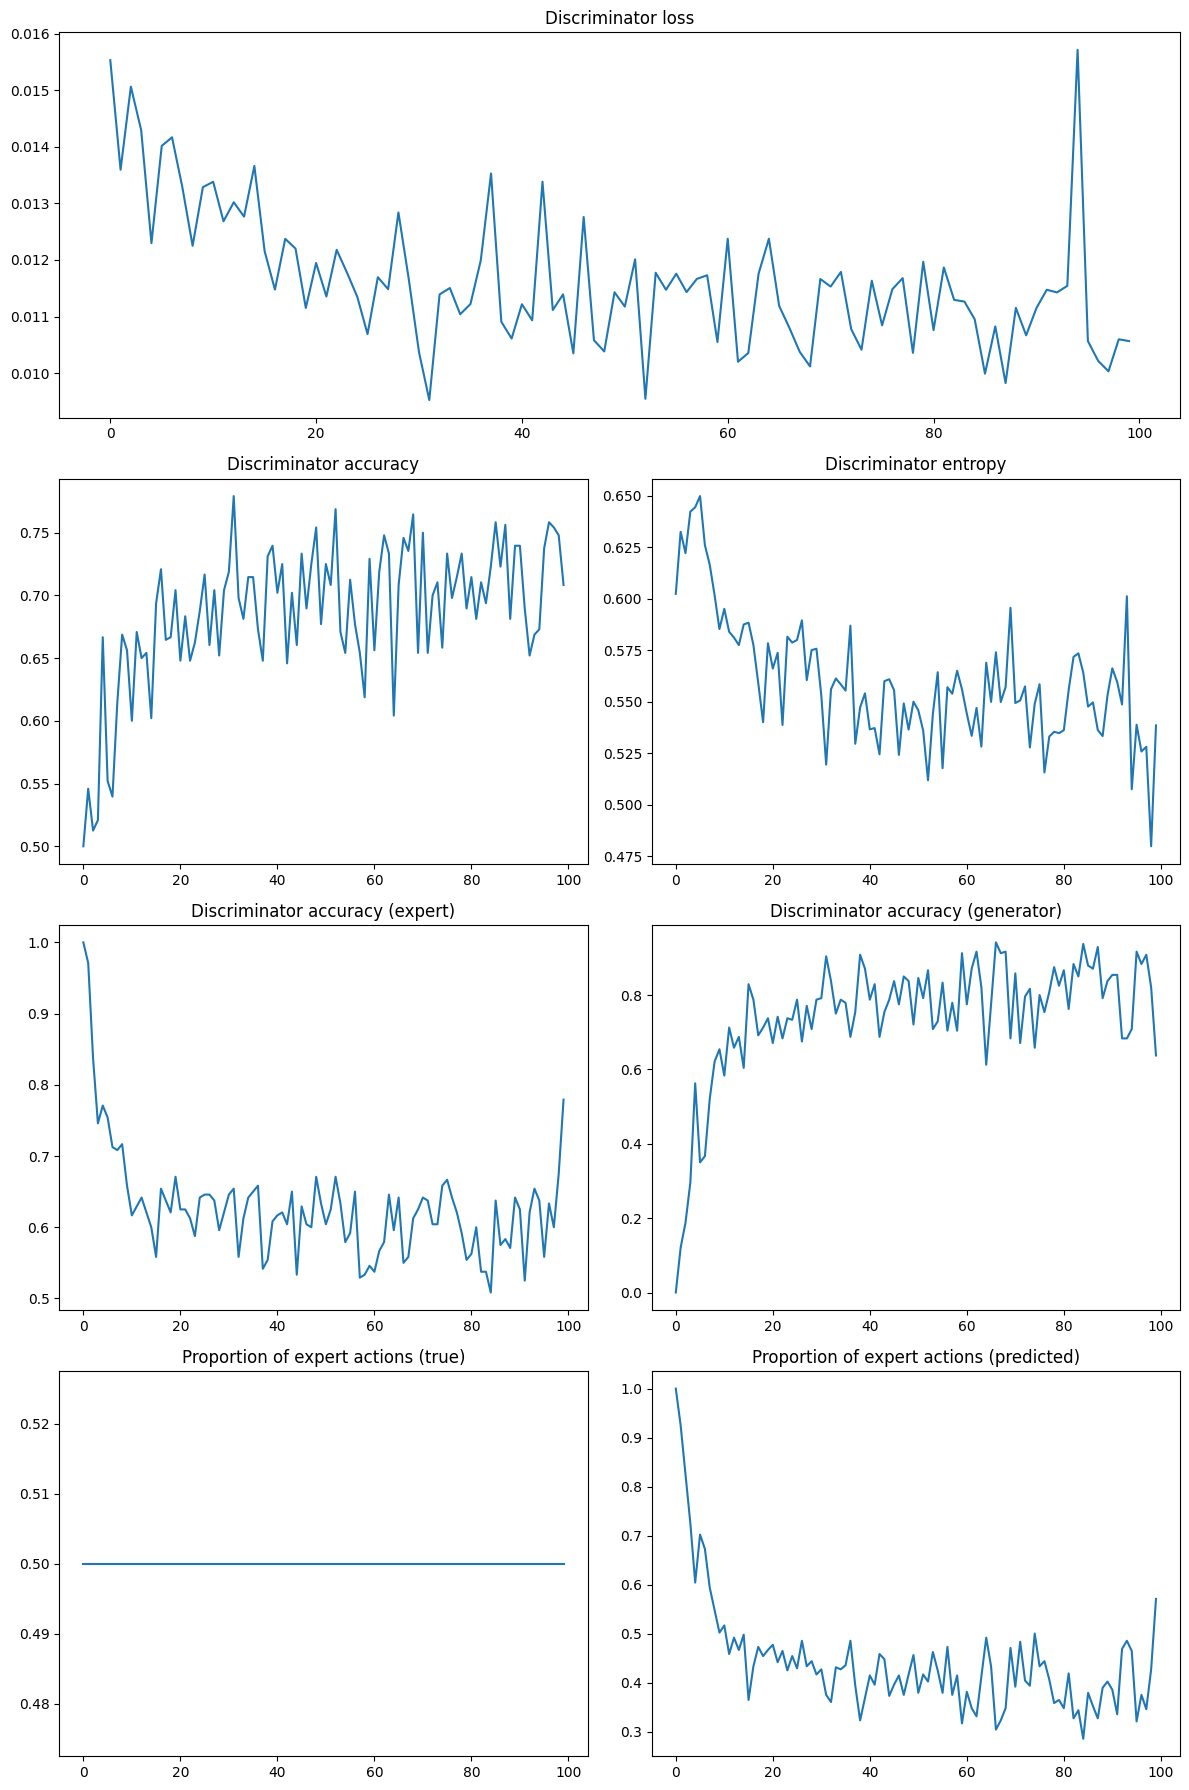

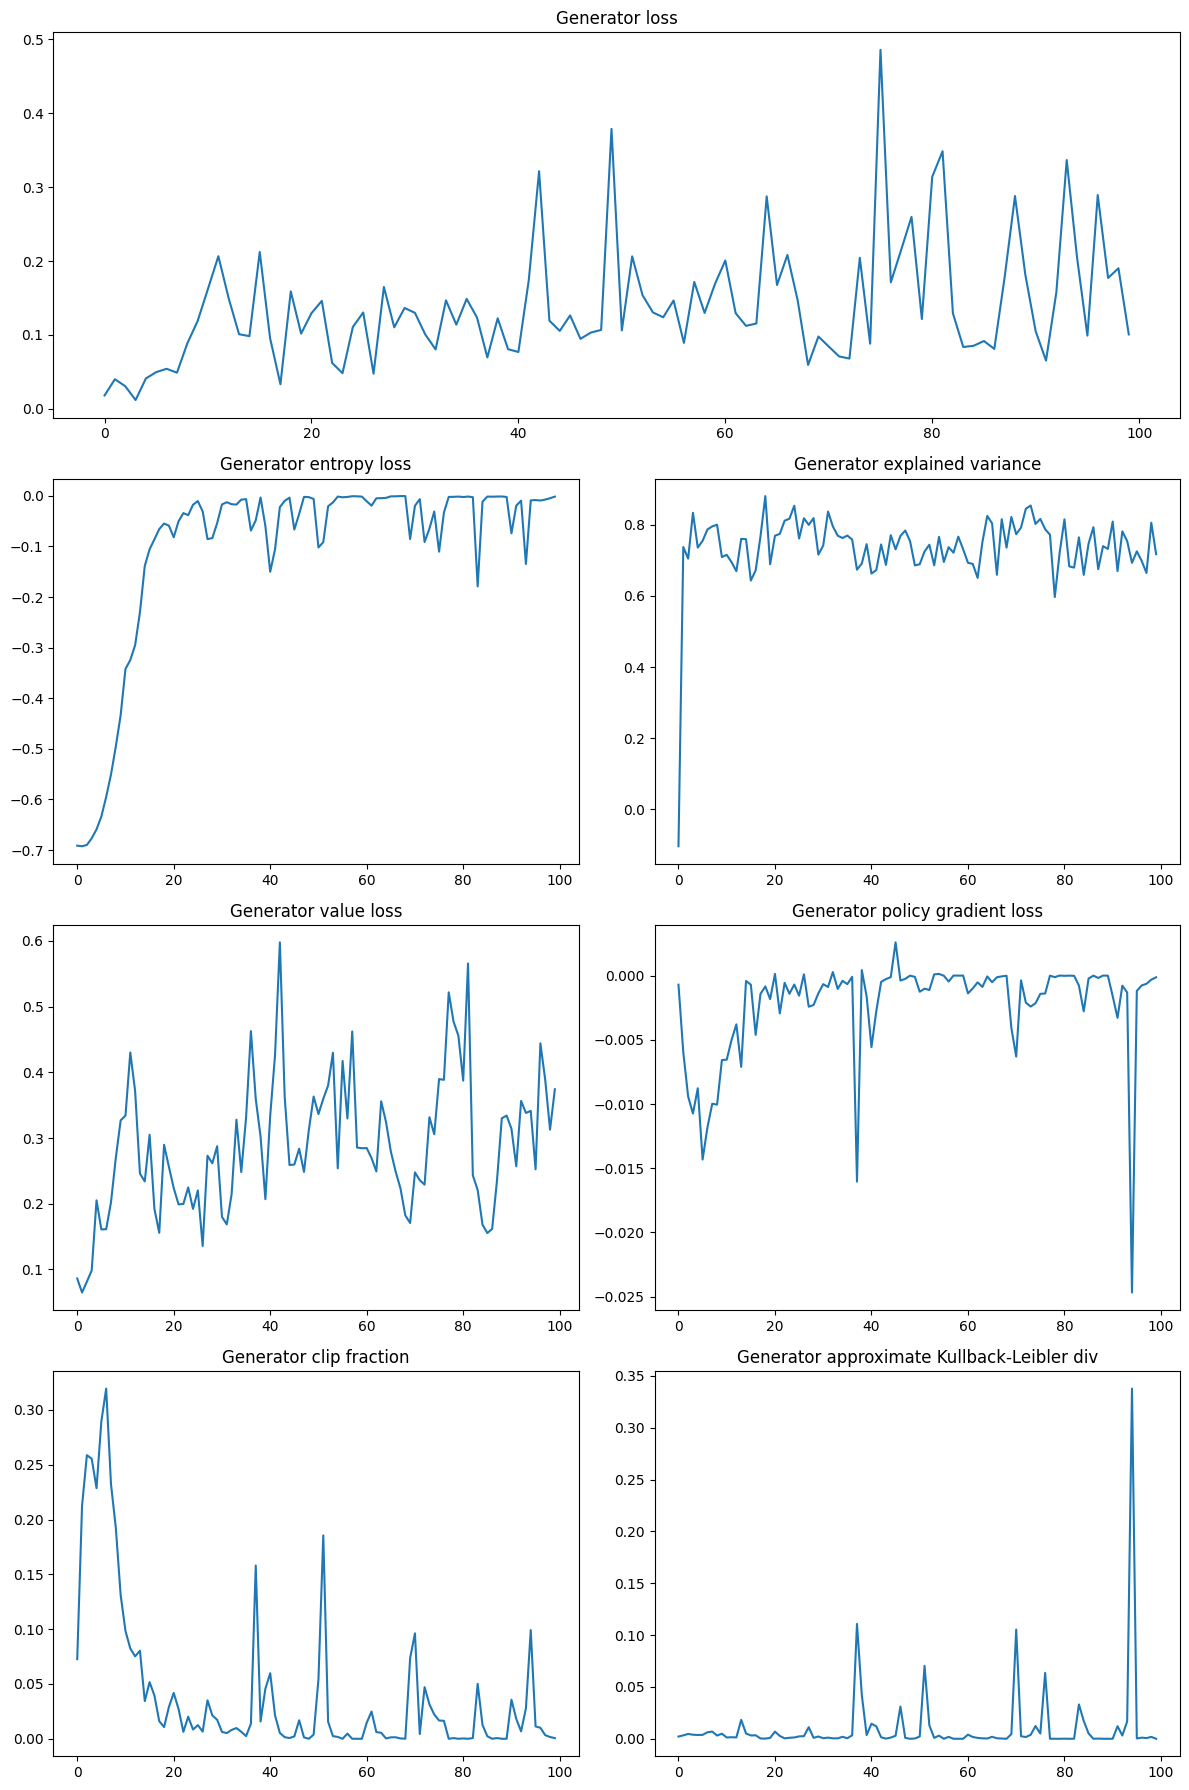

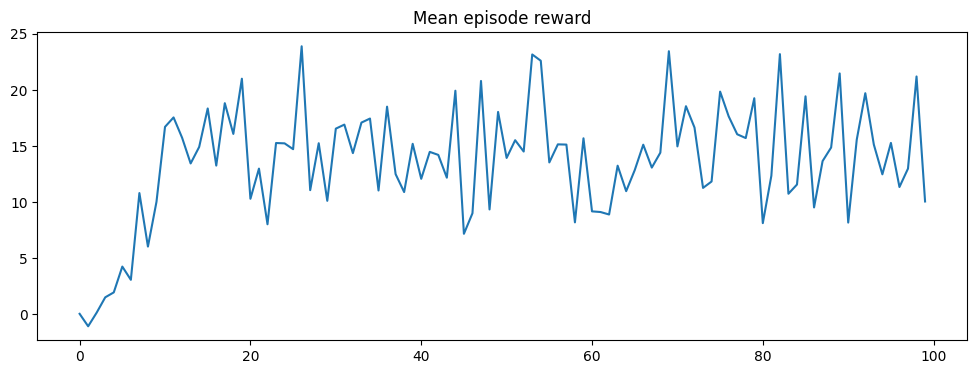

In [9]:
visualize_airl_train_stats(stats1)

In [402]:
states0, obs0, next_states0, dones0 = (
    trajectories_0_test.obs,
    trajectories_0_test.acts,
    trajectories_0_test.next_obs,
    trajectories_0_test.dones,
)
states1, obs1, next_states1, dones1 = (
    trajectories_1_test.obs,
    trajectories_1_test.acts,
    trajectories_1_test.next_obs,
    trajectories_1_test.dones,
)

In [349]:
# For reward_net1
rewards1 = reward_net1.predict(states0, obs0, next_states0, dones0)
norm_rewards1 = (rewards1 - rewards1.mean()) / rewards1.std()
print("Reward network 1 with traj0: ", norm_rewards1.mean())

# For reward_net0
rewards0 = reward_net0.predict(states0, obs0, next_states0, dones0)
norm_rewards0 = (rewards0 - rewards0.mean()) / rewards0.std()
print("Reward network 0 with traj0: ", norm_rewards0.mean())

Reward network 1 with traj0:  1.5287453e-08
Reward network 0 with traj0:  4.0129564e-08


In [350]:
# For reward_net1
rewards1 = reward_net1.predict(states1, obs1, next_states1, dones1)
norm_rewards1 = (rewards1 - rewards1.mean()) / rewards1.std()
print("Reward network 1 with traj1: ", norm_rewards1.mean())

# For reward_net0
rewards0 = reward_net0.predict(states1, obs1, next_states1, dones1)
norm_rewards0 = (rewards0 - rewards0.mean()) / rewards0.std()
print("Reward network 0 with traj1: ", norm_rewards0.mean())

Reward network 1 with traj1:  1.0056319e-08
Reward network 0 with traj1:  -6.704213e-09


Calibration

In [403]:
states, obs, next_states, dones = (
    trajectories_val.obs,
    trajectories_val.acts,
    trajectories_val.next_obs,
    trajectories_val.dones,
)

In [404]:
outputs_arb = reward_net1.predict(states, obs, next_states, dones)
outputs_nonarb = reward_net0.predict(states, obs, next_states, dones)

# Compute empirical mean and std for each network
mean_arb, std_arb = outputs_arb.mean(), outputs_arb.std()
mean_nonarb, std_nonarb = outputs_nonarb.mean(), outputs_nonarb.std()

# Define target calibration values (e.g., mean=0, std=1)
target_mean, target_std = 0.0, 1.0

# Calculate affine transformation parameters
alpha_arb = target_std / std_arb
beta_arb = target_mean - alpha_arb * mean_arb

alpha_nonarb = target_std / std_nonarb
beta_nonarb = target_mean - alpha_nonarb * mean_nonarb

# Calibrate the outputs
calibrated_arb = outputs_arb * alpha_arb + beta_arb
calibrated_nonarb = outputs_nonarb * alpha_nonarb + beta_nonarb

In [411]:
# For reward_net1
rewards1 = reward_net1.predict(states0, obs0, next_states0, dones0)
calibrated_rewards1 = alpha_arb * rewards1 + beta_arb
print("Reward network 1 with traj0: ", calibrated_rewards1.mean())

# For reward_net0
rewards0 = reward_net0.predict(states0, obs0, next_states0, dones0)
calibrated_rewards0 = alpha_nonarb * rewards0 + beta_nonarb
print("Reward network 0 with traj0: ", calibrated_rewards0.mean())

Reward network 1 with traj0:  0.033660296
Reward network 0 with traj0:  0.050710455


In [412]:
s = 0
for index, _ in enumerate(calibrated_rewards1):
    s += 1 if calibrated_rewards0[index] > calibrated_rewards1[index] else 0

print("Accuracy:", s / len(calibrated_rewards1))

Accuracy: 0.25440222428174236


In [409]:
# For reward_net1
rewards1 = reward_net1.predict(states1, obs1, next_states1, dones1)
calibrated_rewards1 = alpha_arb * rewards1 + beta_arb
print("Reward network 1 with traj1: ", calibrated_rewards1.mean())

# For reward_net0
rewards0 = reward_net0.predict(states1, obs1, next_states1, dones1)
calibrated_rewards0 = alpha_nonarb * rewards0 + beta_nonarb
print("Reward network 0 with traj1: ", calibrated_rewards0.mean())

Reward network 1 with traj1:  0.12443851
Reward network 0 with traj1:  -0.11809416


In [410]:
s = 0
for index, _ in enumerate(calibrated_rewards1):
    s += 1 if calibrated_rewards0[index] < calibrated_rewards1[index] else 0

print("Accuracy:", s / len(calibrated_rewards1))

Accuracy: 0.8532513181019332
